# ZJU Artificial Intelligence Safety HW01
Instructor: Jie Song

Requirements:
- Creating your own github account.
- Implementing your own deep neural network (in Pytorch, PaddlePaddle...).
- Training it on CIFAR10.
- Tuning a hyper-parameter and analyzing its effects on performance.
- Writing a README.md to report your findings.

## Import Packages

In [1]:
# PyTorch
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torchvision.models as models

# For data preprocess
import numpy as np
import csv

# For the progress bar.
from tqdm import tqdm

# For plotting
import matplotlib.pyplot as plt

import os
import sys
import time

Ignore warnings.

In [2]:
import warnings
# warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning)

## Hyper-parameters and configs

In [3]:
AVAIL_GPUS = min(1, torch.cuda.device_count())  # Check whether the GPU is available
NUM_WORKERS = int(os.cpu_count() / 2)
LOG_PATH = "./train.log"  # Record some information during the training

In [4]:
'''Hyper-parameters'''
BATCH_SIZE = 128
LEARNING_RATE = 0.01
NUM_EPOCHS = 200

## Dataset, Data Loader, and Transforms

In [22]:
'''Data augmentation'''
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.5, 0.5, 0.5 ],
                         std  = [ 0.5, 0.5, 0.5 ]),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.5, 0.5, 0.5 ],
                         std  = [ 0.5, 0.5, 0.5 ]),
    ])

In [23]:
'''CIFAR-10 dataset'''
train_dataset = datasets.CIFAR10('./data', train=True, transform=transform_train, download=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataset = datasets.CIFAR10('./data', train=False, transform=transform_test, download=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
print(len(train_dataset))

Files already downloaded and verified
Files already downloaded and verified
50000


## Model

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
# model = models.resnet18()
model = Net()
# model = models.resnet152()
# model = models.densenet121()
# model = models.vgg19_bn()
if AVAIL_GPUS:
    model = model.cuda()

## Training

In [9]:
'''Loss function and optimizer'''
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
# optimizer = optim.Adam(model.parameters(), weight_decay=5e-4)
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-3)
def get_optimizer(epoch):
    return optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [10]:
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0

'''Training'''
def train(epoch):
    global train_loss_record
    global train_acc_record
    global LEARNING_RATE
    
#     print("-"*10, "Training Epoch #%d, Learning Rate=%.5f" % (epoch, LEARNING_RATE), "-"*10)
#     with open(LOG_PATH, "a") as f:
#         f.write("-"*10 + "Training Epoch #%d, Learning Rate=%.5f" % (epoch, LEARNING_RATE) + "-"*10)
#         f.write("\n")
#     print("-"*10, "Training Epoch #%d" % (epoch), "-"*10)
#     with open(LOG_PATH, "a") as f:
#         f.write("-"*10 + "Training Epoch #%d" % (epoch) + "-"*10)
#         f.write("\n")
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    optimizer = get_optimizer(epoch)
    for i, data in tqdm(enumerate(train_loader, 1)):
        img, label = data
        # cuda
        if AVAIL_GPUS:
            img = img.cuda()
            label = label.cuda()
        img = Variable(img)
        label = Variable(label)
        
        optimizer.zero_grad()
        
        out = model(img)  # Forward Propagation
        loss = criterion(out, label)  # Loss
        
        train_loss += loss.item() * label.size(0)
        _, pred = torch.max(out, 1)
        num_correct = (pred == label).sum()
        accuracy = (pred == label).float().mean()
        train_acc += num_correct.item()

        loss.backward()  # Backward Propagation
        optimizer.step()  # Optimizer update
    print("Finish %d epoch, Train loss: %.6f, Train acc@1: %.6f" % 
          (epoch + 1, 
           train_loss / (len(train_dataset)), 
           train_acc / (len(train_dataset))))
    with open(LOG_PATH, "a") as f:
        f.write("Finish %d epoch, Train loss: %.6f, Train acc@1: %.6f" % 
                (epoch + 1, 
                 train_loss / (len(train_dataset)),
                 train_acc / (len(train_dataset))))
        f.write("\n")
    train_loss_record.append(train_loss / (len(train_dataset)))
    train_acc_record.append(train_acc / (len(train_dataset)))

def test(epoch):
    global test_loss_record
    global test_acc_record
    global best_acc
    
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.no_grad():
        for data in test_loader:
            img, label = data
            if AVAIL_GPUS:
                img = Variable(img, volatile=True).cuda()
                label = Variable(label, volatile=True).cuda()
            else:
                img = Variable(img, volatile=True)
                label = Variable(label, volatile=True)
            out = model(img)
            loss = criterion(out, label)
            test_loss += loss.item() * label.size(0)
            _, pred = torch.max(out, 1)
            num_correct = (pred == label).sum()
            test_acc += num_correct.item()
    print("Test loss: %.6f, Test acc@1: %.6f" % (
        test_loss / (len(test_dataset)), 
        test_acc / (len(test_dataset))))
    with open(LOG_PATH, "a") as f:
        f.write("Test loss: %.6f, Test acc@1: %.6f" % (
                test_loss / (len(test_dataset)), 
                test_acc / (len(test_dataset))))
        f.write("\n")
    test_loss_record.append(test_loss / (len(test_dataset)))
    test_acc_record.append(test_acc / (len(test_dataset)))
    
    acc = 100. * test_acc / (len(test_dataset))
    if acc > best_acc:
        print("Saving Best model...\t\t\tTop1 = %.6f%%" %(acc))
        with open(LOG_PATH, "a") as f:
            f.write("Saving best model...\t\t\tTop1 = %.6f%%" %(acc))
            f.write("\n")
        torch.save(model.state_dict(), "./cnn.pth")  # Save the best model
        best_acc = acc

In [11]:
LOG_PATH="./train0.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
    
print("Model: CNN from Pytorch tutorial")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: SGD")
print("Learning rate: %d" % (LEARNING_RATE))
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: SGD")
    f.write("\n")
    f.write("Learning rate: %d" % (LEARNING_RATE))
    f.write("\n")

elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
    
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: CNN from Pytorch tutorial
Batch size: 128
Epoch num: 200
Optimizer: SGD
Learning rate: 0
---------- Training Epoch #0 ----------


391it [00:08, 48.53it/s] 

Finish 1 epoch, Train loss: 2.300411, Train acc@1: 0.088560


Test loss: 2.295577, Test acc@1: 0.103400
Saving Best model...			Top1 = 10.340000%
Elapsed time: 9.774450778961182
---------- Training Epoch #1 ----------


391it [00:03, 112.12it/s]

Finish 2 epoch, Train loss: 2.281425, Train acc@1: 0.159960


Test loss: 2.246642, Test acc@1: 0.191900
Saving Best model...			Top1 = 19.190000%
Elapsed time: 15.224514722824097
---------- Training Epoch #2 ----------


391it [00:03, 112.06it/s]

Finish 3 epoch, Train loss: 2.142932, Train acc@1: 0.231720


Test loss: 2.057445, Test acc@1: 0.275600
Saving Best model...			Top1 = 27.560000%
Elapsed time: 20.673418045043945
---------- Training Epoch #3 ----------


391it [00:03, 116.89it/s]

Finish 4 epoch, Train loss: 1.972267, Train acc@1: 0.288160


Test loss: 1.909335, Test acc@1: 0.312200
Saving Best model...			Top1 = 31.220000%
Elapsed time: 25.984564542770386
---------- Training Epoch #4 ----------


391it [00:03, 115.42it/s]

Finish 5 epoch, Train loss: 1.858051, Train acc@1: 0.321920


Test loss: 1.794630, Test acc@1: 0.351600
Saving Best model...			Top1 = 35.160000%
Elapsed time: 31.31628727912903
---------- Training Epoch #5 ----------


391it [00:03, 112.38it/s]

Finish 6 epoch, Train loss: 1.760698, Train acc@1: 0.355700


Test loss: 1.750245, Test acc@1: 0.358100
Saving Best model...			Top1 = 35.810000%
Elapsed time: 36.77387547492981
---------- Training Epoch #6 ----------


391it [00:03, 113.52it/s]

Finish 7 epoch, Train loss: 1.698437, Train acc@1: 0.378100


Test loss: 1.659386, Test acc@1: 0.397200
Saving Best model...			Top1 = 39.720000%
Elapsed time: 42.21384048461914
---------- Training Epoch #7 ----------


391it [00:03, 114.32it/s]

Finish 8 epoch, Train loss: 1.649878, Train acc@1: 0.397900


Test loss: 1.627665, Test acc@1: 0.401500
Saving Best model...			Top1 = 40.150000%
Elapsed time: 47.6539671421051
---------- Training Epoch #8 ----------


391it [00:03, 113.99it/s]

Finish 9 epoch, Train loss: 1.602649, Train acc@1: 0.417760


Test loss: 1.577730, Test acc@1: 0.420700
Saving Best model...			Top1 = 42.070000%
Elapsed time: 53.1711483001709
---------- Training Epoch #9 ----------


391it [00:03, 114.82it/s]

Finish 10 epoch, Train loss: 1.564855, Train acc@1: 0.431640


Test loss: 1.557207, Test acc@1: 0.430200
Saving Best model...			Top1 = 43.020000%
Elapsed time: 58.52681541442871
---------- Training Epoch #10 ----------


391it [00:03, 113.45it/s]

Finish 11 epoch, Train loss: 1.531273, Train acc@1: 0.444940


Test loss: 1.512919, Test acc@1: 0.444500
Saving Best model...			Top1 = 44.450000%
Elapsed time: 63.88314986228943
---------- Training Epoch #11 ----------


391it [00:03, 114.33it/s]

Finish 12 epoch, Train loss: 1.500382, Train acc@1: 0.455560


Test loss: 1.541012, Test acc@1: 0.435200
Elapsed time: 69.29193210601807
---------- Training Epoch #12 ----------


391it [00:03, 112.68it/s]

Finish 13 epoch, Train loss: 1.471081, Train acc@1: 0.468200


Test loss: 1.455935, Test acc@1: 0.466600
Saving Best model...			Top1 = 46.660000%
Elapsed time: 74.67674493789673
---------- Training Epoch #13 ----------


391it [00:03, 112.53it/s]

Finish 14 epoch, Train loss: 1.444099, Train acc@1: 0.480880


Test loss: 1.455329, Test acc@1: 0.472900
Saving Best model...			Top1 = 47.290000%
Elapsed time: 80.11404490470886
---------- Training Epoch #14 ----------


391it [00:03, 115.75it/s]

Finish 15 epoch, Train loss: 1.417921, Train acc@1: 0.490680


Test loss: 1.404400, Test acc@1: 0.487000
Saving Best model...			Top1 = 48.700000%
Elapsed time: 85.49710035324097
---------- Training Epoch #15 ----------


391it [00:03, 116.27it/s]

Finish 16 epoch, Train loss: 1.390833, Train acc@1: 0.500600


Test loss: 1.413347, Test acc@1: 0.485900
Elapsed time: 92.27727246284485
---------- Training Epoch #16 ----------


391it [00:03, 113.81it/s]

Finish 17 epoch, Train loss: 1.366049, Train acc@1: 0.510400


Test loss: 1.401595, Test acc@1: 0.491400
Saving Best model...			Top1 = 49.140000%
Elapsed time: 97.79991221427917
---------- Training Epoch #17 ----------


391it [00:03, 128.30it/s]

Finish 18 epoch, Train loss: 1.341981, Train acc@1: 0.519100


Test loss: 1.348191, Test acc@1: 0.512000
Saving Best model...			Top1 = 51.200000%
Elapsed time: 102.82607913017273
---------- Training Epoch #18 ----------


391it [00:03, 130.23it/s]

Finish 19 epoch, Train loss: 1.317800, Train acc@1: 0.529480


Test loss: 1.331983, Test acc@1: 0.519000
Saving Best model...			Top1 = 51.900000%
Elapsed time: 107.81539416313171
---------- Training Epoch #19 ----------


391it [00:03, 121.54it/s]

Finish 20 epoch, Train loss: 1.298417, Train acc@1: 0.535120


Test loss: 1.321271, Test acc@1: 0.523700
Saving Best model...			Top1 = 52.370000%
Elapsed time: 113.08562302589417
---------- Training Epoch #20 ----------


391it [00:03, 123.68it/s]

Finish 21 epoch, Train loss: 1.277721, Train acc@1: 0.543040


Test loss: 1.291024, Test acc@1: 0.534700
Saving Best model...			Top1 = 53.470000%
Elapsed time: 118.20151472091675
---------- Training Epoch #21 ----------


391it [00:03, 129.71it/s]

Finish 22 epoch, Train loss: 1.255902, Train acc@1: 0.551560


Test loss: 1.386920, Test acc@1: 0.510000
Elapsed time: 123.25440788269043
---------- Training Epoch #22 ----------


391it [00:03, 130.21it/s]

Finish 23 epoch, Train loss: 1.235396, Train acc@1: 0.559320


Test loss: 1.264627, Test acc@1: 0.541000
Saving Best model...			Top1 = 54.100000%
Elapsed time: 128.17753291130066
---------- Training Epoch #23 ----------


391it [00:03, 127.91it/s]

Finish 24 epoch, Train loss: 1.216987, Train acc@1: 0.566440


Test loss: 1.407888, Test acc@1: 0.507500
Elapsed time: 133.16375160217285
---------- Training Epoch #24 ----------


391it [00:03, 119.60it/s]

Finish 25 epoch, Train loss: 1.199084, Train acc@1: 0.573320


Test loss: 1.245958, Test acc@1: 0.554000
Saving Best model...			Top1 = 55.400000%
Elapsed time: 138.42508912086487
---------- Training Epoch #25 ----------


391it [00:03, 128.56it/s]

Finish 26 epoch, Train loss: 1.182787, Train acc@1: 0.579260


Test loss: 1.191210, Test acc@1: 0.573800
Saving Best model...			Top1 = 57.380000%
Elapsed time: 143.3696768283844
---------- Training Epoch #26 ----------


391it [00:03, 126.69it/s]

Finish 27 epoch, Train loss: 1.167327, Train acc@1: 0.585020


Test loss: 1.219277, Test acc@1: 0.558500
Elapsed time: 148.32643222808838
---------- Training Epoch #27 ----------


391it [00:03, 128.93it/s]

Finish 28 epoch, Train loss: 1.152051, Train acc@1: 0.591460


Test loss: 1.239973, Test acc@1: 0.555900
Elapsed time: 153.33170294761658
---------- Training Epoch #28 ----------


391it [00:03, 128.05it/s]

Finish 29 epoch, Train loss: 1.136519, Train acc@1: 0.596560


Test loss: 1.181705, Test acc@1: 0.580000
Saving Best model...			Top1 = 58.000000%
Elapsed time: 158.26542925834656
---------- Training Epoch #29 ----------


391it [00:03, 129.38it/s]

Finish 30 epoch, Train loss: 1.123280, Train acc@1: 0.601960


Test loss: 1.210124, Test acc@1: 0.568400
Elapsed time: 163.26355409622192
---------- Training Epoch #30 ----------


391it [00:03, 127.33it/s]

Finish 31 epoch, Train loss: 1.110217, Train acc@1: 0.608660


Test loss: 1.177450, Test acc@1: 0.577500
Elapsed time: 168.28976964950562
---------- Training Epoch #31 ----------


391it [00:03, 113.18it/s]

Finish 32 epoch, Train loss: 1.099753, Train acc@1: 0.610740


Test loss: 1.158482, Test acc@1: 0.586200
Saving Best model...			Top1 = 58.620000%
Elapsed time: 173.68475484848022
---------- Training Epoch #32 ----------


391it [00:03, 120.85it/s]

Finish 33 epoch, Train loss: 1.085467, Train acc@1: 0.616660


Test loss: 1.118048, Test acc@1: 0.606300
Saving Best model...			Top1 = 60.630000%
Elapsed time: 178.82952451705933
---------- Training Epoch #33 ----------


391it [00:03, 119.83it/s]

Finish 34 epoch, Train loss: 1.072881, Train acc@1: 0.623060


Test loss: 1.134834, Test acc@1: 0.596900
Elapsed time: 184.10888147354126
---------- Training Epoch #34 ----------


391it [00:03, 112.70it/s]

Finish 35 epoch, Train loss: 1.061899, Train acc@1: 0.626940


Test loss: 1.179077, Test acc@1: 0.581500
Elapsed time: 189.60402464866638
---------- Training Epoch #35 ----------


391it [00:03, 115.04it/s]

Finish 36 epoch, Train loss: 1.052079, Train acc@1: 0.630440


Test loss: 1.130739, Test acc@1: 0.602400
Elapsed time: 194.94784021377563
---------- Training Epoch #36 ----------


391it [00:03, 114.21it/s]

Finish 37 epoch, Train loss: 1.041395, Train acc@1: 0.634040


Test loss: 1.197053, Test acc@1: 0.572100
Elapsed time: 200.42825198173523
---------- Training Epoch #37 ----------


391it [00:03, 112.77it/s]

Finish 38 epoch, Train loss: 1.031618, Train acc@1: 0.637000


Test loss: 1.192886, Test acc@1: 0.579300
Elapsed time: 205.81980299949646
---------- Training Epoch #38 ----------


391it [00:03, 112.90it/s]

Finish 39 epoch, Train loss: 1.021616, Train acc@1: 0.640440


Test loss: 1.094883, Test acc@1: 0.613300
Saving Best model...			Top1 = 61.330000%
Elapsed time: 211.2826054096222
---------- Training Epoch #39 ----------


391it [00:03, 112.97it/s]

Finish 40 epoch, Train loss: 1.008656, Train acc@1: 0.644400


Test loss: 1.083195, Test acc@1: 0.620400
Saving Best model...			Top1 = 62.040000%
Elapsed time: 216.76604628562927
---------- Training Epoch #40 ----------


391it [00:03, 111.97it/s]

Finish 41 epoch, Train loss: 0.999561, Train acc@1: 0.650940


Test loss: 1.088135, Test acc@1: 0.614600
Elapsed time: 222.26134490966797
---------- Training Epoch #41 ----------


391it [00:03, 117.89it/s]

Finish 42 epoch, Train loss: 0.989455, Train acc@1: 0.652660


Test loss: 1.108247, Test acc@1: 0.607200
Elapsed time: 227.61631107330322
---------- Training Epoch #42 ----------


391it [00:03, 117.14it/s]

Finish 43 epoch, Train loss: 0.979261, Train acc@1: 0.655360


Test loss: 1.127235, Test acc@1: 0.600900
Elapsed time: 232.94256615638733
---------- Training Epoch #43 ----------


391it [00:03, 113.86it/s]

Finish 44 epoch, Train loss: 0.970199, Train acc@1: 0.658800


Test loss: 1.064028, Test acc@1: 0.622600
Saving Best model...			Top1 = 62.260000%
Elapsed time: 238.36799311637878
---------- Training Epoch #44 ----------


391it [00:03, 115.36it/s]

Finish 45 epoch, Train loss: 0.959829, Train acc@1: 0.664300


Test loss: 1.050083, Test acc@1: 0.632400
Saving Best model...			Top1 = 63.240000%
Elapsed time: 243.72953343391418
---------- Training Epoch #45 ----------


391it [00:03, 108.92it/s]

Finish 46 epoch, Train loss: 0.949562, Train acc@1: 0.667100


Test loss: 1.063581, Test acc@1: 0.625800
Elapsed time: 249.24183773994446
---------- Training Epoch #46 ----------


391it [00:03, 114.38it/s]

Finish 47 epoch, Train loss: 0.945947, Train acc@1: 0.667140


Test loss: 1.142780, Test acc@1: 0.600800
Elapsed time: 254.6120502948761
---------- Training Epoch #47 ----------


391it [00:03, 113.68it/s]

Finish 48 epoch, Train loss: 0.932720, Train acc@1: 0.675340


Test loss: 1.091375, Test acc@1: 0.614800
Elapsed time: 260.00397086143494
---------- Training Epoch #48 ----------


391it [00:03, 112.04it/s]

Finish 49 epoch, Train loss: 0.923217, Train acc@1: 0.675780


Test loss: 1.069130, Test acc@1: 0.625100
Elapsed time: 265.58533358573914
---------- Training Epoch #49 ----------


391it [00:03, 114.61it/s]

Finish 50 epoch, Train loss: 0.918539, Train acc@1: 0.676900


Test loss: 1.058150, Test acc@1: 0.631300
Elapsed time: 270.9568567276001
---------- Training Epoch #50 ----------


391it [00:03, 113.78it/s]

Finish 51 epoch, Train loss: 0.911862, Train acc@1: 0.680280


Test loss: 1.107665, Test acc@1: 0.615400
Elapsed time: 276.3404939174652
---------- Training Epoch #51 ----------


391it [00:03, 111.11it/s]

Finish 52 epoch, Train loss: 0.899231, Train acc@1: 0.687200


Test loss: 1.066143, Test acc@1: 0.622900
Elapsed time: 281.94866037368774
---------- Training Epoch #52 ----------


391it [00:03, 115.26it/s]

Finish 53 epoch, Train loss: 0.892035, Train acc@1: 0.689380


Test loss: 1.088847, Test acc@1: 0.623400
Elapsed time: 287.311083316803
---------- Training Epoch #53 ----------


391it [00:03, 111.86it/s]

Finish 54 epoch, Train loss: 0.881141, Train acc@1: 0.691220


Test loss: 1.075490, Test acc@1: 0.626700
Elapsed time: 292.83265209198
---------- Training Epoch #54 ----------


391it [00:03, 117.46it/s]

Finish 55 epoch, Train loss: 0.874349, Train acc@1: 0.696040


Test loss: 1.079184, Test acc@1: 0.623600
Elapsed time: 298.17295360565186
---------- Training Epoch #55 ----------


391it [00:03, 113.70it/s]

Finish 56 epoch, Train loss: 0.867347, Train acc@1: 0.696320


Test loss: 1.127906, Test acc@1: 0.604300
Elapsed time: 303.69593238830566
---------- Training Epoch #56 ----------


391it [00:03, 116.48it/s]

Finish 57 epoch, Train loss: 0.861987, Train acc@1: 0.698620


Test loss: 1.063970, Test acc@1: 0.630700
Elapsed time: 309.05377316474915
---------- Training Epoch #57 ----------


391it [00:03, 112.93it/s]

Finish 58 epoch, Train loss: 0.851711, Train acc@1: 0.701940


Test loss: 1.032614, Test acc@1: 0.647900
Saving Best model...			Top1 = 64.790000%
Elapsed time: 314.4877541065216
---------- Training Epoch #58 ----------


391it [00:03, 115.26it/s]

Finish 59 epoch, Train loss: 0.846497, Train acc@1: 0.703860


Test loss: 1.052755, Test acc@1: 0.636800
Elapsed time: 319.8092677593231
---------- Training Epoch #59 ----------


391it [00:03, 116.26it/s]

Finish 60 epoch, Train loss: 0.837302, Train acc@1: 0.707480


Test loss: 1.044836, Test acc@1: 0.637800
Elapsed time: 325.1634259223938
---------- Training Epoch #60 ----------


391it [00:03, 112.00it/s]

Finish 61 epoch, Train loss: 0.828640, Train acc@1: 0.709720


Test loss: 1.064653, Test acc@1: 0.628500
Elapsed time: 330.602751493454
---------- Training Epoch #61 ----------


391it [00:03, 116.93it/s]

Finish 62 epoch, Train loss: 0.823642, Train acc@1: 0.712280


Test loss: 1.101510, Test acc@1: 0.627100
Elapsed time: 335.87212109565735
---------- Training Epoch #62 ----------


391it [00:03, 112.72it/s]

Finish 63 epoch, Train loss: 0.813274, Train acc@1: 0.714740


Test loss: 1.059464, Test acc@1: 0.635400
Elapsed time: 341.22121357917786
---------- Training Epoch #63 ----------


391it [00:03, 112.22it/s]

Finish 64 epoch, Train loss: 0.807905, Train acc@1: 0.717240


Test loss: 1.060393, Test acc@1: 0.632200
Elapsed time: 346.71383118629456
---------- Training Epoch #64 ----------


391it [00:03, 114.08it/s]

Finish 65 epoch, Train loss: 0.804338, Train acc@1: 0.717300


Test loss: 1.036076, Test acc@1: 0.644400
Elapsed time: 352.1838438510895
---------- Training Epoch #65 ----------


391it [00:03, 113.39it/s]

Finish 66 epoch, Train loss: 0.794929, Train acc@1: 0.721700


Test loss: 1.084024, Test acc@1: 0.631000
Elapsed time: 357.6489579677582
---------- Training Epoch #66 ----------


391it [00:03, 114.26it/s]

Finish 67 epoch, Train loss: 0.789121, Train acc@1: 0.723100


Test loss: 1.053244, Test acc@1: 0.641100
Elapsed time: 363.10647344589233
---------- Training Epoch #67 ----------


391it [00:03, 115.95it/s]

Finish 68 epoch, Train loss: 0.781379, Train acc@1: 0.726400


Test loss: 1.047569, Test acc@1: 0.640200
Elapsed time: 368.47046542167664
---------- Training Epoch #68 ----------


391it [00:03, 111.09it/s]

Finish 69 epoch, Train loss: 0.773787, Train acc@1: 0.728500


Test loss: 1.078313, Test acc@1: 0.634900
Elapsed time: 373.9104628562927
---------- Training Epoch #69 ----------


391it [00:03, 113.40it/s]

Finish 70 epoch, Train loss: 0.767018, Train acc@1: 0.729180


Test loss: 1.038470, Test acc@1: 0.645200
Elapsed time: 379.2574439048767
---------- Training Epoch #70 ----------


391it [00:03, 113.70it/s]

Finish 71 epoch, Train loss: 0.759829, Train acc@1: 0.733860


Test loss: 1.073212, Test acc@1: 0.632200
Elapsed time: 384.6001613140106
---------- Training Epoch #71 ----------


391it [00:03, 113.78it/s]

Finish 72 epoch, Train loss: 0.754875, Train acc@1: 0.734580


Test loss: 1.076352, Test acc@1: 0.637100
Elapsed time: 389.95356273651123
---------- Training Epoch #72 ----------


391it [00:03, 115.18it/s]

Finish 73 epoch, Train loss: 0.747009, Train acc@1: 0.737420


Test loss: 1.069033, Test acc@1: 0.636400
Elapsed time: 395.3633933067322
---------- Training Epoch #73 ----------


391it [00:03, 112.36it/s]

Finish 74 epoch, Train loss: 0.739569, Train acc@1: 0.740280


Test loss: 1.061259, Test acc@1: 0.638800
Elapsed time: 400.88207364082336
---------- Training Epoch #74 ----------


391it [00:03, 113.35it/s]

Finish 75 epoch, Train loss: 0.732606, Train acc@1: 0.741420


Test loss: 1.043340, Test acc@1: 0.647200
Elapsed time: 406.31249499320984
---------- Training Epoch #75 ----------


391it [00:03, 113.70it/s]

Finish 76 epoch, Train loss: 0.726982, Train acc@1: 0.742300


Test loss: 1.055647, Test acc@1: 0.644100
Elapsed time: 411.71533942222595
---------- Training Epoch #76 ----------


391it [00:03, 113.36it/s]

Finish 77 epoch, Train loss: 0.717553, Train acc@1: 0.747880


Test loss: 1.083916, Test acc@1: 0.640100
Elapsed time: 417.22506308555603
---------- Training Epoch #77 ----------


391it [00:03, 115.34it/s]

Finish 78 epoch, Train loss: 0.716964, Train acc@1: 0.746800


Test loss: 1.076802, Test acc@1: 0.637400
Elapsed time: 422.7043445110321
---------- Training Epoch #78 ----------


391it [00:03, 113.26it/s]

Finish 79 epoch, Train loss: 0.705415, Train acc@1: 0.752740


Test loss: 1.078402, Test acc@1: 0.643600
Elapsed time: 428.1058626174927
---------- Training Epoch #79 ----------


391it [00:03, 113.25it/s]

Finish 80 epoch, Train loss: 0.702482, Train acc@1: 0.751960


Test loss: 1.172221, Test acc@1: 0.623100
Elapsed time: 433.5555229187012
---------- Training Epoch #80 ----------


391it [00:03, 114.45it/s]

Finish 81 epoch, Train loss: 0.694695, Train acc@1: 0.755880


Test loss: 1.179160, Test acc@1: 0.620600
Elapsed time: 438.944052696228
---------- Training Epoch #81 ----------


391it [00:03, 110.61it/s]

Finish 82 epoch, Train loss: 0.688978, Train acc@1: 0.756060


Test loss: 1.082611, Test acc@1: 0.640200
Elapsed time: 444.48392939567566
---------- Training Epoch #82 ----------


391it [00:03, 113.20it/s]

Finish 83 epoch, Train loss: 0.680570, Train acc@1: 0.760240


Test loss: 1.104365, Test acc@1: 0.641200
Elapsed time: 449.8897006511688
---------- Training Epoch #83 ----------


391it [00:03, 112.98it/s]

Finish 84 epoch, Train loss: 0.676691, Train acc@1: 0.760900


Test loss: 1.076739, Test acc@1: 0.644900
Elapsed time: 455.39583826065063
---------- Training Epoch #84 ----------


391it [00:03, 117.21it/s]

Finish 85 epoch, Train loss: 0.668610, Train acc@1: 0.763580


Test loss: 1.087986, Test acc@1: 0.643600
Elapsed time: 460.7070245742798
---------- Training Epoch #85 ----------


391it [00:03, 113.18it/s]

Finish 86 epoch, Train loss: 0.663621, Train acc@1: 0.765980


Test loss: 1.128863, Test acc@1: 0.639800
Elapsed time: 466.2032287120819
---------- Training Epoch #86 ----------


391it [00:03, 114.76it/s]

Finish 87 epoch, Train loss: 0.658230, Train acc@1: 0.767060


Test loss: 1.116283, Test acc@1: 0.641200
Elapsed time: 471.66069865226746
---------- Training Epoch #87 ----------


391it [00:03, 112.03it/s]

Finish 88 epoch, Train loss: 0.651783, Train acc@1: 0.770540


Test loss: 1.153495, Test acc@1: 0.630300
Elapsed time: 477.09208631515503
---------- Training Epoch #88 ----------


391it [00:03, 114.18it/s]

Finish 89 epoch, Train loss: 0.645578, Train acc@1: 0.773220


Test loss: 1.103252, Test acc@1: 0.643800
Elapsed time: 482.51442217826843
---------- Training Epoch #89 ----------


391it [00:03, 114.95it/s]

Finish 90 epoch, Train loss: 0.638695, Train acc@1: 0.774500


Test loss: 1.138829, Test acc@1: 0.635900
Elapsed time: 487.8916518688202
---------- Training Epoch #90 ----------


391it [00:03, 115.02it/s]

Finish 91 epoch, Train loss: 0.635438, Train acc@1: 0.775400


Test loss: 1.106248, Test acc@1: 0.643100
Elapsed time: 493.2817132472992
---------- Training Epoch #91 ----------


391it [00:03, 115.42it/s]

Finish 92 epoch, Train loss: 0.628960, Train acc@1: 0.777720


Test loss: 1.368286, Test acc@1: 0.596400
Elapsed time: 498.69163727760315
---------- Training Epoch #92 ----------


391it [00:03, 113.74it/s]

Finish 93 epoch, Train loss: 0.623329, Train acc@1: 0.780780


Test loss: 1.121411, Test acc@1: 0.644800
Elapsed time: 504.0373134613037
---------- Training Epoch #93 ----------


391it [00:03, 114.93it/s]

Finish 94 epoch, Train loss: 0.614751, Train acc@1: 0.782260


Test loss: 1.134233, Test acc@1: 0.642600
Elapsed time: 509.4021143913269
---------- Training Epoch #94 ----------


391it [00:03, 113.25it/s]

Finish 95 epoch, Train loss: 0.610828, Train acc@1: 0.783300


Test loss: 1.137162, Test acc@1: 0.642000
Elapsed time: 514.7491328716278
---------- Training Epoch #95 ----------


391it [00:03, 114.43it/s]

Finish 96 epoch, Train loss: 0.604080, Train acc@1: 0.786420


Test loss: 1.145679, Test acc@1: 0.641900
Elapsed time: 520.0448868274689
---------- Training Epoch #96 ----------


391it [00:03, 113.76it/s]

Finish 97 epoch, Train loss: 0.600010, Train acc@1: 0.788840


Test loss: 1.155458, Test acc@1: 0.638300
Elapsed time: 525.4525530338287
---------- Training Epoch #97 ----------


391it [00:03, 111.87it/s]

Finish 98 epoch, Train loss: 0.593940, Train acc@1: 0.791460


Test loss: 1.166719, Test acc@1: 0.638200
Elapsed time: 530.9044988155365
---------- Training Epoch #98 ----------


391it [00:03, 112.52it/s]

Finish 99 epoch, Train loss: 0.584946, Train acc@1: 0.792380


Test loss: 1.246738, Test acc@1: 0.625900
Elapsed time: 536.3163557052612
---------- Training Epoch #99 ----------


391it [00:03, 112.80it/s]

Finish 100 epoch, Train loss: 0.581822, Train acc@1: 0.795280


Test loss: 1.171386, Test acc@1: 0.644700
Elapsed time: 541.7535645961761
---------- Training Epoch #100 ----------


391it [00:03, 115.53it/s]

Finish 101 epoch, Train loss: 0.580569, Train acc@1: 0.796760


Test loss: 1.161665, Test acc@1: 0.638400
Elapsed time: 547.1020667552948
---------- Training Epoch #101 ----------


391it [00:03, 111.39it/s]

Finish 102 epoch, Train loss: 0.569513, Train acc@1: 0.797620


Test loss: 1.174353, Test acc@1: 0.639000
Elapsed time: 552.6752359867096
---------- Training Epoch #102 ----------


391it [00:03, 115.62it/s]

Finish 103 epoch, Train loss: 0.566631, Train acc@1: 0.800900


Test loss: 1.163220, Test acc@1: 0.644200
Elapsed time: 558.1267652511597
---------- Training Epoch #103 ----------


391it [00:03, 116.08it/s]

Finish 104 epoch, Train loss: 0.557600, Train acc@1: 0.802800


Test loss: 1.197126, Test acc@1: 0.643500
Elapsed time: 563.4693892002106
---------- Training Epoch #104 ----------


391it [00:03, 116.28it/s]

Finish 105 epoch, Train loss: 0.552926, Train acc@1: 0.804780


Test loss: 1.197419, Test acc@1: 0.640400
Elapsed time: 568.8387377262115
---------- Training Epoch #105 ----------


391it [00:03, 111.34it/s]

Finish 106 epoch, Train loss: 0.548500, Train acc@1: 0.806600


Test loss: 1.242288, Test acc@1: 0.630800
Elapsed time: 574.2380306720734
---------- Training Epoch #106 ----------


391it [00:03, 112.43it/s]

Finish 107 epoch, Train loss: 0.546711, Train acc@1: 0.807180


Test loss: 1.243206, Test acc@1: 0.636700
Elapsed time: 579.664133310318
---------- Training Epoch #107 ----------


391it [00:03, 114.22it/s]

Finish 108 epoch, Train loss: 0.539266, Train acc@1: 0.808120


Test loss: 1.193279, Test acc@1: 0.644500
Elapsed time: 585.0059826374054
---------- Training Epoch #108 ----------


391it [00:03, 117.20it/s]

Finish 109 epoch, Train loss: 0.535018, Train acc@1: 0.811160


Test loss: 1.274173, Test acc@1: 0.629700
Elapsed time: 590.2088325023651
---------- Training Epoch #109 ----------


391it [00:03, 120.36it/s]

Finish 110 epoch, Train loss: 0.526922, Train acc@1: 0.813460


Test loss: 1.278076, Test acc@1: 0.629800
Elapsed time: 595.3228108882904
---------- Training Epoch #110 ----------


391it [00:03, 116.89it/s]

Finish 111 epoch, Train loss: 0.521490, Train acc@1: 0.814380


Test loss: 1.345163, Test acc@1: 0.617800
Elapsed time: 600.4975912570953
---------- Training Epoch #111 ----------


391it [00:03, 123.74it/s]

Finish 112 epoch, Train loss: 0.518615, Train acc@1: 0.815600


Test loss: 1.340832, Test acc@1: 0.617200
Elapsed time: 605.48104429245
---------- Training Epoch #112 ----------


391it [00:03, 123.61it/s]

Finish 113 epoch, Train loss: 0.512069, Train acc@1: 0.818120


Test loss: 1.389261, Test acc@1: 0.613700
Elapsed time: 610.5205056667328
---------- Training Epoch #113 ----------


391it [00:03, 121.86it/s]

Finish 114 epoch, Train loss: 0.507520, Train acc@1: 0.819160


Test loss: 1.258625, Test acc@1: 0.635800
Elapsed time: 615.6314949989319
---------- Training Epoch #114 ----------


391it [00:03, 125.57it/s]

Finish 115 epoch, Train loss: 0.498172, Train acc@1: 0.823160


Test loss: 1.271466, Test acc@1: 0.641300
Elapsed time: 620.6854436397552
---------- Training Epoch #115 ----------


391it [00:03, 121.69it/s]

Finish 116 epoch, Train loss: 0.498104, Train acc@1: 0.823780


Test loss: 1.309535, Test acc@1: 0.634200
Elapsed time: 625.8881590366364
---------- Training Epoch #116 ----------


391it [00:03, 114.59it/s]

Finish 117 epoch, Train loss: 0.487682, Train acc@1: 0.828160


Test loss: 1.326875, Test acc@1: 0.628400
Elapsed time: 631.2879831790924
---------- Training Epoch #117 ----------


391it [00:03, 116.17it/s]

Finish 118 epoch, Train loss: 0.485507, Train acc@1: 0.828160


Test loss: 1.264027, Test acc@1: 0.638100
Elapsed time: 636.5807650089264
---------- Training Epoch #118 ----------


391it [00:03, 113.31it/s]

Finish 119 epoch, Train loss: 0.487258, Train acc@1: 0.826780


Test loss: 1.297608, Test acc@1: 0.630100
Elapsed time: 642.0196738243103
---------- Training Epoch #119 ----------


391it [00:03, 112.97it/s]

Finish 120 epoch, Train loss: 0.477675, Train acc@1: 0.830540


Test loss: 1.313500, Test acc@1: 0.632300
Elapsed time: 647.5348284244537
---------- Training Epoch #120 ----------


391it [00:03, 112.15it/s]

Finish 121 epoch, Train loss: 0.474388, Train acc@1: 0.831900


Test loss: 1.339573, Test acc@1: 0.633600
Elapsed time: 653.0211009979248
---------- Training Epoch #121 ----------


391it [00:03, 112.66it/s]

Finish 122 epoch, Train loss: 0.472838, Train acc@1: 0.832560


Test loss: 1.313745, Test acc@1: 0.635100
Elapsed time: 658.4973442554474
---------- Training Epoch #122 ----------


391it [00:03, 111.31it/s]

Finish 123 epoch, Train loss: 0.462983, Train acc@1: 0.835740


Test loss: 1.348000, Test acc@1: 0.631100
Elapsed time: 663.9978425502777
---------- Training Epoch #123 ----------


391it [00:03, 114.81it/s]

Finish 124 epoch, Train loss: 0.458679, Train acc@1: 0.836260


Test loss: 1.341809, Test acc@1: 0.636600
Elapsed time: 669.3570559024811
---------- Training Epoch #124 ----------


391it [00:03, 121.82it/s]

Finish 125 epoch, Train loss: 0.451777, Train acc@1: 0.841100


Test loss: 1.432361, Test acc@1: 0.619400
Elapsed time: 674.4343430995941
---------- Training Epoch #125 ----------


391it [00:03, 116.24it/s]

Finish 126 epoch, Train loss: 0.448870, Train acc@1: 0.840440


Test loss: 1.379207, Test acc@1: 0.633800
Elapsed time: 679.8084483146667
---------- Training Epoch #126 ----------


391it [00:03, 112.87it/s]

Finish 127 epoch, Train loss: 0.442713, Train acc@1: 0.844560


Test loss: 1.591896, Test acc@1: 0.602100
Elapsed time: 685.1328480243683
---------- Training Epoch #127 ----------


391it [00:03, 119.20it/s]


Finish 128 epoch, Train loss: 0.437782, Train acc@1: 0.845480
Test loss: 1.392317, Test acc@1: 0.630900
Elapsed time: 690.3345618247986
---------- Training Epoch #128 ----------


391it [00:03, 123.54it/s]

Finish 129 epoch, Train loss: 0.436638, Train acc@1: 0.844940


Test loss: 1.424613, Test acc@1: 0.626100
Elapsed time: 695.3536720275879
---------- Training Epoch #129 ----------


391it [00:03, 121.71it/s]

Finish 130 epoch, Train loss: 0.433895, Train acc@1: 0.846040


Test loss: 1.504867, Test acc@1: 0.608000
Elapsed time: 700.4977869987488
---------- Training Epoch #130 ----------


391it [00:03, 124.55it/s]

Finish 131 epoch, Train loss: 0.423309, Train acc@1: 0.849580


Test loss: 1.511428, Test acc@1: 0.622100
Elapsed time: 705.5399808883667
---------- Training Epoch #131 ----------


391it [00:03, 124.38it/s]

Finish 132 epoch, Train loss: 0.420945, Train acc@1: 0.851620


Test loss: 1.488226, Test acc@1: 0.622900
Elapsed time: 710.6866664886475
---------- Training Epoch #132 ----------


391it [00:03, 127.01it/s]

Finish 133 epoch, Train loss: 0.416192, Train acc@1: 0.851980


Test loss: 1.451154, Test acc@1: 0.630500
Elapsed time: 715.7108492851257
---------- Training Epoch #133 ----------


391it [00:03, 119.50it/s]

Finish 134 epoch, Train loss: 0.412294, Train acc@1: 0.853160


Test loss: 1.429524, Test acc@1: 0.633900
Elapsed time: 720.8780808448792
---------- Training Epoch #134 ----------


391it [00:03, 120.49it/s]

Finish 135 epoch, Train loss: 0.411777, Train acc@1: 0.853580


Test loss: 1.467414, Test acc@1: 0.631400
Elapsed time: 726.036479473114
---------- Training Epoch #135 ----------


391it [00:03, 125.38it/s]

Finish 136 epoch, Train loss: 0.405610, Train acc@1: 0.855260


Test loss: 1.492078, Test acc@1: 0.621000
Elapsed time: 731.0154201984406
---------- Training Epoch #136 ----------


391it [00:03, 128.08it/s]

Finish 137 epoch, Train loss: 0.403370, Train acc@1: 0.856760


Test loss: 1.499805, Test acc@1: 0.626600
Elapsed time: 736.0305981636047
---------- Training Epoch #137 ----------


391it [00:03, 121.50it/s]

Finish 138 epoch, Train loss: 0.393841, Train acc@1: 0.859040


Test loss: 1.513224, Test acc@1: 0.624700
Elapsed time: 741.124582529068
---------- Training Epoch #138 ----------


391it [00:03, 127.27it/s]

Finish 139 epoch, Train loss: 0.391643, Train acc@1: 0.860260


Test loss: 1.565077, Test acc@1: 0.622300
Elapsed time: 746.1431522369385
---------- Training Epoch #139 ----------


391it [00:03, 125.94it/s]

Finish 140 epoch, Train loss: 0.389536, Train acc@1: 0.861760


Test loss: 1.503091, Test acc@1: 0.631500
Elapsed time: 751.1736395359039
---------- Training Epoch #140 ----------


391it [00:03, 125.57it/s]

Finish 141 epoch, Train loss: 0.386346, Train acc@1: 0.863920


Test loss: 1.510343, Test acc@1: 0.631500
Elapsed time: 756.1838953495026
---------- Training Epoch #141 ----------


391it [00:03, 123.02it/s]

Finish 142 epoch, Train loss: 0.379904, Train acc@1: 0.866540


Test loss: 1.593340, Test acc@1: 0.616100
Elapsed time: 761.2460887432098
---------- Training Epoch #142 ----------


391it [00:03, 121.05it/s]

Finish 143 epoch, Train loss: 0.380049, Train acc@1: 0.865920


Test loss: 1.616743, Test acc@1: 0.621500
Elapsed time: 766.3482072353363
---------- Training Epoch #143 ----------


391it [00:03, 124.44it/s]

Finish 144 epoch, Train loss: 0.379491, Train acc@1: 0.864380


Test loss: 1.552362, Test acc@1: 0.626400
Elapsed time: 771.4084620475769
---------- Training Epoch #144 ----------


391it [00:03, 126.40it/s]

Finish 145 epoch, Train loss: 0.365856, Train acc@1: 0.870900


Test loss: 1.590172, Test acc@1: 0.624600
Elapsed time: 776.3941934108734
---------- Training Epoch #145 ----------


391it [00:03, 125.78it/s]

Finish 146 epoch, Train loss: 0.364661, Train acc@1: 0.871420


Test loss: 1.635852, Test acc@1: 0.622200
Elapsed time: 781.331773519516
---------- Training Epoch #146 ----------


391it [00:03, 125.48it/s]

Finish 147 epoch, Train loss: 0.359066, Train acc@1: 0.873260


Test loss: 1.700969, Test acc@1: 0.608700
Elapsed time: 786.283207654953
---------- Training Epoch #147 ----------


391it [00:03, 124.70it/s]

Finish 148 epoch, Train loss: 0.365880, Train acc@1: 0.869480


Test loss: 1.632475, Test acc@1: 0.616600
Elapsed time: 791.4103088378906
---------- Training Epoch #148 ----------


391it [00:03, 127.92it/s]

Finish 149 epoch, Train loss: 0.346376, Train acc@1: 0.878600


Test loss: 1.801126, Test acc@1: 0.600200
Elapsed time: 796.3729319572449
---------- Training Epoch #149 ----------


391it [00:03, 126.41it/s]

Finish 150 epoch, Train loss: 0.358588, Train acc@1: 0.874800


Test loss: 1.677593, Test acc@1: 0.619500
Elapsed time: 801.285373210907
---------- Training Epoch #150 ----------


391it [00:03, 129.86it/s]

Finish 151 epoch, Train loss: 0.336080, Train acc@1: 0.882340


Test loss: 1.676746, Test acc@1: 0.617700
Elapsed time: 806.16295337677
---------- Training Epoch #151 ----------


391it [00:03, 124.17it/s]

Finish 152 epoch, Train loss: 0.339957, Train acc@1: 0.879720


Test loss: 1.695095, Test acc@1: 0.626300
Elapsed time: 811.1961095333099
---------- Training Epoch #152 ----------


391it [00:03, 125.23it/s]

Finish 153 epoch, Train loss: 0.329355, Train acc@1: 0.884740


Test loss: 1.707608, Test acc@1: 0.616900
Elapsed time: 816.144543170929
---------- Training Epoch #153 ----------


391it [00:04, 96.59it/s] 

Finish 154 epoch, Train loss: 0.339818, Train acc@1: 0.878540


Test loss: 1.683810, Test acc@1: 0.624500
Elapsed time: 822.021879196167
---------- Training Epoch #154 ----------


391it [00:03, 126.06it/s]

Finish 155 epoch, Train loss: 0.335481, Train acc@1: 0.880260


Test loss: 1.770282, Test acc@1: 0.616400
Elapsed time: 827.0377213954926
---------- Training Epoch #155 ----------


391it [00:03, 123.40it/s]

Finish 156 epoch, Train loss: 0.325530, Train acc@1: 0.883740


Test loss: 1.772620, Test acc@1: 0.613700
Elapsed time: 832.1032814979553
---------- Training Epoch #156 ----------


391it [00:03, 125.32it/s]

Finish 157 epoch, Train loss: 0.321608, Train acc@1: 0.885220


Test loss: 1.837155, Test acc@1: 0.605400
Elapsed time: 837.1297061443329
---------- Training Epoch #157 ----------


391it [00:03, 127.37it/s]

Finish 158 epoch, Train loss: 0.320493, Train acc@1: 0.886600


Test loss: 1.836566, Test acc@1: 0.608600
Elapsed time: 842.0034604072571
---------- Training Epoch #158 ----------


391it [00:03, 124.80it/s]

Finish 159 epoch, Train loss: 0.312574, Train acc@1: 0.890020


Test loss: 1.774495, Test acc@1: 0.625900
Elapsed time: 846.9910295009613
---------- Training Epoch #159 ----------


391it [00:03, 128.25it/s]

Finish 160 epoch, Train loss: 0.309841, Train acc@1: 0.889940


Test loss: 1.783900, Test acc@1: 0.622900
Elapsed time: 851.9080367088318
---------- Training Epoch #160 ----------


391it [00:03, 128.60it/s]

Finish 161 epoch, Train loss: 0.306591, Train acc@1: 0.891240


Test loss: 1.835784, Test acc@1: 0.616100
Elapsed time: 856.8015465736389
---------- Training Epoch #161 ----------


391it [00:03, 128.05it/s]

Finish 162 epoch, Train loss: 0.299728, Train acc@1: 0.895660


Test loss: 1.816791, Test acc@1: 0.622000
Elapsed time: 861.7327508926392
---------- Training Epoch #162 ----------


391it [00:02, 131.45it/s]

Finish 163 epoch, Train loss: 0.296712, Train acc@1: 0.895420


Test loss: 1.814183, Test acc@1: 0.621700
Elapsed time: 866.5354325771332
---------- Training Epoch #163 ----------


391it [00:03, 127.52it/s]

Finish 164 epoch, Train loss: 0.300045, Train acc@1: 0.893880


Test loss: 1.855606, Test acc@1: 0.617100
Elapsed time: 871.3932476043701
---------- Training Epoch #164 ----------


391it [00:03, 129.81it/s]

Finish 165 epoch, Train loss: 0.308901, Train acc@1: 0.892060


Test loss: 1.858712, Test acc@1: 0.612600
Elapsed time: 876.2784991264343
---------- Training Epoch #165 ----------


391it [00:03, 125.98it/s]

Finish 166 epoch, Train loss: 0.285476, Train acc@1: 0.898520


Test loss: 1.853544, Test acc@1: 0.626600
Elapsed time: 881.1971464157104
---------- Training Epoch #166 ----------


391it [00:03, 127.23it/s]

Finish 167 epoch, Train loss: 0.299238, Train acc@1: 0.896540


Test loss: 1.887327, Test acc@1: 0.616600
Elapsed time: 886.1932530403137
---------- Training Epoch #167 ----------


391it [00:02, 130.85it/s]

Finish 168 epoch, Train loss: 0.293406, Train acc@1: 0.897540


Test loss: 1.869029, Test acc@1: 0.618600
Elapsed time: 891.1244308948517
---------- Training Epoch #168 ----------


391it [00:03, 128.04it/s]

Finish 169 epoch, Train loss: 0.278033, Train acc@1: 0.902200


Test loss: 1.924202, Test acc@1: 0.618500
Elapsed time: 896.0797069072723
---------- Training Epoch #169 ----------


391it [00:03, 122.33it/s]

Finish 170 epoch, Train loss: 0.282451, Train acc@1: 0.901100


Test loss: 1.895541, Test acc@1: 0.619300
Elapsed time: 901.0742695331573
---------- Training Epoch #170 ----------


391it [00:03, 126.55it/s]

Finish 171 epoch, Train loss: 0.269337, Train acc@1: 0.904500


Test loss: 1.927962, Test acc@1: 0.618800
Elapsed time: 906.1018421649933
---------- Training Epoch #171 ----------


391it [00:03, 125.57it/s]

Finish 172 epoch, Train loss: 0.265669, Train acc@1: 0.906140


Test loss: 2.114124, Test acc@1: 0.603400
Elapsed time: 911.1026289463043
---------- Training Epoch #172 ----------


391it [00:03, 124.63it/s]

Finish 173 epoch, Train loss: 0.269292, Train acc@1: 0.905400


Test loss: 1.990113, Test acc@1: 0.620300
Elapsed time: 916.2397730350494
---------- Training Epoch #173 ----------


391it [00:03, 127.35it/s]

Finish 174 epoch, Train loss: 0.276944, Train acc@1: 0.903440


Test loss: 1.981732, Test acc@1: 0.622800
Elapsed time: 921.1752181053162
---------- Training Epoch #174 ----------


391it [00:03, 127.71it/s]

Finish 175 epoch, Train loss: 0.255701, Train acc@1: 0.911520


Test loss: 2.220376, Test acc@1: 0.599200
Elapsed time: 926.0776059627533
---------- Training Epoch #175 ----------


391it [00:03, 122.52it/s]

Finish 176 epoch, Train loss: 0.254909, Train acc@1: 0.909980


Test loss: 2.179711, Test acc@1: 0.608500
Elapsed time: 931.0709867477417
---------- Training Epoch #176 ----------


391it [00:03, 127.85it/s]

Finish 177 epoch, Train loss: 0.258597, Train acc@1: 0.909780


Test loss: 2.112408, Test acc@1: 0.612800
Elapsed time: 935.9620254039764
---------- Training Epoch #177 ----------


391it [00:03, 125.12it/s]

Finish 178 epoch, Train loss: 0.247911, Train acc@1: 0.912760


Test loss: 2.061961, Test acc@1: 0.616900
Elapsed time: 940.9639253616333
---------- Training Epoch #178 ----------


391it [00:03, 125.37it/s]

Finish 179 epoch, Train loss: 0.247332, Train acc@1: 0.913240


Test loss: 2.168390, Test acc@1: 0.604800
Elapsed time: 945.9575035572052
---------- Training Epoch #179 ----------


391it [00:03, 123.34it/s]

Finish 180 epoch, Train loss: 0.252894, Train acc@1: 0.916320


Test loss: 2.163227, Test acc@1: 0.609500
Elapsed time: 951.0704548358917
---------- Training Epoch #180 ----------


391it [00:03, 122.33it/s]

Finish 181 epoch, Train loss: 0.244495, Train acc@1: 0.914300


Test loss: 2.279985, Test acc@1: 0.599400
Elapsed time: 956.1862885951996
---------- Training Epoch #181 ----------


391it [00:03, 118.23it/s]

Finish 182 epoch, Train loss: 0.238489, Train acc@1: 0.915660


Test loss: 2.162512, Test acc@1: 0.607700
Elapsed time: 961.5380027294159
---------- Training Epoch #182 ----------


391it [00:03, 120.99it/s]

Finish 183 epoch, Train loss: 0.239313, Train acc@1: 0.915900


Test loss: 2.191044, Test acc@1: 0.613600
Elapsed time: 966.6402730941772
---------- Training Epoch #183 ----------


391it [00:03, 123.45it/s]

Finish 184 epoch, Train loss: 0.230261, Train acc@1: 0.919560


Test loss: 2.231972, Test acc@1: 0.607400
Elapsed time: 971.7315938472748
---------- Training Epoch #184 ----------


391it [00:03, 120.23it/s]


Finish 185 epoch, Train loss: 0.224816, Train acc@1: 0.922520
Test loss: 2.365332, Test acc@1: 0.600700
Elapsed time: 976.8554930686951
---------- Training Epoch #185 ----------


391it [00:03, 127.01it/s]

Finish 186 epoch, Train loss: 0.219616, Train acc@1: 0.923700


Test loss: 2.199005, Test acc@1: 0.612500
Elapsed time: 981.8505446910858
---------- Training Epoch #186 ----------


391it [00:03, 121.90it/s]

Finish 187 epoch, Train loss: 0.219146, Train acc@1: 0.924040


Test loss: 2.286179, Test acc@1: 0.605900
Elapsed time: 986.9279937744141
---------- Training Epoch #187 ----------


391it [00:03, 123.05it/s]

Finish 188 epoch, Train loss: 0.213220, Train acc@1: 0.925880


Test loss: 2.222623, Test acc@1: 0.620500
Elapsed time: 992.0380573272705
---------- Training Epoch #188 ----------


391it [00:03, 122.85it/s]

Finish 189 epoch, Train loss: 0.220298, Train acc@1: 0.923400


Test loss: 2.338828, Test acc@1: 0.609100
Elapsed time: 997.1127047538757
---------- Training Epoch #189 ----------


391it [00:03, 117.88it/s]

Finish 190 epoch, Train loss: 0.244119, Train acc@1: 0.916300


Test loss: 3.167462, Test acc@1: 0.556900
Elapsed time: 1002.3608763217926
---------- Training Epoch #190 ----------


391it [00:03, 125.75it/s]

Finish 191 epoch, Train loss: 0.225640, Train acc@1: 0.922180


Test loss: 2.268841, Test acc@1: 0.617200
Elapsed time: 1007.4328093528748
---------- Training Epoch #191 ----------


391it [00:03, 126.84it/s]

Finish 192 epoch, Train loss: 0.203451, Train acc@1: 0.929820


Test loss: 2.281331, Test acc@1: 0.615400
Elapsed time: 1012.4204354286194
---------- Training Epoch #192 ----------


391it [00:03, 121.32it/s]

Finish 193 epoch, Train loss: 0.208040, Train acc@1: 0.931620


Test loss: 2.245741, Test acc@1: 0.612200
Elapsed time: 1017.5317890644073
---------- Training Epoch #193 ----------


391it [00:02, 132.00it/s]


Finish 194 epoch, Train loss: 0.209964, Train acc@1: 0.929200
Test loss: 2.397201, Test acc@1: 0.610400
Elapsed time: 1022.3813633918762
---------- Training Epoch #194 ----------


391it [00:03, 122.16it/s]

Finish 195 epoch, Train loss: 0.219087, Train acc@1: 0.925660


Test loss: 2.501098, Test acc@1: 0.592600
Elapsed time: 1027.4729433059692
---------- Training Epoch #195 ----------


391it [00:03, 120.78it/s]

Finish 196 epoch, Train loss: 0.199165, Train acc@1: 0.932980


Test loss: 2.338536, Test acc@1: 0.613300
Elapsed time: 1032.566597700119
---------- Training Epoch #196 ----------


391it [00:03, 128.79it/s]

Finish 197 epoch, Train loss: 0.188603, Train acc@1: 0.934360


Test loss: 2.413167, Test acc@1: 0.606800
Elapsed time: 1037.485336780548
---------- Training Epoch #197 ----------


391it [00:03, 126.28it/s]

Finish 198 epoch, Train loss: 0.204035, Train acc@1: 0.929660


Test loss: 2.440295, Test acc@1: 0.613900
Elapsed time: 1042.4755437374115
---------- Training Epoch #198 ----------


391it [00:03, 124.26it/s]

Finish 199 epoch, Train loss: 0.203195, Train acc@1: 0.931540


Test loss: 2.465573, Test acc@1: 0.608900
Elapsed time: 1047.4484868049622
---------- Training Epoch #199 ----------


391it [00:03, 125.53it/s]

Finish 200 epoch, Train loss: 0.190730, Train acc@1: 0.935720


Test loss: 2.519267, Test acc@1: 0.600600
Elapsed time: 1052.4643008708954

Test results: Acc@1 = 64.790000%


In [12]:
# print(train_loss_record)
# print(test_loss_record)
# print(train_acc_record)
# print(test_acc_record)
with open(LOG_PATH, "a") as f:
    f.write("train_loss_record\n")
    f.write(str(train_loss_record))
    f.write("\n")
    f.write("test_loss_record\n")
    f.write(str(test_loss_record))
    f.write("\n")
    f.write("train_acc_record\n")
    f.write(str(train_acc_record))
    f.write("\n")
    f.write("test_acc_record\n")
    f.write(str(test_acc_record))
    f.write("\n")

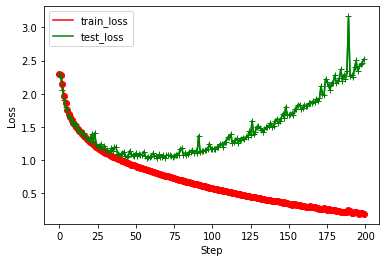

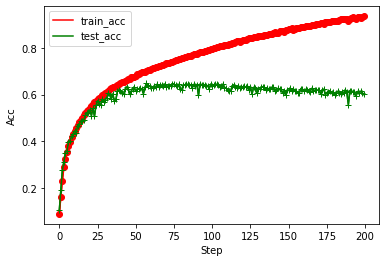

In [13]:
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

随着 epoch 的增加，train loss 不断减小，但是 test loss 先是减小然后又增加了，大约 60 轮训练效果最好，60 轮之前是欠拟合，60 轮之后就过拟合了。

## Tuning

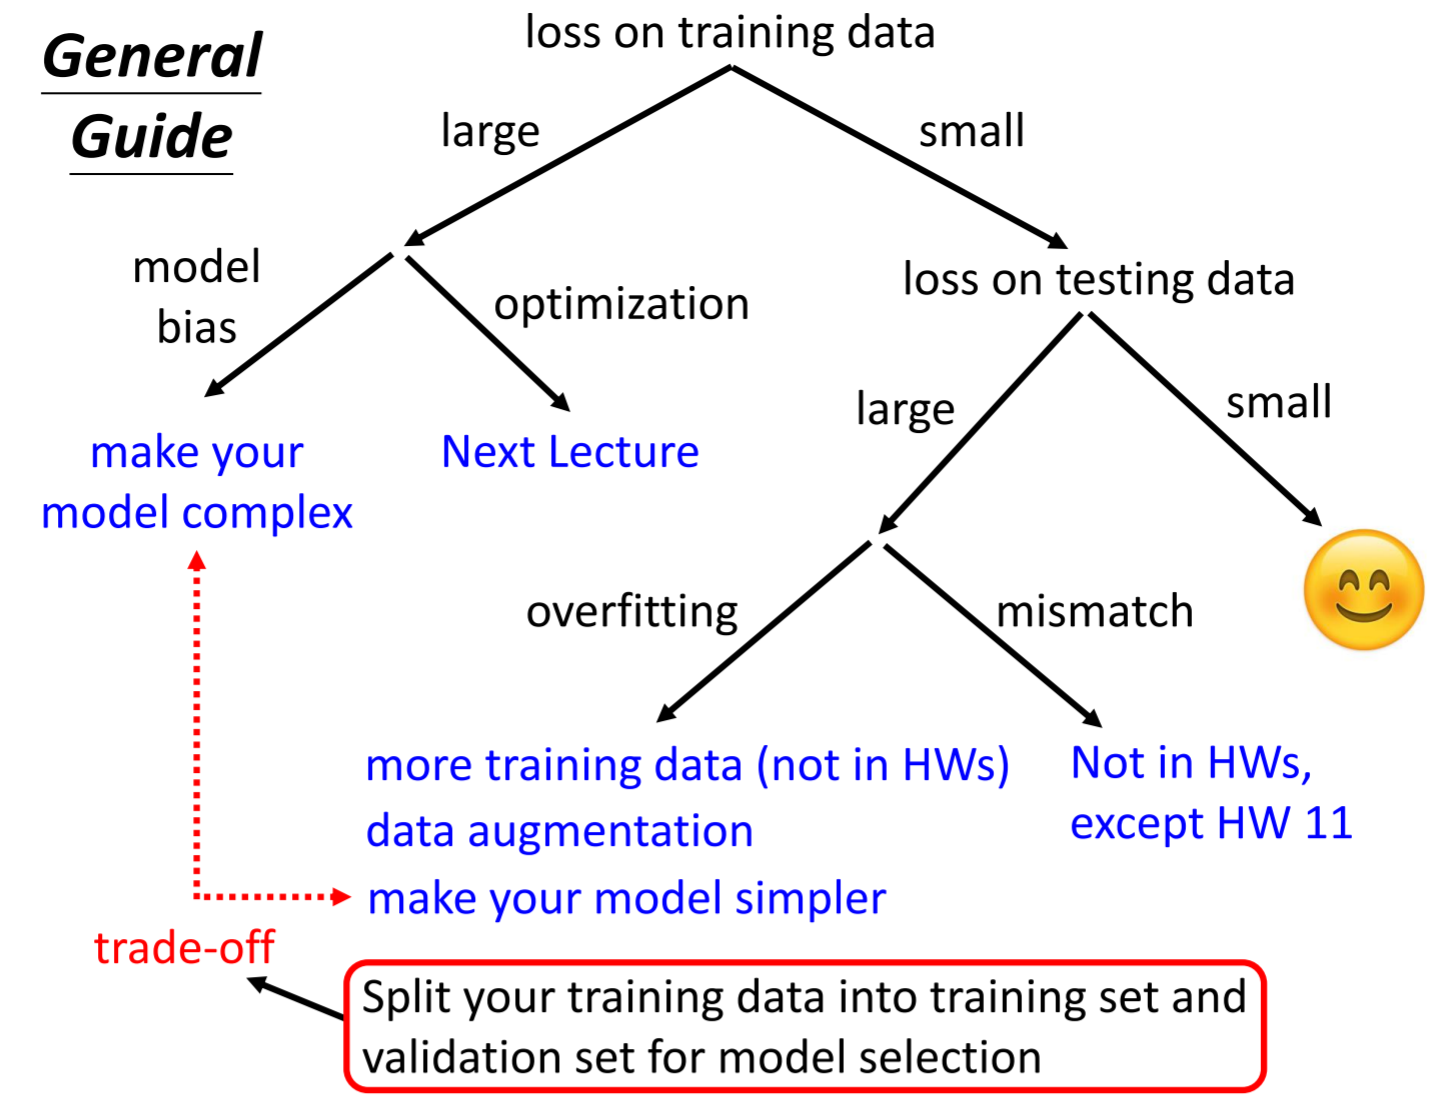

### 1. Learning rate

初始学习率设置为很小的一个值（1e-5），然后每一步指数增大学习率（扩大 1.05 倍）进行训练。

In [14]:
LOG_PATH="./train1.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
    
model = Net()
if AVAIL_GPUS:
    model = model.cuda()

BATCH_SIZE = 128
LEARNING_RATE = 1e-5
NUM_EPOCHS = 236  # 1.05**236*1e-5 = 1.002
print("Model: CNN from Pytorch tutorial")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: SGD")
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: SGD")
    f.write("\n")
    f.write("Learning rate: %d" % (LEARNING_RATE))
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
    print("Learning rate: %f" % (LEARNING_RATE))
    with open(LOG_PATH, "a") as f:
        f.write("Learning rate: %f" % (LEARNING_RATE))
        f.write("\n")
        
    train(i)
    test(i)
    
    LEARNING_RATE = LEARNING_RATE * 1.05
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: CNN from Pytorch tutorial
Batch size: 128
Epoch num: 236
Optimizer: SGD
---------- Training Epoch #0 ----------
Learning rate: 0.000010


391it [00:03, 128.08it/s]

Finish 1 epoch, Train loss: 2.305340, Train acc@1: 0.094700


Test loss: 2.305389, Test acc@1: 0.095500
Saving Best model...			Top1 = 9.550000%
Elapsed time: 6.267945766448975
---------- Training Epoch #1 ----------
Learning rate: 0.000011


391it [00:03, 121.08it/s]

Finish 2 epoch, Train loss: 2.305334, Train acc@1: 0.094700


Test loss: 2.305383, Test acc@1: 0.095500
Elapsed time: 11.408700466156006
---------- Training Epoch #2 ----------
Learning rate: 0.000011


391it [00:03, 122.11it/s]

Finish 3 epoch, Train loss: 2.305328, Train acc@1: 0.094720


Test loss: 2.305376, Test acc@1: 0.095500
Elapsed time: 16.53430438041687
---------- Training Epoch #3 ----------
Learning rate: 0.000012


391it [00:03, 121.64it/s]

Finish 4 epoch, Train loss: 2.305322, Train acc@1: 0.094760


Test loss: 2.305370, Test acc@1: 0.095500
Elapsed time: 21.54304575920105
---------- Training Epoch #4 ----------
Learning rate: 0.000012


391it [00:03, 124.31it/s]

Finish 5 epoch, Train loss: 2.305315, Train acc@1: 0.094700


Test loss: 2.305362, Test acc@1: 0.095500
Elapsed time: 26.55420446395874
---------- Training Epoch #5 ----------
Learning rate: 0.000013


391it [00:03, 123.89it/s]

Finish 6 epoch, Train loss: 2.305308, Train acc@1: 0.094700


Test loss: 2.305355, Test acc@1: 0.095500
Elapsed time: 31.5527286529541
---------- Training Epoch #6 ----------
Learning rate: 0.000013


391it [00:03, 125.01it/s]

Finish 7 epoch, Train loss: 2.305300, Train acc@1: 0.094740


Test loss: 2.305347, Test acc@1: 0.095600
Saving Best model...			Top1 = 9.560000%
Elapsed time: 36.591593503952026
---------- Training Epoch #7 ----------
Learning rate: 0.000014


391it [00:03, 124.17it/s]

Finish 8 epoch, Train loss: 2.305292, Train acc@1: 0.094720


Test loss: 2.305339, Test acc@1: 0.095600
Elapsed time: 41.533092975616455
---------- Training Epoch #8 ----------
Learning rate: 0.000015


391it [00:03, 124.08it/s]

Finish 9 epoch, Train loss: 2.305284, Train acc@1: 0.094720


Test loss: 2.305331, Test acc@1: 0.095500
Elapsed time: 46.611252307891846
---------- Training Epoch #9 ----------
Learning rate: 0.000016


391it [00:03, 128.30it/s]

Finish 10 epoch, Train loss: 2.305276, Train acc@1: 0.094720


Test loss: 2.305322, Test acc@1: 0.095500
Elapsed time: 51.494874000549316
---------- Training Epoch #10 ----------
Learning rate: 0.000016


391it [00:03, 125.37it/s]

Finish 11 epoch, Train loss: 2.305267, Train acc@1: 0.094760


Test loss: 2.305313, Test acc@1: 0.095600
Elapsed time: 56.52040433883667
---------- Training Epoch #11 ----------
Learning rate: 0.000017


391it [00:03, 124.96it/s]

Finish 12 epoch, Train loss: 2.305257, Train acc@1: 0.094760


Test loss: 2.305303, Test acc@1: 0.095500
Elapsed time: 61.499528884887695
---------- Training Epoch #12 ----------
Learning rate: 0.000018


391it [00:03, 123.42it/s]

Finish 13 epoch, Train loss: 2.305247, Train acc@1: 0.094840


Test loss: 2.305293, Test acc@1: 0.095600
Elapsed time: 66.65440011024475
---------- Training Epoch #13 ----------
Learning rate: 0.000019


391it [00:03, 125.39it/s]

Finish 14 epoch, Train loss: 2.305237, Train acc@1: 0.094860


Test loss: 2.305282, Test acc@1: 0.095600
Elapsed time: 71.72919487953186
---------- Training Epoch #14 ----------
Learning rate: 0.000020


391it [00:03, 123.88it/s]


Finish 15 epoch, Train loss: 2.305226, Train acc@1: 0.094880
Test loss: 2.305271, Test acc@1: 0.095600
Elapsed time: 76.80840849876404
---------- Training Epoch #15 ----------
Learning rate: 0.000021


391it [00:03, 125.52it/s]

Finish 16 epoch, Train loss: 2.305215, Train acc@1: 0.094900


Test loss: 2.305259, Test acc@1: 0.095600
Elapsed time: 81.75564694404602
---------- Training Epoch #16 ----------
Learning rate: 0.000022


391it [00:03, 122.28it/s]

Finish 17 epoch, Train loss: 2.305203, Train acc@1: 0.094900


Test loss: 2.305247, Test acc@1: 0.095600
Elapsed time: 86.85467839241028
---------- Training Epoch #17 ----------
Learning rate: 0.000023


391it [00:03, 125.63it/s]

Finish 18 epoch, Train loss: 2.305190, Train acc@1: 0.094920


Test loss: 2.305234, Test acc@1: 0.095700
Saving Best model...			Top1 = 9.570000%
Elapsed time: 92.00533723831177
---------- Training Epoch #18 ----------
Learning rate: 0.000024


391it [00:03, 128.18it/s]

Finish 19 epoch, Train loss: 2.305177, Train acc@1: 0.094940


Test loss: 2.305221, Test acc@1: 0.095700
Elapsed time: 96.92374730110168
---------- Training Epoch #19 ----------
Learning rate: 0.000025


391it [00:03, 124.10it/s]

Finish 20 epoch, Train loss: 2.305164, Train acc@1: 0.094960


Test loss: 2.305206, Test acc@1: 0.095700
Elapsed time: 101.9779417514801
---------- Training Epoch #20 ----------
Learning rate: 0.000027


391it [00:03, 121.00it/s]

Finish 21 epoch, Train loss: 2.305149, Train acc@1: 0.095020


Test loss: 2.305192, Test acc@1: 0.095700
Elapsed time: 107.05294799804688
---------- Training Epoch #21 ----------
Learning rate: 0.000028


391it [00:03, 122.36it/s]

Finish 22 epoch, Train loss: 2.305134, Train acc@1: 0.095020


Test loss: 2.305176, Test acc@1: 0.095700
Elapsed time: 112.09608364105225
---------- Training Epoch #22 ----------
Learning rate: 0.000029


391it [00:03, 119.19it/s]

Finish 23 epoch, Train loss: 2.305118, Train acc@1: 0.094920


Test loss: 2.305160, Test acc@1: 0.095700
Elapsed time: 117.30974555015564
---------- Training Epoch #23 ----------
Learning rate: 0.000031


391it [00:03, 124.95it/s]

Finish 24 epoch, Train loss: 2.305102, Train acc@1: 0.094940


Test loss: 2.305143, Test acc@1: 0.095700
Elapsed time: 122.3874979019165
---------- Training Epoch #24 ----------
Learning rate: 0.000032


391it [00:03, 116.00it/s]

Finish 25 epoch, Train loss: 2.305085, Train acc@1: 0.094960


Test loss: 2.305125, Test acc@1: 0.095700
Elapsed time: 127.57873368263245
---------- Training Epoch #25 ----------
Learning rate: 0.000034


391it [00:03, 124.65it/s]

Finish 26 epoch, Train loss: 2.305067, Train acc@1: 0.094940


Test loss: 2.305107, Test acc@1: 0.095700
Elapsed time: 132.55768084526062
---------- Training Epoch #26 ----------
Learning rate: 0.000036


391it [00:03, 120.43it/s]

Finish 27 epoch, Train loss: 2.305048, Train acc@1: 0.094960


Test loss: 2.305087, Test acc@1: 0.095700
Elapsed time: 137.71829223632812
---------- Training Epoch #27 ----------
Learning rate: 0.000037


391it [00:03, 125.26it/s]

Finish 28 epoch, Train loss: 2.305029, Train acc@1: 0.095040


Test loss: 2.305067, Test acc@1: 0.095700
Elapsed time: 142.74507927894592
---------- Training Epoch #28 ----------
Learning rate: 0.000039


391it [00:03, 127.32it/s]

Finish 29 epoch, Train loss: 2.305008, Train acc@1: 0.095040


Test loss: 2.305046, Test acc@1: 0.095800
Saving Best model...			Top1 = 9.580000%
Elapsed time: 147.7219877243042
---------- Training Epoch #29 ----------
Learning rate: 0.000041


391it [00:03, 121.08it/s]

Finish 30 epoch, Train loss: 2.304986, Train acc@1: 0.095020


Test loss: 2.305024, Test acc@1: 0.095800
Elapsed time: 152.80532479286194
---------- Training Epoch #30 ----------
Learning rate: 0.000043


391it [00:03, 118.50it/s]


Finish 31 epoch, Train loss: 2.304964, Train acc@1: 0.095000
Test loss: 2.305001, Test acc@1: 0.095800
Elapsed time: 157.97196054458618
---------- Training Epoch #31 ----------
Learning rate: 0.000045


391it [00:03, 120.57it/s]

Finish 32 epoch, Train loss: 2.304941, Train acc@1: 0.095100


Test loss: 2.304977, Test acc@1: 0.095900
Saving Best model...			Top1 = 9.590000%
Elapsed time: 163.09963750839233
---------- Training Epoch #32 ----------
Learning rate: 0.000048


391it [00:03, 118.84it/s]

Finish 33 epoch, Train loss: 2.304916, Train acc@1: 0.095040


Test loss: 2.304951, Test acc@1: 0.095900
Elapsed time: 168.22619795799255
---------- Training Epoch #33 ----------
Learning rate: 0.000050


391it [00:03, 119.34it/s]

Finish 34 epoch, Train loss: 2.304891, Train acc@1: 0.095000


Test loss: 2.304925, Test acc@1: 0.095900
Elapsed time: 173.33720135688782
---------- Training Epoch #34 ----------
Learning rate: 0.000053


391it [00:03, 120.38it/s]

Finish 35 epoch, Train loss: 2.304864, Train acc@1: 0.095000


Test loss: 2.304897, Test acc@1: 0.095800
Elapsed time: 178.4836461544037
---------- Training Epoch #35 ----------
Learning rate: 0.000055


391it [00:03, 121.46it/s]

Finish 36 epoch, Train loss: 2.304836, Train acc@1: 0.095000


Test loss: 2.304869, Test acc@1: 0.095800
Elapsed time: 183.6031014919281
---------- Training Epoch #36 ----------
Learning rate: 0.000058


391it [00:03, 121.35it/s]

Finish 37 epoch, Train loss: 2.304807, Train acc@1: 0.095140


Test loss: 2.304839, Test acc@1: 0.095900
Elapsed time: 188.7090344429016
---------- Training Epoch #37 ----------
Learning rate: 0.000061


391it [00:03, 122.14it/s]


Finish 38 epoch, Train loss: 2.304777, Train acc@1: 0.095140
Test loss: 2.304808, Test acc@1: 0.096100
Saving Best model...			Top1 = 9.610000%
Elapsed time: 193.8169343471527
---------- Training Epoch #38 ----------
Learning rate: 0.000064


391it [00:03, 121.07it/s]

Finish 39 epoch, Train loss: 2.304745, Train acc@1: 0.095220


Test loss: 2.304776, Test acc@1: 0.096100
Elapsed time: 198.93333625793457
---------- Training Epoch #39 ----------
Learning rate: 0.000067


391it [00:03, 120.90it/s]

Finish 40 epoch, Train loss: 2.304712, Train acc@1: 0.095220


Test loss: 2.304742, Test acc@1: 0.096200
Saving Best model...			Top1 = 9.620000%
Elapsed time: 203.99181485176086
---------- Training Epoch #40 ----------
Learning rate: 0.000070


391it [00:03, 125.62it/s]

Finish 41 epoch, Train loss: 2.304678, Train acc@1: 0.095140


Test loss: 2.304706, Test acc@1: 0.096300
Saving Best model...			Top1 = 9.630000%
Elapsed time: 208.9700047969818
---------- Training Epoch #41 ----------
Learning rate: 0.000074


391it [00:03, 121.94it/s]

Finish 42 epoch, Train loss: 2.304642, Train acc@1: 0.095300


Test loss: 2.304670, Test acc@1: 0.096500
Saving Best model...			Top1 = 9.650000%
Elapsed time: 214.05473279953003
---------- Training Epoch #42 ----------
Learning rate: 0.000078


391it [00:03, 123.12it/s]

Finish 43 epoch, Train loss: 2.304605, Train acc@1: 0.095380


Test loss: 2.304632, Test acc@1: 0.096600
Saving Best model...			Top1 = 9.660000%
Elapsed time: 219.04531598091125
---------- Training Epoch #43 ----------
Learning rate: 0.000081


391it [00:03, 124.10it/s]


Finish 44 epoch, Train loss: 2.304567, Train acc@1: 0.095500
Test loss: 2.304592, Test acc@1: 0.096500
Elapsed time: 224.0781123638153
---------- Training Epoch #44 ----------
Learning rate: 0.000086


391it [00:03, 123.00it/s]

Finish 45 epoch, Train loss: 2.304526, Train acc@1: 0.095620


Test loss: 2.304550, Test acc@1: 0.096200
Elapsed time: 229.2131769657135
---------- Training Epoch #45 ----------
Learning rate: 0.000090


391it [00:03, 127.83it/s]

Finish 46 epoch, Train loss: 2.304485, Train acc@1: 0.095680


Test loss: 2.304507, Test acc@1: 0.095900
Elapsed time: 234.14773511886597
---------- Training Epoch #46 ----------
Learning rate: 0.000094


391it [00:03, 123.94it/s]

Finish 47 epoch, Train loss: 2.304441, Train acc@1: 0.095720


Test loss: 2.304462, Test acc@1: 0.095800
Elapsed time: 239.1609480381012
---------- Training Epoch #47 ----------
Learning rate: 0.000099


391it [00:03, 123.22it/s]

Finish 48 epoch, Train loss: 2.304396, Train acc@1: 0.095800


Test loss: 2.304416, Test acc@1: 0.096000
Elapsed time: 244.2124788761139
---------- Training Epoch #48 ----------
Learning rate: 0.000104


391it [00:03, 124.94it/s]

Finish 49 epoch, Train loss: 2.304349, Train acc@1: 0.095940


Test loss: 2.304368, Test acc@1: 0.096000
Elapsed time: 249.17728924751282
---------- Training Epoch #49 ----------
Learning rate: 0.000109


391it [00:03, 119.60it/s]

Finish 50 epoch, Train loss: 2.304300, Train acc@1: 0.096040


Test loss: 2.304317, Test acc@1: 0.096100
Elapsed time: 254.33936190605164
---------- Training Epoch #50 ----------
Learning rate: 0.000115


391it [00:03, 125.96it/s]

Finish 51 epoch, Train loss: 2.304249, Train acc@1: 0.096000


Test loss: 2.304266, Test acc@1: 0.096200
Elapsed time: 259.28572821617126
---------- Training Epoch #51 ----------
Learning rate: 0.000120


391it [00:03, 124.27it/s]

Finish 52 epoch, Train loss: 2.304197, Train acc@1: 0.096160


Test loss: 2.304212, Test acc@1: 0.096400
Elapsed time: 264.27392411231995
---------- Training Epoch #52 ----------
Learning rate: 0.000126


391it [00:03, 122.29it/s]

Finish 53 epoch, Train loss: 2.304142, Train acc@1: 0.096240


Test loss: 2.304156, Test acc@1: 0.096700
Saving Best model...			Top1 = 9.670000%
Elapsed time: 269.35346603393555
---------- Training Epoch #53 ----------
Learning rate: 0.000133


391it [00:03, 124.64it/s]

Finish 54 epoch, Train loss: 2.304085, Train acc@1: 0.096320


Test loss: 2.304097, Test acc@1: 0.096600
Elapsed time: 274.4726481437683
---------- Training Epoch #54 ----------
Learning rate: 0.000139


391it [00:03, 121.07it/s]

Finish 55 epoch, Train loss: 2.304026, Train acc@1: 0.096520


Test loss: 2.304037, Test acc@1: 0.096700
Elapsed time: 279.58215165138245
---------- Training Epoch #55 ----------
Learning rate: 0.000146


391it [00:03, 125.28it/s]

Finish 56 epoch, Train loss: 2.303965, Train acc@1: 0.096620


Test loss: 2.303974, Test acc@1: 0.097100
Saving Best model...			Top1 = 9.710000%
Elapsed time: 284.59754395484924
---------- Training Epoch #56 ----------
Learning rate: 0.000154


391it [00:02, 132.37it/s]


Finish 57 epoch, Train loss: 2.303902, Train acc@1: 0.096800
Test loss: 2.303910, Test acc@1: 0.097400
Saving Best model...			Top1 = 9.740000%
Elapsed time: 289.4294104576111
---------- Training Epoch #57 ----------
Learning rate: 0.000161


391it [00:03, 120.94it/s]

Finish 58 epoch, Train loss: 2.303837, Train acc@1: 0.096800


Test loss: 2.303843, Test acc@1: 0.097200
Elapsed time: 294.5519711971283
---------- Training Epoch #58 ----------
Learning rate: 0.000169


391it [00:03, 125.76it/s]

Finish 59 epoch, Train loss: 2.303769, Train acc@1: 0.097020


Test loss: 2.303774, Test acc@1: 0.097700
Saving Best model...			Top1 = 9.770000%
Elapsed time: 299.55966901779175
---------- Training Epoch #59 ----------
Learning rate: 0.000178


391it [00:03, 127.95it/s]

Finish 60 epoch, Train loss: 2.303699, Train acc@1: 0.097240


Test loss: 2.303702, Test acc@1: 0.097900
Saving Best model...			Top1 = 9.790000%
Elapsed time: 304.4298858642578
---------- Training Epoch #60 ----------
Learning rate: 0.000187


391it [00:03, 121.52it/s]

Finish 61 epoch, Train loss: 2.303626, Train acc@1: 0.097360


Test loss: 2.303627, Test acc@1: 0.098500
Saving Best model...			Top1 = 9.850000%
Elapsed time: 309.6116406917572
---------- Training Epoch #61 ----------
Learning rate: 0.000196


391it [00:03, 126.48it/s]

Finish 62 epoch, Train loss: 2.303551, Train acc@1: 0.097760


Test loss: 2.303551, Test acc@1: 0.098400
Elapsed time: 314.6322772502899
---------- Training Epoch #62 ----------
Learning rate: 0.000206


391it [00:03, 124.41it/s]

Finish 63 epoch, Train loss: 2.303473, Train acc@1: 0.097960


Test loss: 2.303471, Test acc@1: 0.098900
Saving Best model...			Top1 = 9.890000%
Elapsed time: 319.6861448287964
---------- Training Epoch #63 ----------
Learning rate: 0.000216


391it [00:03, 129.01it/s]

Finish 64 epoch, Train loss: 2.303392, Train acc@1: 0.098280


Test loss: 2.303389, Test acc@1: 0.099500
Saving Best model...			Top1 = 9.950000%
Elapsed time: 324.60863065719604
---------- Training Epoch #64 ----------
Learning rate: 0.000227


391it [00:03, 129.13it/s]

Finish 65 epoch, Train loss: 2.303308, Train acc@1: 0.098620


Test loss: 2.303304, Test acc@1: 0.100300
Saving Best model...			Top1 = 10.030000%
Elapsed time: 329.56679344177246
---------- Training Epoch #65 ----------
Learning rate: 0.000238


391it [00:03, 121.54it/s]

Finish 66 epoch, Train loss: 2.303222, Train acc@1: 0.098900


Test loss: 2.303216, Test acc@1: 0.100800
Saving Best model...			Top1 = 10.080000%
Elapsed time: 334.6432363986969
---------- Training Epoch #66 ----------
Learning rate: 0.000250


391it [00:03, 128.09it/s]

Finish 67 epoch, Train loss: 2.303132, Train acc@1: 0.099280


Test loss: 2.303125, Test acc@1: 0.101000
Saving Best model...			Top1 = 10.100000%
Elapsed time: 339.5695753097534
---------- Training Epoch #67 ----------
Learning rate: 0.000263


391it [00:03, 126.72it/s]

Finish 68 epoch, Train loss: 2.303040, Train acc@1: 0.099900


Test loss: 2.303031, Test acc@1: 0.101600
Saving Best model...			Top1 = 10.160000%
Elapsed time: 344.60628271102905
---------- Training Epoch #68 ----------
Learning rate: 0.000276


391it [00:03, 126.09it/s]

Finish 69 epoch, Train loss: 2.302944, Train acc@1: 0.100240


Test loss: 2.302933, Test acc@1: 0.101800
Saving Best model...			Top1 = 10.180000%
Elapsed time: 349.6397514343262
---------- Training Epoch #69 ----------
Learning rate: 0.000290


391it [00:03, 126.05it/s]

Finish 70 epoch, Train loss: 2.302845, Train acc@1: 0.100840


Test loss: 2.302832, Test acc@1: 0.101700
Elapsed time: 354.6100571155548
---------- Training Epoch #70 ----------
Learning rate: 0.000304


391it [00:03, 122.22it/s]

Finish 71 epoch, Train loss: 2.302742, Train acc@1: 0.101220


Test loss: 2.302728, Test acc@1: 0.101900
Saving Best model...			Top1 = 10.190000%
Elapsed time: 359.7068693637848
---------- Training Epoch #71 ----------
Learning rate: 0.000319


391it [00:03, 124.47it/s]

Finish 72 epoch, Train loss: 2.302635, Train acc@1: 0.101760


Test loss: 2.302619, Test acc@1: 0.102600
Saving Best model...			Top1 = 10.260000%
Elapsed time: 364.65596747398376
---------- Training Epoch #72 ----------
Learning rate: 0.000335


391it [00:03, 119.23it/s]

Finish 73 epoch, Train loss: 2.302524, Train acc@1: 0.102320


Test loss: 2.302506, Test acc@1: 0.103100
Saving Best model...			Top1 = 10.310000%
Elapsed time: 369.8214440345764
---------- Training Epoch #73 ----------
Learning rate: 0.000352


391it [00:03, 124.88it/s]

Finish 74 epoch, Train loss: 2.302409, Train acc@1: 0.103320


Test loss: 2.302388, Test acc@1: 0.103900
Saving Best model...			Top1 = 10.390000%
Elapsed time: 374.9042718410492
---------- Training Epoch #74 ----------
Learning rate: 0.000370


391it [00:03, 126.61it/s]

Finish 75 epoch, Train loss: 2.302288, Train acc@1: 0.103940


Test loss: 2.302265, Test acc@1: 0.104700
Saving Best model...			Top1 = 10.470000%
Elapsed time: 379.90088272094727
---------- Training Epoch #75 ----------
Learning rate: 0.000388


391it [00:03, 128.73it/s]

Finish 76 epoch, Train loss: 2.302163, Train acc@1: 0.104520


Test loss: 2.302138, Test acc@1: 0.105800
Saving Best model...			Top1 = 10.580000%
Elapsed time: 384.8644642829895
---------- Training Epoch #76 ----------
Learning rate: 0.000408


391it [00:03, 129.09it/s]

Finish 77 epoch, Train loss: 2.302032, Train acc@1: 0.105260


Test loss: 2.302005, Test acc@1: 0.106700
Saving Best model...			Top1 = 10.670000%
Elapsed time: 389.83061385154724
---------- Training Epoch #77 ----------
Learning rate: 0.000428


391it [00:03, 126.94it/s]

Finish 78 epoch, Train loss: 2.301894, Train acc@1: 0.106540


Test loss: 2.301864, Test acc@1: 0.107700
Saving Best model...			Top1 = 10.770000%
Elapsed time: 394.79949045181274
---------- Training Epoch #78 ----------
Learning rate: 0.000450


391it [00:03, 125.36it/s]

Finish 79 epoch, Train loss: 2.301750, Train acc@1: 0.107960


Test loss: 2.301717, Test acc@1: 0.109500
Saving Best model...			Top1 = 10.950000%
Elapsed time: 399.8513729572296
---------- Training Epoch #79 ----------
Learning rate: 0.000472


391it [00:03, 125.07it/s]

Finish 80 epoch, Train loss: 2.301598, Train acc@1: 0.109060


Test loss: 2.301562, Test acc@1: 0.110700
Saving Best model...			Top1 = 11.070000%
Elapsed time: 404.9016869068146
---------- Training Epoch #80 ----------
Learning rate: 0.000496


391it [00:03, 126.33it/s]

Finish 81 epoch, Train loss: 2.301438, Train acc@1: 0.110140


Test loss: 2.301398, Test acc@1: 0.111400
Saving Best model...			Top1 = 11.140000%
Elapsed time: 409.91300082206726
---------- Training Epoch #81 ----------
Learning rate: 0.000520


391it [00:03, 122.17it/s]

Finish 82 epoch, Train loss: 2.301268, Train acc@1: 0.112060


Test loss: 2.301224, Test acc@1: 0.113300
Saving Best model...			Top1 = 11.330000%
Elapsed time: 415.0203368663788
---------- Training Epoch #82 ----------
Learning rate: 0.000546


391it [00:03, 127.30it/s]

Finish 83 epoch, Train loss: 2.301087, Train acc@1: 0.114540


Test loss: 2.301039, Test acc@1: 0.116100
Saving Best model...			Top1 = 11.610000%
Elapsed time: 419.94240283966064
---------- Training Epoch #83 ----------
Learning rate: 0.000574


391it [00:03, 126.62it/s]

Finish 84 epoch, Train loss: 2.300893, Train acc@1: 0.116840


Test loss: 2.300839, Test acc@1: 0.118600
Saving Best model...			Top1 = 11.860000%
Elapsed time: 424.84094882011414
---------- Training Epoch #84 ----------
Learning rate: 0.000602


391it [00:03, 128.22it/s]

Finish 85 epoch, Train loss: 2.300685, Train acc@1: 0.118100


Test loss: 2.300623, Test acc@1: 0.121100
Saving Best model...			Top1 = 12.110000%
Elapsed time: 429.7729706764221
---------- Training Epoch #85 ----------
Learning rate: 0.000633


391it [00:03, 127.44it/s]

Finish 86 epoch, Train loss: 2.300459, Train acc@1: 0.122180


Test loss: 2.300387, Test acc@1: 0.124000
Saving Best model...			Top1 = 12.400000%
Elapsed time: 434.75931453704834
---------- Training Epoch #86 ----------
Learning rate: 0.000664


391it [00:03, 126.42it/s]

Finish 87 epoch, Train loss: 2.300211, Train acc@1: 0.125540


Test loss: 2.300127, Test acc@1: 0.126600
Saving Best model...			Top1 = 12.660000%
Elapsed time: 439.71151185035706
---------- Training Epoch #87 ----------
Learning rate: 0.000697


391it [00:03, 125.11it/s]

Finish 88 epoch, Train loss: 2.299939, Train acc@1: 0.129560


Test loss: 2.299840, Test acc@1: 0.131600
Saving Best model...			Top1 = 13.160000%
Elapsed time: 444.7484965324402
---------- Training Epoch #88 ----------
Learning rate: 0.000732


391it [00:03, 126.83it/s]

Finish 89 epoch, Train loss: 2.299636, Train acc@1: 0.134220


Test loss: 2.299517, Test acc@1: 0.135400
Saving Best model...			Top1 = 13.540000%
Elapsed time: 449.70653533935547
---------- Training Epoch #89 ----------
Learning rate: 0.000769


391it [00:03, 124.34it/s]

Finish 90 epoch, Train loss: 2.299294, Train acc@1: 0.138360


Test loss: 2.299152, Test acc@1: 0.141700
Saving Best model...			Top1 = 14.170000%
Elapsed time: 454.74119901657104
---------- Training Epoch #90 ----------
Learning rate: 0.000807


391it [00:03, 125.58it/s]

Finish 91 epoch, Train loss: 2.298905, Train acc@1: 0.143200


Test loss: 2.298731, Test acc@1: 0.146200
Saving Best model...			Top1 = 14.620000%
Elapsed time: 459.7313029766083
---------- Training Epoch #91 ----------
Learning rate: 0.000848


391it [00:03, 124.36it/s]

Finish 92 epoch, Train loss: 2.298455, Train acc@1: 0.146700


Test loss: 2.298240, Test acc@1: 0.149400
Saving Best model...			Top1 = 14.940000%
Elapsed time: 464.8116784095764
---------- Training Epoch #92 ----------
Learning rate: 0.000890


391it [00:03, 126.25it/s]

Finish 93 epoch, Train loss: 2.297928, Train acc@1: 0.149800


Test loss: 2.297660, Test acc@1: 0.154000
Saving Best model...			Top1 = 15.400000%
Elapsed time: 469.7578692436218
---------- Training Epoch #93 ----------
Learning rate: 0.000935


391it [00:03, 128.75it/s]

Finish 94 epoch, Train loss: 2.297301, Train acc@1: 0.152960


Test loss: 2.296962, Test acc@1: 0.157000
Saving Best model...			Top1 = 15.700000%
Elapsed time: 474.6558120250702
---------- Training Epoch #94 ----------
Learning rate: 0.000981


391it [00:03, 128.86it/s]

Finish 95 epoch, Train loss: 2.296541, Train acc@1: 0.156600


Test loss: 2.296108, Test acc@1: 0.161400
Saving Best model...			Top1 = 16.140000%
Elapsed time: 479.67945098876953
---------- Training Epoch #95 ----------
Learning rate: 0.001030


391it [00:03, 123.41it/s]

Finish 96 epoch, Train loss: 2.295595, Train acc@1: 0.160080


Test loss: 2.295040, Test acc@1: 0.167300
Saving Best model...			Top1 = 16.730000%
Elapsed time: 484.77958130836487
---------- Training Epoch #96 ----------
Learning rate: 0.001082


391it [00:03, 126.43it/s]

Finish 97 epoch, Train loss: 2.294402, Train acc@1: 0.166420


Test loss: 2.293677, Test acc@1: 0.173800
Saving Best model...			Top1 = 17.380000%
Elapsed time: 489.72926807403564
---------- Training Epoch #97 ----------
Learning rate: 0.001136


391it [00:03, 129.59it/s]

Finish 98 epoch, Train loss: 2.292874, Train acc@1: 0.174260


Test loss: 2.291915, Test acc@1: 0.183800
Saving Best model...			Top1 = 18.380000%
Elapsed time: 494.67301988601685
---------- Training Epoch #98 ----------
Learning rate: 0.001193


391it [00:03, 126.58it/s]

Finish 99 epoch, Train loss: 2.290891, Train acc@1: 0.183480


Test loss: 2.289607, Test acc@1: 0.188200
Saving Best model...			Top1 = 18.820000%
Elapsed time: 499.691401720047
---------- Training Epoch #99 ----------
Learning rate: 0.001252


391it [00:03, 126.61it/s]

Finish 100 epoch, Train loss: 2.288262, Train acc@1: 0.190160


Test loss: 2.286507, Test acc@1: 0.192500
Saving Best model...			Top1 = 19.250000%
Elapsed time: 504.70045733451843
---------- Training Epoch #100 ----------
Learning rate: 0.001315


391it [00:03, 127.34it/s]

Finish 101 epoch, Train loss: 2.284666, Train acc@1: 0.193560


Test loss: 2.282194, Test acc@1: 0.195500
Saving Best model...			Top1 = 19.550000%
Elapsed time: 509.7614870071411
---------- Training Epoch #101 ----------
Learning rate: 0.001381


391it [00:03, 124.07it/s]

Finish 102 epoch, Train loss: 2.279574, Train acc@1: 0.195640


Test loss: 2.275972, Test acc@1: 0.196300
Saving Best model...			Top1 = 19.630000%
Elapsed time: 514.8586187362671
---------- Training Epoch #102 ----------
Learning rate: 0.001450


391it [00:03, 126.15it/s]

Finish 103 epoch, Train loss: 2.272097, Train acc@1: 0.194540


Test loss: 2.266671, Test acc@1: 0.197100
Saving Best model...			Top1 = 19.710000%
Elapsed time: 519.8666849136353
---------- Training Epoch #103 ----------
Learning rate: 0.001522


391it [00:03, 127.75it/s]

Finish 104 epoch, Train loss: 2.260560, Train acc@1: 0.192820


Test loss: 2.251861, Test acc@1: 0.193400
Elapsed time: 524.919816493988
---------- Training Epoch #104 ----------
Learning rate: 0.001598


391it [00:03, 127.19it/s]

Finish 105 epoch, Train loss: 2.241755, Train acc@1: 0.189400


Test loss: 2.227172, Test acc@1: 0.191000
Elapsed time: 529.8737621307373
---------- Training Epoch #105 ----------
Learning rate: 0.001678


391it [00:03, 128.16it/s]

Finish 106 epoch, Train loss: 2.210905, Train acc@1: 0.188040


Test loss: 2.187867, Test acc@1: 0.191100
Elapsed time: 534.8588860034943
---------- Training Epoch #106 ----------
Learning rate: 0.001762


391it [00:03, 126.99it/s]

Finish 107 epoch, Train loss: 2.166881, Train acc@1: 0.193240


Test loss: 2.138255, Test acc@1: 0.201300
Saving Best model...			Top1 = 20.130000%
Elapsed time: 539.7846367359161
---------- Training Epoch #107 ----------
Learning rate: 0.001850


391it [00:03, 126.24it/s]

Finish 108 epoch, Train loss: 2.117782, Train acc@1: 0.211560


Test loss: 2.088733, Test acc@1: 0.228700
Saving Best model...			Top1 = 22.870000%
Elapsed time: 544.7611198425293
---------- Training Epoch #108 ----------
Learning rate: 0.001943


391it [00:03, 129.70it/s]

Finish 109 epoch, Train loss: 2.071703, Train acc@1: 0.236520


Test loss: 2.047238, Test acc@1: 0.257000
Saving Best model...			Top1 = 25.700000%
Elapsed time: 549.6151061058044
---------- Training Epoch #109 ----------
Learning rate: 0.002040


391it [00:03, 129.96it/s]

Finish 110 epoch, Train loss: 2.036035, Train acc@1: 0.253260


Test loss: 2.016191, Test acc@1: 0.259700
Saving Best model...			Top1 = 25.970000%
Elapsed time: 554.6202125549316
---------- Training Epoch #110 ----------
Learning rate: 0.002142


391it [00:03, 115.96it/s]

Finish 111 epoch, Train loss: 2.008189, Train acc@1: 0.260520


Test loss: 1.989623, Test acc@1: 0.270300
Saving Best model...			Top1 = 27.030000%
Elapsed time: 559.9089586734772
---------- Training Epoch #111 ----------
Learning rate: 0.002249


391it [00:03, 123.94it/s]

Finish 112 epoch, Train loss: 1.983229, Train acc@1: 0.268200


Test loss: 1.964799, Test acc@1: 0.278900
Saving Best model...			Top1 = 27.890000%
Elapsed time: 564.9835734367371
---------- Training Epoch #112 ----------
Learning rate: 0.002362


391it [00:03, 128.19it/s]

Finish 113 epoch, Train loss: 1.959564, Train acc@1: 0.276400


Test loss: 1.941256, Test acc@1: 0.287200
Saving Best model...			Top1 = 28.720000%
Elapsed time: 570.018874168396
---------- Training Epoch #113 ----------
Learning rate: 0.002480


391it [00:03, 126.00it/s]

Finish 114 epoch, Train loss: 1.936531, Train acc@1: 0.284600


Test loss: 1.919489, Test acc@1: 0.295600
Saving Best model...			Top1 = 29.560000%
Elapsed time: 575.0321233272552
---------- Training Epoch #114 ----------
Learning rate: 0.002604


391it [00:03, 124.02it/s]

Finish 115 epoch, Train loss: 1.912709, Train acc@1: 0.294940


Test loss: 1.891548, Test acc@1: 0.306800
Saving Best model...			Top1 = 30.680000%
Elapsed time: 580.117910861969
---------- Training Epoch #115 ----------
Learning rate: 0.002734


391it [00:03, 127.00it/s]

Finish 116 epoch, Train loss: 1.886447, Train acc@1: 0.303920


Test loss: 1.865005, Test acc@1: 0.319400
Saving Best model...			Top1 = 31.940000%
Elapsed time: 585.1053566932678
---------- Training Epoch #116 ----------
Learning rate: 0.002871


391it [00:03, 128.66it/s]

Finish 117 epoch, Train loss: 1.858455, Train acc@1: 0.315100


Test loss: 1.834760, Test acc@1: 0.324700
Saving Best model...			Top1 = 32.470000%
Elapsed time: 590.0088655948639
---------- Training Epoch #117 ----------
Learning rate: 0.003014


391it [00:03, 128.96it/s]

Finish 118 epoch, Train loss: 1.828155, Train acc@1: 0.326460


Test loss: 1.805496, Test acc@1: 0.336000
Saving Best model...			Top1 = 33.600000%
Elapsed time: 594.9612412452698
---------- Training Epoch #118 ----------
Learning rate: 0.003165


391it [00:03, 127.46it/s]

Finish 119 epoch, Train loss: 1.795494, Train acc@1: 0.337900


Test loss: 1.770691, Test acc@1: 0.350200
Saving Best model...			Top1 = 35.020000%
Elapsed time: 600.0144205093384
---------- Training Epoch #119 ----------
Learning rate: 0.003323


391it [00:03, 128.18it/s]

Finish 120 epoch, Train loss: 1.762716, Train acc@1: 0.352820


Test loss: 1.742649, Test acc@1: 0.362800
Saving Best model...			Top1 = 36.280000%
Elapsed time: 604.99338722229
---------- Training Epoch #120 ----------
Learning rate: 0.003489


391it [00:03, 124.10it/s]

Finish 121 epoch, Train loss: 1.730917, Train acc@1: 0.366160


Test loss: 1.709412, Test acc@1: 0.374500
Saving Best model...			Top1 = 37.450000%
Elapsed time: 610.0207347869873
---------- Training Epoch #121 ----------
Learning rate: 0.003664


391it [00:03, 121.42it/s]

Finish 122 epoch, Train loss: 1.701574, Train acc@1: 0.379260


Test loss: 1.689492, Test acc@1: 0.383200
Saving Best model...			Top1 = 38.320000%
Elapsed time: 615.2193200588226
---------- Training Epoch #122 ----------
Learning rate: 0.003847


391it [00:03, 125.95it/s]

Finish 123 epoch, Train loss: 1.676118, Train acc@1: 0.387460


Test loss: 1.664709, Test acc@1: 0.387200
Saving Best model...			Top1 = 38.720000%
Elapsed time: 620.2775602340698
---------- Training Epoch #123 ----------
Learning rate: 0.004039


391it [00:03, 123.41it/s]

Finish 124 epoch, Train loss: 1.652116, Train acc@1: 0.397660


Test loss: 1.634607, Test acc@1: 0.399600
Saving Best model...			Top1 = 39.960000%
Elapsed time: 625.5490999221802
---------- Training Epoch #124 ----------
Learning rate: 0.004241


391it [00:03, 126.73it/s]

Finish 125 epoch, Train loss: 1.628146, Train acc@1: 0.405780


Test loss: 1.620204, Test acc@1: 0.410400
Saving Best model...			Top1 = 41.040000%
Elapsed time: 630.5311095714569
---------- Training Epoch #125 ----------
Learning rate: 0.004453


391it [00:03, 129.71it/s]

Finish 126 epoch, Train loss: 1.605070, Train acc@1: 0.416440


Test loss: 1.590572, Test acc@1: 0.419000
Saving Best model...			Top1 = 41.900000%
Elapsed time: 635.5757248401642
---------- Training Epoch #126 ----------
Learning rate: 0.004676


391it [00:03, 124.98it/s]

Finish 127 epoch, Train loss: 1.582969, Train acc@1: 0.424940


Test loss: 1.569153, Test acc@1: 0.425200
Saving Best model...			Top1 = 42.520000%
Elapsed time: 640.5671565532684
---------- Training Epoch #127 ----------
Learning rate: 0.004910


391it [00:03, 126.41it/s]

Finish 128 epoch, Train loss: 1.563177, Train acc@1: 0.431880


Test loss: 1.549389, Test acc@1: 0.432900
Saving Best model...			Top1 = 43.290000%
Elapsed time: 645.5315341949463
---------- Training Epoch #128 ----------
Learning rate: 0.005155


391it [00:03, 129.16it/s]

Finish 129 epoch, Train loss: 1.542503, Train acc@1: 0.440540


Test loss: 1.539038, Test acc@1: 0.436200
Saving Best model...			Top1 = 43.620000%
Elapsed time: 650.4470958709717
---------- Training Epoch #129 ----------
Learning rate: 0.005413


391it [00:03, 128.17it/s]

Finish 130 epoch, Train loss: 1.524181, Train acc@1: 0.449380


Test loss: 1.514341, Test acc@1: 0.446400
Saving Best model...			Top1 = 44.640000%
Elapsed time: 655.4098992347717
---------- Training Epoch #130 ----------
Learning rate: 0.005683


391it [00:03, 124.79it/s]

Finish 131 epoch, Train loss: 1.506812, Train acc@1: 0.458880


Test loss: 1.504235, Test acc@1: 0.454700
Saving Best model...			Top1 = 45.470000%
Elapsed time: 660.4743239879608
---------- Training Epoch #131 ----------
Learning rate: 0.005968


391it [00:03, 129.32it/s]

Finish 132 epoch, Train loss: 1.486847, Train acc@1: 0.464420


Test loss: 1.487967, Test acc@1: 0.450300
Elapsed time: 665.4743030071259
---------- Training Epoch #132 ----------
Learning rate: 0.006266


391it [00:03, 124.15it/s]

Finish 133 epoch, Train loss: 1.469460, Train acc@1: 0.471600


Test loss: 1.458318, Test acc@1: 0.472400
Saving Best model...			Top1 = 47.240000%
Elapsed time: 670.6225528717041
---------- Training Epoch #133 ----------
Learning rate: 0.006579


391it [00:03, 120.92it/s]

Finish 134 epoch, Train loss: 1.450086, Train acc@1: 0.480120


Test loss: 1.469019, Test acc@1: 0.468600
Elapsed time: 675.8354487419128
---------- Training Epoch #134 ----------
Learning rate: 0.006908


391it [00:03, 124.49it/s]

Finish 135 epoch, Train loss: 1.430873, Train acc@1: 0.485000


Test loss: 1.426783, Test acc@1: 0.484400
Saving Best model...			Top1 = 48.440000%
Elapsed time: 681.0219266414642
---------- Training Epoch #135 ----------
Learning rate: 0.007254


391it [00:03, 121.17it/s]

Finish 136 epoch, Train loss: 1.412447, Train acc@1: 0.493080


Test loss: 1.428362, Test acc@1: 0.479900
Elapsed time: 686.0980880260468
---------- Training Epoch #136 ----------
Learning rate: 0.007616


391it [00:03, 125.53it/s]

Finish 137 epoch, Train loss: 1.395511, Train acc@1: 0.499740


Test loss: 1.381181, Test acc@1: 0.498600
Saving Best model...			Top1 = 49.860000%
Elapsed time: 691.1367466449738
---------- Training Epoch #137 ----------
Learning rate: 0.007997


391it [00:03, 125.29it/s]

Finish 138 epoch, Train loss: 1.377711, Train acc@1: 0.506960


Test loss: 1.388507, Test acc@1: 0.499700
Saving Best model...			Top1 = 49.970000%
Elapsed time: 696.1048204898834
---------- Training Epoch #138 ----------
Learning rate: 0.008397


391it [00:03, 126.61it/s]

Finish 139 epoch, Train loss: 1.360209, Train acc@1: 0.512860


Test loss: 1.366377, Test acc@1: 0.508500
Saving Best model...			Top1 = 50.850000%
Elapsed time: 701.0592005252838
---------- Training Epoch #139 ----------
Learning rate: 0.008817


391it [00:03, 129.02it/s]

Finish 140 epoch, Train loss: 1.341577, Train acc@1: 0.520840


Test loss: 1.338802, Test acc@1: 0.512100
Saving Best model...			Top1 = 51.210000%
Elapsed time: 705.9615714550018
---------- Training Epoch #140 ----------
Learning rate: 0.009258


391it [00:02, 130.77it/s]

Finish 141 epoch, Train loss: 1.323069, Train acc@1: 0.528420


Test loss: 1.322581, Test acc@1: 0.518500
Saving Best model...			Top1 = 51.850000%
Elapsed time: 710.8404786586761
---------- Training Epoch #141 ----------
Learning rate: 0.009721


391it [00:03, 126.82it/s]

Finish 142 epoch, Train loss: 1.307169, Train acc@1: 0.532840


Test loss: 1.348342, Test acc@1: 0.525200
Saving Best model...			Top1 = 52.520000%
Elapsed time: 715.8391582965851
---------- Training Epoch #142 ----------
Learning rate: 0.010207


391it [00:03, 128.62it/s]

Finish 143 epoch, Train loss: 1.287179, Train acc@1: 0.541040


Test loss: 1.271381, Test acc@1: 0.545200
Saving Best model...			Top1 = 54.520000%
Elapsed time: 720.9188854694366
---------- Training Epoch #143 ----------
Learning rate: 0.010717


391it [00:03, 125.35it/s]

Finish 144 epoch, Train loss: 1.269301, Train acc@1: 0.547560


Test loss: 1.270048, Test acc@1: 0.542200
Elapsed time: 725.9384331703186
---------- Training Epoch #144 ----------
Learning rate: 0.011253


391it [00:03, 123.14it/s]

Finish 145 epoch, Train loss: 1.253366, Train acc@1: 0.554360


Test loss: 1.249632, Test acc@1: 0.555000
Saving Best model...			Top1 = 55.500000%
Elapsed time: 730.9762597084045
---------- Training Epoch #145 ----------
Learning rate: 0.011815


391it [00:03, 122.78it/s]

Finish 146 epoch, Train loss: 1.236322, Train acc@1: 0.559400


Test loss: 1.239772, Test acc@1: 0.560900
Saving Best model...			Top1 = 56.090000%
Elapsed time: 736.114180803299
---------- Training Epoch #146 ----------
Learning rate: 0.012406


391it [00:03, 127.77it/s]

Finish 147 epoch, Train loss: 1.214109, Train acc@1: 0.568240


Test loss: 1.301843, Test acc@1: 0.526600
Elapsed time: 741.1304707527161
---------- Training Epoch #147 ----------
Learning rate: 0.013026


391it [00:03, 121.47it/s]


Finish 148 epoch, Train loss: 1.201532, Train acc@1: 0.572800
Test loss: 1.282022, Test acc@1: 0.546200
Elapsed time: 746.1577434539795
---------- Training Epoch #148 ----------
Learning rate: 0.013678


391it [00:03, 121.87it/s]

Finish 149 epoch, Train loss: 1.184350, Train acc@1: 0.581380


Test loss: 1.212251, Test acc@1: 0.559600
Elapsed time: 751.2653744220734
---------- Training Epoch #149 ----------
Learning rate: 0.014362


391it [00:03, 123.96it/s]

Finish 150 epoch, Train loss: 1.166532, Train acc@1: 0.588500


Test loss: 1.212913, Test acc@1: 0.570700
Saving Best model...			Top1 = 57.070000%
Elapsed time: 756.3544878959656
---------- Training Epoch #150 ----------
Learning rate: 0.015080


391it [00:03, 126.24it/s]

Finish 151 epoch, Train loss: 1.147553, Train acc@1: 0.593280


Test loss: 1.221172, Test acc@1: 0.572600
Saving Best model...			Top1 = 57.260000%
Elapsed time: 761.3140563964844
---------- Training Epoch #151 ----------
Learning rate: 0.015834


391it [00:03, 124.75it/s]

Finish 152 epoch, Train loss: 1.136302, Train acc@1: 0.599120


Test loss: 1.180700, Test acc@1: 0.584500
Saving Best model...			Top1 = 58.450000%
Elapsed time: 766.4023339748383
---------- Training Epoch #152 ----------
Learning rate: 0.016625


391it [00:03, 127.65it/s]

Finish 153 epoch, Train loss: 1.119591, Train acc@1: 0.603560


Test loss: 1.146987, Test acc@1: 0.594300
Saving Best model...			Top1 = 59.430000%
Elapsed time: 771.3302781581879
---------- Training Epoch #153 ----------
Learning rate: 0.017457


391it [00:03, 117.92it/s]

Finish 154 epoch, Train loss: 1.098943, Train acc@1: 0.610920


Test loss: 1.165989, Test acc@1: 0.591300
Elapsed time: 776.5733275413513
---------- Training Epoch #154 ----------
Learning rate: 0.018330


391it [00:03, 130.14it/s]

Finish 155 epoch, Train loss: 1.092252, Train acc@1: 0.614680


Test loss: 1.260298, Test acc@1: 0.560600
Elapsed time: 781.4555695056915
---------- Training Epoch #155 ----------
Learning rate: 0.019246


391it [00:03, 127.84it/s]

Finish 156 epoch, Train loss: 1.079835, Train acc@1: 0.620240


Test loss: 1.181134, Test acc@1: 0.585900
Elapsed time: 786.3867359161377
---------- Training Epoch #156 ----------
Learning rate: 0.020208


391it [00:03, 129.62it/s]

Finish 157 epoch, Train loss: 1.061473, Train acc@1: 0.626020


Test loss: 1.162031, Test acc@1: 0.586800
Elapsed time: 791.1881513595581
---------- Training Epoch #157 ----------
Learning rate: 0.021219


391it [00:03, 126.75it/s]


Finish 158 epoch, Train loss: 1.046483, Train acc@1: 0.631540
Test loss: 1.179174, Test acc@1: 0.580600
Elapsed time: 796.1976335048676
---------- Training Epoch #158 ----------
Learning rate: 0.022280


391it [00:03, 121.52it/s]

Finish 159 epoch, Train loss: 1.036488, Train acc@1: 0.635920


Test loss: 1.109390, Test acc@1: 0.608200
Saving Best model...			Top1 = 60.820000%
Elapsed time: 801.3691115379333
---------- Training Epoch #159 ----------
Learning rate: 0.023394


391it [00:03, 126.65it/s]

Finish 160 epoch, Train loss: 1.014476, Train acc@1: 0.641500


Test loss: 1.234750, Test acc@1: 0.571600
Elapsed time: 806.3620722293854
---------- Training Epoch #160 ----------
Learning rate: 0.024563


391it [00:03, 124.30it/s]

Finish 161 epoch, Train loss: 1.001098, Train acc@1: 0.647320


Test loss: 1.179539, Test acc@1: 0.592000
Elapsed time: 811.353611946106
---------- Training Epoch #161 ----------
Learning rate: 0.025792


391it [00:03, 123.94it/s]

Finish 162 epoch, Train loss: 0.987195, Train acc@1: 0.653460


Test loss: 1.232819, Test acc@1: 0.589300
Elapsed time: 816.3828179836273
---------- Training Epoch #162 ----------
Learning rate: 0.027081


391it [00:02, 131.26it/s]

Finish 163 epoch, Train loss: 0.973182, Train acc@1: 0.657520


Test loss: 1.066914, Test acc@1: 0.627100
Saving Best model...			Top1 = 62.710000%
Elapsed time: 821.2163000106812
---------- Training Epoch #163 ----------
Learning rate: 0.028435


391it [00:03, 125.02it/s]

Finish 164 epoch, Train loss: 0.958261, Train acc@1: 0.665760


Test loss: 1.118524, Test acc@1: 0.614900
Elapsed time: 826.2316207885742
---------- Training Epoch #164 ----------
Learning rate: 0.029857


391it [00:03, 123.75it/s]

Finish 165 epoch, Train loss: 0.944394, Train acc@1: 0.668400


Test loss: 1.108690, Test acc@1: 0.619100
Elapsed time: 831.2751793861389
---------- Training Epoch #165 ----------
Learning rate: 0.031350


391it [00:03, 127.36it/s]

Finish 166 epoch, Train loss: 0.932204, Train acc@1: 0.674980


Test loss: 1.116224, Test acc@1: 0.610100
Elapsed time: 836.263368844986
---------- Training Epoch #166 ----------
Learning rate: 0.032917


391it [00:03, 124.86it/s]

Finish 167 epoch, Train loss: 0.917263, Train acc@1: 0.681160


Test loss: 1.111093, Test acc@1: 0.619000
Elapsed time: 841.2731018066406
---------- Training Epoch #167 ----------
Learning rate: 0.034563


391it [00:03, 126.39it/s]

Finish 168 epoch, Train loss: 0.902501, Train acc@1: 0.685540


Test loss: 1.078045, Test acc@1: 0.624000
Elapsed time: 846.261394739151
---------- Training Epoch #168 ----------
Learning rate: 0.036291


391it [00:03, 119.57it/s]

Finish 169 epoch, Train loss: 0.888227, Train acc@1: 0.690180


Test loss: 1.179804, Test acc@1: 0.603700
Elapsed time: 851.4087567329407
---------- Training Epoch #169 ----------
Learning rate: 0.038106


391it [00:03, 121.92it/s]

Finish 170 epoch, Train loss: 0.879787, Train acc@1: 0.693540


Test loss: 1.062631, Test acc@1: 0.632300
Saving Best model...			Top1 = 63.230000%
Elapsed time: 856.4872119426727
---------- Training Epoch #170 ----------
Learning rate: 0.040011


391it [00:03, 125.63it/s]

Finish 171 epoch, Train loss: 0.860279, Train acc@1: 0.698960


Test loss: 1.078906, Test acc@1: 0.631400
Elapsed time: 861.4687654972076
---------- Training Epoch #171 ----------
Learning rate: 0.042012


391it [00:03, 127.44it/s]

Finish 172 epoch, Train loss: 0.852821, Train acc@1: 0.702480


Test loss: 1.172727, Test acc@1: 0.602800
Elapsed time: 866.38804936409
---------- Training Epoch #172 ----------
Learning rate: 0.044112


391it [00:03, 120.43it/s]

Finish 173 epoch, Train loss: 0.839353, Train acc@1: 0.707040


Test loss: 1.094182, Test acc@1: 0.626600
Elapsed time: 871.5017149448395
---------- Training Epoch #173 ----------
Learning rate: 0.046318


391it [00:03, 121.62it/s]

Finish 174 epoch, Train loss: 0.823547, Train acc@1: 0.712540


Test loss: 1.045679, Test acc@1: 0.644000
Saving Best model...			Top1 = 64.400000%
Elapsed time: 876.5140268802643
---------- Training Epoch #174 ----------
Learning rate: 0.048634


391it [00:03, 128.64it/s]

Finish 175 epoch, Train loss: 0.817133, Train acc@1: 0.713800


Test loss: 1.109046, Test acc@1: 0.628700
Elapsed time: 881.4703364372253
---------- Training Epoch #175 ----------
Learning rate: 0.051065


391it [00:03, 126.20it/s]

Finish 176 epoch, Train loss: 0.803190, Train acc@1: 0.719100


Test loss: 1.195248, Test acc@1: 0.619600
Elapsed time: 886.4846107959747
---------- Training Epoch #176 ----------
Learning rate: 0.053619


391it [00:03, 128.95it/s]

Finish 177 epoch, Train loss: 0.797323, Train acc@1: 0.720480


Test loss: 1.182673, Test acc@1: 0.617700
Elapsed time: 891.3203983306885
---------- Training Epoch #177 ----------
Learning rate: 0.056300


391it [00:03, 125.16it/s]

Finish 178 epoch, Train loss: 0.784088, Train acc@1: 0.725740


Test loss: 1.201783, Test acc@1: 0.607800
Elapsed time: 896.3079295158386
---------- Training Epoch #178 ----------
Learning rate: 0.059115


391it [00:03, 125.55it/s]

Finish 179 epoch, Train loss: 0.780207, Train acc@1: 0.726380


Test loss: 1.073126, Test acc@1: 0.639200
Elapsed time: 901.3568594455719
---------- Training Epoch #179 ----------
Learning rate: 0.062070


391it [00:03, 127.41it/s]

Finish 180 epoch, Train loss: 0.764632, Train acc@1: 0.730400


Test loss: 1.158648, Test acc@1: 0.616800
Elapsed time: 906.3851549625397
---------- Training Epoch #180 ----------
Learning rate: 0.065174


391it [00:03, 128.24it/s]

Finish 181 epoch, Train loss: 0.756698, Train acc@1: 0.733180


Test loss: 1.129137, Test acc@1: 0.630300
Elapsed time: 911.3354721069336
---------- Training Epoch #181 ----------
Learning rate: 0.068433


391it [00:03, 121.76it/s]

Finish 182 epoch, Train loss: 0.742373, Train acc@1: 0.739880


Test loss: 1.321789, Test acc@1: 0.585900
Elapsed time: 916.4306082725525
---------- Training Epoch #182 ----------
Learning rate: 0.071854


391it [00:03, 121.96it/s]

Finish 183 epoch, Train loss: 0.739664, Train acc@1: 0.739800


Test loss: 1.180959, Test acc@1: 0.630500
Elapsed time: 921.4606683254242
---------- Training Epoch #183 ----------
Learning rate: 0.075447


391it [00:03, 127.72it/s]

Finish 184 epoch, Train loss: 0.735008, Train acc@1: 0.743620


Test loss: 1.161592, Test acc@1: 0.637800
Elapsed time: 926.4199674129486
---------- Training Epoch #184 ----------
Learning rate: 0.079219


391it [00:03, 125.22it/s]

Finish 185 epoch, Train loss: 0.725287, Train acc@1: 0.743160


Test loss: 1.145419, Test acc@1: 0.632200
Elapsed time: 931.4529287815094
---------- Training Epoch #185 ----------
Learning rate: 0.083180


391it [00:02, 130.37it/s]

Finish 186 epoch, Train loss: 0.730888, Train acc@1: 0.744260


Test loss: 1.167072, Test acc@1: 0.629100
Elapsed time: 936.3035588264465
---------- Training Epoch #186 ----------
Learning rate: 0.087339


391it [00:03, 127.97it/s]

Finish 187 epoch, Train loss: 0.711810, Train acc@1: 0.750200


Test loss: 1.153911, Test acc@1: 0.632200
Elapsed time: 941.2599096298218
---------- Training Epoch #187 ----------
Learning rate: 0.091706


391it [00:03, 125.12it/s]

Finish 188 epoch, Train loss: 0.700273, Train acc@1: 0.752700


Test loss: 1.247529, Test acc@1: 0.623300
Elapsed time: 946.3307003974915
---------- Training Epoch #188 ----------
Learning rate: 0.096292


391it [00:03, 117.08it/s]

Finish 189 epoch, Train loss: 0.705404, Train acc@1: 0.752800


Test loss: 1.242196, Test acc@1: 0.621300
Elapsed time: 951.5696859359741
---------- Training Epoch #189 ----------
Learning rate: 0.101106


391it [00:03, 126.75it/s]

Finish 190 epoch, Train loss: 0.694069, Train acc@1: 0.755500


Test loss: 1.212936, Test acc@1: 0.614400
Elapsed time: 956.4712882041931
---------- Training Epoch #190 ----------
Learning rate: 0.106161


391it [00:03, 122.49it/s]

Finish 191 epoch, Train loss: 0.696244, Train acc@1: 0.752980


Test loss: 1.251555, Test acc@1: 0.614500
Elapsed time: 961.5090913772583
---------- Training Epoch #191 ----------
Learning rate: 0.111470


391it [00:03, 127.77it/s]

Finish 192 epoch, Train loss: 0.694596, Train acc@1: 0.755540


Test loss: 1.305839, Test acc@1: 0.614300
Elapsed time: 966.4073824882507
---------- Training Epoch #192 ----------
Learning rate: 0.117043


391it [00:03, 116.96it/s]

Finish 193 epoch, Train loss: 0.695552, Train acc@1: 0.752860


Test loss: 1.438253, Test acc@1: 0.574200
Elapsed time: 971.6120066642761
---------- Training Epoch #193 ----------
Learning rate: 0.122895


391it [00:03, 118.79it/s]

Finish 194 epoch, Train loss: 0.694016, Train acc@1: 0.756300


Test loss: 1.300174, Test acc@1: 0.604800
Elapsed time: 976.8250532150269
---------- Training Epoch #194 ----------
Learning rate: 0.129040


391it [00:03, 123.97it/s]

Finish 195 epoch, Train loss: 0.698486, Train acc@1: 0.755220


Test loss: 1.358402, Test acc@1: 0.589600
Elapsed time: 981.8284590244293
---------- Training Epoch #195 ----------
Learning rate: 0.135492


391it [00:03, 124.93it/s]

Finish 196 epoch, Train loss: 0.697238, Train acc@1: 0.754340


Test loss: 1.333962, Test acc@1: 0.606600
Elapsed time: 986.9047875404358
---------- Training Epoch #196 ----------
Learning rate: 0.142266


391it [00:03, 123.26it/s]

Finish 197 epoch, Train loss: 0.694428, Train acc@1: 0.757080


Test loss: 1.335961, Test acc@1: 0.615000
Elapsed time: 991.870717048645
---------- Training Epoch #197 ----------
Learning rate: 0.149380


391it [00:03, 121.66it/s]

Finish 198 epoch, Train loss: 0.711413, Train acc@1: 0.750480


Test loss: 1.271649, Test acc@1: 0.611700
Elapsed time: 996.9081768989563
---------- Training Epoch #198 ----------
Learning rate: 0.156849


391it [00:03, 121.09it/s]

Finish 199 epoch, Train loss: 0.697394, Train acc@1: 0.755060


Test loss: 1.413573, Test acc@1: 0.597400
Elapsed time: 1001.9882414340973
---------- Training Epoch #199 ----------
Learning rate: 0.164691


391it [00:03, 125.52it/s]

Finish 200 epoch, Train loss: 0.711206, Train acc@1: 0.752040


Test loss: 1.375112, Test acc@1: 0.593800
Elapsed time: 1006.9709842205048
---------- Training Epoch #200 ----------
Learning rate: 0.172926


391it [00:03, 126.57it/s]

Finish 201 epoch, Train loss: 0.706860, Train acc@1: 0.752020


Test loss: 1.532430, Test acc@1: 0.569800
Elapsed time: 1011.8921775817871
---------- Training Epoch #201 ----------
Learning rate: 0.181572


391it [00:03, 125.92it/s]

Finish 202 epoch, Train loss: 0.715476, Train acc@1: 0.750320


Test loss: 1.446123, Test acc@1: 0.591400
Elapsed time: 1016.8373823165894
---------- Training Epoch #202 ----------
Learning rate: 0.190651


391it [00:03, 123.55it/s]

Finish 203 epoch, Train loss: 0.734809, Train acc@1: 0.744080


Test loss: 1.509395, Test acc@1: 0.565800
Elapsed time: 1021.8554031848907
---------- Training Epoch #203 ----------
Learning rate: 0.200183


391it [00:03, 123.26it/s]

Finish 204 epoch, Train loss: 0.738050, Train acc@1: 0.744520


Test loss: 1.351371, Test acc@1: 0.595500
Elapsed time: 1026.9487886428833
---------- Training Epoch #204 ----------
Learning rate: 0.210192


391it [00:03, 122.45it/s]

Finish 205 epoch, Train loss: 0.762508, Train acc@1: 0.737020


Test loss: 1.383093, Test acc@1: 0.593700
Elapsed time: 1031.9574253559113
---------- Training Epoch #205 ----------
Learning rate: 0.220702


391it [00:03, 119.74it/s]

Finish 206 epoch, Train loss: 0.771965, Train acc@1: 0.731700


Test loss: 1.632748, Test acc@1: 0.575900
Elapsed time: 1037.1799371242523
---------- Training Epoch #206 ----------
Learning rate: 0.231737


391it [00:03, 122.24it/s]

Finish 207 epoch, Train loss: 0.780242, Train acc@1: 0.730480


Test loss: 1.567946, Test acc@1: 0.567300
Elapsed time: 1042.2970967292786
---------- Training Epoch #207 ----------
Learning rate: 0.243324


391it [00:03, 124.40it/s]

Finish 208 epoch, Train loss: 0.790248, Train acc@1: 0.728840


Test loss: 1.499728, Test acc@1: 0.560800
Elapsed time: 1047.3517832756042
---------- Training Epoch #208 ----------
Learning rate: 0.255490


391it [00:03, 129.22it/s]

Finish 209 epoch, Train loss: 0.809874, Train acc@1: 0.722660


Test loss: 1.536357, Test acc@1: 0.555400
Elapsed time: 1052.2131178379059
---------- Training Epoch #209 ----------
Learning rate: 0.268265


391it [00:03, 125.02it/s]


Finish 210 epoch, Train loss: 0.829634, Train acc@1: 0.715840
Test loss: 1.405267, Test acc@1: 0.583500
Elapsed time: 1057.2061290740967
---------- Training Epoch #210 ----------
Learning rate: 0.281678


391it [00:03, 120.14it/s]

Finish 211 epoch, Train loss: 0.859850, Train acc@1: 0.707780


Test loss: 1.514063, Test acc@1: 0.566100
Elapsed time: 1062.3585903644562
---------- Training Epoch #211 ----------
Learning rate: 0.295762


391it [00:03, 126.07it/s]

Finish 212 epoch, Train loss: 0.884550, Train acc@1: 0.699940


Test loss: 1.499886, Test acc@1: 0.565900
Elapsed time: 1067.3717987537384
---------- Training Epoch #212 ----------
Learning rate: 0.310550


391it [00:03, 125.97it/s]

Finish 213 epoch, Train loss: 0.889148, Train acc@1: 0.697800


Test loss: 1.395072, Test acc@1: 0.583200
Elapsed time: 1072.303458929062
---------- Training Epoch #213 ----------
Learning rate: 0.326077


391it [00:03, 120.82it/s]

Finish 214 epoch, Train loss: 0.915978, Train acc@1: 0.689360


Test loss: 1.602198, Test acc@1: 0.537500
Elapsed time: 1077.416740179062
---------- Training Epoch #214 ----------
Learning rate: 0.342381


391it [00:03, 122.10it/s]

Finish 215 epoch, Train loss: 0.958620, Train acc@1: 0.681280


Test loss: 1.490725, Test acc@1: 0.553100
Elapsed time: 1082.4411270618439
---------- Training Epoch #215 ----------
Learning rate: 0.359500


391it [00:03, 124.77it/s]

Finish 216 epoch, Train loss: 0.964597, Train acc@1: 0.676700


Test loss: 1.560100, Test acc@1: 0.531600
Elapsed time: 1087.4651596546173
---------- Training Epoch #216 ----------
Learning rate: 0.377475


391it [00:03, 124.03it/s]

Finish 217 epoch, Train loss: 0.987981, Train acc@1: 0.669680


Test loss: 1.498298, Test acc@1: 0.549000
Elapsed time: 1092.5018181800842
---------- Training Epoch #217 ----------
Learning rate: 0.396349


391it [00:03, 124.57it/s]

Finish 218 epoch, Train loss: 1.034685, Train acc@1: 0.657320


Test loss: 1.527356, Test acc@1: 0.546000
Elapsed time: 1097.5883955955505
---------- Training Epoch #218 ----------
Learning rate: 0.416167


391it [00:03, 129.26it/s]

Finish 219 epoch, Train loss: 1.064132, Train acc@1: 0.648980


Test loss: 1.771048, Test acc@1: 0.497400
Elapsed time: 1102.5179657936096
---------- Training Epoch #219 ----------
Learning rate: 0.436975


391it [00:03, 122.61it/s]

Finish 220 epoch, Train loss: 1.082560, Train acc@1: 0.644320


Test loss: 1.901583, Test acc@1: 0.475200
Elapsed time: 1107.6008915901184
---------- Training Epoch #220 ----------
Learning rate: 0.458824


391it [00:03, 122.71it/s]

Finish 221 epoch, Train loss: 1.093312, Train acc@1: 0.639080


Test loss: 1.570961, Test acc@1: 0.527500
Elapsed time: 1112.6291208267212
---------- Training Epoch #221 ----------
Learning rate: 0.481765


391it [00:03, 122.51it/s]

Finish 222 epoch, Train loss: 1.144964, Train acc@1: 0.625900


Test loss: 1.556170, Test acc@1: 0.518700
Elapsed time: 1117.6630229949951
---------- Training Epoch #222 ----------
Learning rate: 0.505853


391it [00:03, 123.60it/s]


Finish 223 epoch, Train loss: 1.162265, Train acc@1: 0.617900
Test loss: 1.949784, Test acc@1: 0.448200
Elapsed time: 1122.64785695076
---------- Training Epoch #223 ----------
Learning rate: 0.531146


391it [00:03, 117.49it/s]

Finish 224 epoch, Train loss: 1.191872, Train acc@1: 0.609400


Test loss: 1.581332, Test acc@1: 0.511500
Elapsed time: 1127.8931851387024
---------- Training Epoch #224 ----------
Learning rate: 0.557703


391it [00:03, 127.29it/s]

Finish 225 epoch, Train loss: 1.211430, Train acc@1: 0.604500


Test loss: 2.105231, Test acc@1: 0.397500
Elapsed time: 1132.8103098869324
---------- Training Epoch #225 ----------
Learning rate: 0.585588


391it [00:03, 122.81it/s]

Finish 226 epoch, Train loss: 1.271993, Train acc@1: 0.585820


Test loss: 1.695768, Test acc@1: 0.479100
Elapsed time: 1137.9200978279114
---------- Training Epoch #226 ----------
Learning rate: 0.614868


391it [00:03, 120.99it/s]

Finish 227 epoch, Train loss: 1.283872, Train acc@1: 0.583060


Test loss: 1.559422, Test acc@1: 0.515900
Elapsed time: 1143.0085639953613
---------- Training Epoch #227 ----------
Learning rate: 0.645611


391it [00:03, 122.40it/s]

Finish 228 epoch, Train loss: 1.319469, Train acc@1: 0.573940


Test loss: 1.893784, Test acc@1: 0.429600
Elapsed time: 1148.0604021549225
---------- Training Epoch #228 ----------
Learning rate: 0.677891


391it [00:03, 124.30it/s]

Finish 229 epoch, Train loss: 1.374383, Train acc@1: 0.557160


Test loss: 1.516434, Test acc@1: 0.532600
Elapsed time: 1153.1100804805756
---------- Training Epoch #229 ----------
Learning rate: 0.711786


391it [00:03, 121.96it/s]

Finish 230 epoch, Train loss: 1.388404, Train acc@1: 0.549320


Test loss: 1.766949, Test acc@1: 0.487100
Elapsed time: 1158.2254178524017
---------- Training Epoch #230 ----------
Learning rate: 0.747375


391it [00:03, 121.05it/s]

Finish 231 epoch, Train loss: 1.468306, Train acc@1: 0.523460


Test loss: 1.704745, Test acc@1: 0.482900
Elapsed time: 1163.3358056545258
---------- Training Epoch #231 ----------
Learning rate: 0.784744


391it [00:03, 123.86it/s]

Finish 232 epoch, Train loss: 1.455509, Train acc@1: 0.529240


Test loss: 1.717897, Test acc@1: 0.460600
Elapsed time: 1168.3939187526703
---------- Training Epoch #232 ----------
Learning rate: 0.823981


391it [00:03, 124.47it/s]

Finish 233 epoch, Train loss: 1.510239, Train acc@1: 0.513600


Test loss: 1.776062, Test acc@1: 0.422400
Elapsed time: 1173.4210636615753
---------- Training Epoch #233 ----------
Learning rate: 0.865180


391it [00:03, 126.32it/s]

Finish 234 epoch, Train loss: 1.565408, Train acc@1: 0.493860


Test loss: 1.800484, Test acc@1: 0.458400
Elapsed time: 1178.4353592395782
---------- Training Epoch #234 ----------
Learning rate: 0.908439


391it [00:03, 125.58it/s]

Finish 235 epoch, Train loss: 1.618551, Train acc@1: 0.474720


Test loss: 1.703401, Test acc@1: 0.447700
Elapsed time: 1183.3697819709778
---------- Training Epoch #235 ----------
Learning rate: 0.953861


391it [00:03, 122.56it/s]

Finish 236 epoch, Train loss: 1.658339, Train acc@1: 0.460760


Test loss: 1.861192, Test acc@1: 0.395200
Elapsed time: 1188.4022128582

Test results: Acc@1 = 64.400000%


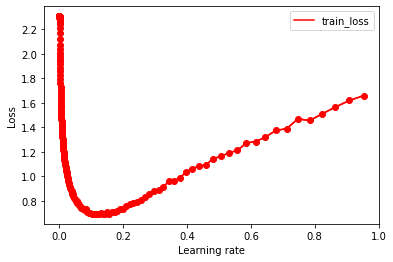

In [15]:
x1=[1e-5*(1.05**i) for i in range(NUM_EPOCHS)]
y1=train_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
plt.plot(x1,y1,'ro-')
# plt.title('Learning curve')
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.legend()
plt.show()

损失函数随训练步数呈对勾形，选择损失下降最快那一段的学习率。这里选择学习率为 0.1。

In [18]:
LOG_PATH="./train2.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
    
model = Net()
if AVAIL_GPUS:
    model = model.cuda()

BATCH_SIZE = 128
LEARNING_RATE = 0.1
NUM_EPOCHS = 100
print("Model: CNN from Pytorch tutorial")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: SGD")
print("Learning rate: %f" % (LEARNING_RATE))
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: SGD")
    f.write("\n")
    f.write("Learning rate: %d" % (LEARNING_RATE))
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
        
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: CNN from Pytorch tutorial
Batch size: 128
Epoch num: 100
Optimizer: SGD
---------- Training Epoch #0 ----------
Learning rate: 0.100000


391it [00:03, 124.74it/s]

Finish 1 epoch, Train loss: 2.039433, Train acc@1: 0.247260


Test loss: 1.760187, Test acc@1: 0.365500
Saving Best model...			Top1 = 36.550000%
Elapsed time: 5.129424571990967
---------- Training Epoch #1 ----------
Learning rate: 0.100000


391it [00:03, 126.63it/s]

Finish 2 epoch, Train loss: 1.616057, Train acc@1: 0.411680


Test loss: 1.450363, Test acc@1: 0.473300
Saving Best model...			Top1 = 47.330000%
Elapsed time: 10.059629201889038
---------- Training Epoch #2 ----------
Learning rate: 0.100000


391it [00:03, 127.56it/s]

Finish 3 epoch, Train loss: 1.436083, Train acc@1: 0.482860


Test loss: 1.359083, Test acc@1: 0.508800
Saving Best model...			Top1 = 50.880000%
Elapsed time: 15.02189826965332
---------- Training Epoch #3 ----------
Learning rate: 0.100000


391it [00:03, 128.44it/s]

Finish 4 epoch, Train loss: 1.327442, Train acc@1: 0.525680


Test loss: 1.383712, Test acc@1: 0.507500
Elapsed time: 19.958107471466064
---------- Training Epoch #4 ----------
Learning rate: 0.100000


391it [00:03, 126.00it/s]

Finish 5 epoch, Train loss: 1.235400, Train acc@1: 0.560680


Test loss: 1.210171, Test acc@1: 0.565900
Saving Best model...			Top1 = 56.590000%
Elapsed time: 25.183993816375732
---------- Training Epoch #5 ----------
Learning rate: 0.100000


391it [00:03, 125.49it/s]

Finish 6 epoch, Train loss: 1.172225, Train acc@1: 0.586800


Test loss: 1.208203, Test acc@1: 0.570900
Saving Best model...			Top1 = 57.090000%
Elapsed time: 30.260874271392822
---------- Training Epoch #6 ----------
Learning rate: 0.100000


391it [00:03, 129.45it/s]

Finish 7 epoch, Train loss: 1.115208, Train acc@1: 0.607260


Test loss: 1.150092, Test acc@1: 0.596900
Saving Best model...			Top1 = 59.690000%
Elapsed time: 35.13345813751221
---------- Training Epoch #7 ----------
Learning rate: 0.100000


391it [00:02, 130.93it/s]

Finish 8 epoch, Train loss: 1.065277, Train acc@1: 0.624520


Test loss: 1.133969, Test acc@1: 0.603700
Saving Best model...			Top1 = 60.370000%
Elapsed time: 40.03641366958618
---------- Training Epoch #8 ----------
Learning rate: 0.100000


391it [00:03, 125.23it/s]

Finish 9 epoch, Train loss: 1.016529, Train acc@1: 0.643460


Test loss: 1.348930, Test acc@1: 0.553000
Elapsed time: 45.117257833480835
---------- Training Epoch #9 ----------
Learning rate: 0.100000


391it [00:03, 126.92it/s]

Finish 10 epoch, Train loss: 0.977801, Train acc@1: 0.657940


Test loss: 1.123291, Test acc@1: 0.611500
Saving Best model...			Top1 = 61.150000%
Elapsed time: 50.05724740028381
---------- Training Epoch #10 ----------
Learning rate: 0.100000


391it [00:03, 127.57it/s]

Finish 11 epoch, Train loss: 0.930108, Train acc@1: 0.672040


Test loss: 1.161123, Test acc@1: 0.607800
Elapsed time: 55.03301167488098
---------- Training Epoch #11 ----------
Learning rate: 0.100000


391it [00:03, 120.73it/s]

Finish 12 epoch, Train loss: 0.894496, Train acc@1: 0.686740


Test loss: 1.230674, Test acc@1: 0.594600
Elapsed time: 60.30408763885498
---------- Training Epoch #12 ----------
Learning rate: 0.100000


391it [00:03, 124.13it/s]

Finish 13 epoch, Train loss: 0.859277, Train acc@1: 0.697220


Test loss: 1.081149, Test acc@1: 0.629600
Saving Best model...			Top1 = 62.960000%
Elapsed time: 65.36088180541992
---------- Training Epoch #13 ----------
Learning rate: 0.100000


391it [00:03, 129.14it/s]

Finish 14 epoch, Train loss: 0.826435, Train acc@1: 0.709240


Test loss: 1.085068, Test acc@1: 0.631300
Saving Best model...			Top1 = 63.130000%
Elapsed time: 70.26839637756348
---------- Training Epoch #14 ----------
Learning rate: 0.100000


391it [00:03, 126.32it/s]

Finish 15 epoch, Train loss: 0.799058, Train acc@1: 0.717900


Test loss: 1.134884, Test acc@1: 0.623500
Elapsed time: 75.2563271522522
---------- Training Epoch #15 ----------
Learning rate: 0.100000


391it [00:03, 122.30it/s]

Finish 16 epoch, Train loss: 0.773472, Train acc@1: 0.726600


Test loss: 1.252053, Test acc@1: 0.594500
Elapsed time: 80.35968351364136
---------- Training Epoch #16 ----------
Learning rate: 0.100000


391it [00:03, 127.08it/s]


Finish 17 epoch, Train loss: 0.742161, Train acc@1: 0.735560
Test loss: 1.116683, Test acc@1: 0.623100
Elapsed time: 85.41931772232056
---------- Training Epoch #17 ----------
Learning rate: 0.100000


391it [00:03, 126.87it/s]

Finish 18 epoch, Train loss: 0.714366, Train acc@1: 0.746720


Test loss: 1.199733, Test acc@1: 0.615100
Elapsed time: 90.39828324317932
---------- Training Epoch #18 ----------
Learning rate: 0.100000


391it [00:03, 127.62it/s]

Finish 19 epoch, Train loss: 0.695042, Train acc@1: 0.752320


Test loss: 1.176705, Test acc@1: 0.615600
Elapsed time: 95.38529133796692
---------- Training Epoch #19 ----------
Learning rate: 0.100000


391it [00:03, 128.13it/s]

Finish 20 epoch, Train loss: 0.660509, Train acc@1: 0.765620


Test loss: 1.162098, Test acc@1: 0.633400
Saving Best model...			Top1 = 63.340000%
Elapsed time: 100.38787460327148
---------- Training Epoch #20 ----------
Learning rate: 0.100000


391it [00:03, 125.98it/s]

Finish 21 epoch, Train loss: 0.643154, Train acc@1: 0.771540


Test loss: 1.260751, Test acc@1: 0.613500
Elapsed time: 105.44344353675842
---------- Training Epoch #21 ----------
Learning rate: 0.100000


391it [00:02, 131.16it/s]

Finish 22 epoch, Train loss: 0.620068, Train acc@1: 0.777480


Test loss: 1.270375, Test acc@1: 0.622500
Elapsed time: 110.39342999458313
---------- Training Epoch #22 ----------
Learning rate: 0.100000


391it [00:03, 127.34it/s]

Finish 23 epoch, Train loss: 0.604284, Train acc@1: 0.782880


Test loss: 1.279395, Test acc@1: 0.623200
Elapsed time: 115.37564969062805
---------- Training Epoch #23 ----------
Learning rate: 0.100000


391it [00:03, 127.43it/s]

Finish 24 epoch, Train loss: 0.591579, Train acc@1: 0.789080


Test loss: 1.282947, Test acc@1: 0.621500
Elapsed time: 120.33142709732056
---------- Training Epoch #24 ----------
Learning rate: 0.100000


391it [00:03, 123.95it/s]

Finish 25 epoch, Train loss: 0.570021, Train acc@1: 0.796440


Test loss: 1.301950, Test acc@1: 0.616300
Elapsed time: 125.37191534042358
---------- Training Epoch #25 ----------
Learning rate: 0.100000


391it [00:03, 128.61it/s]

Finish 26 epoch, Train loss: 0.550350, Train acc@1: 0.803160


Test loss: 1.361395, Test acc@1: 0.609400
Elapsed time: 130.3429262638092
---------- Training Epoch #26 ----------
Learning rate: 0.100000


391it [00:03, 119.12it/s]

Finish 27 epoch, Train loss: 0.535636, Train acc@1: 0.806900


Test loss: 1.571024, Test acc@1: 0.594300
Elapsed time: 135.55100226402283
---------- Training Epoch #27 ----------
Learning rate: 0.100000


391it [00:03, 128.57it/s]

Finish 28 epoch, Train loss: 0.521145, Train acc@1: 0.811960


Test loss: 1.475003, Test acc@1: 0.605900
Elapsed time: 140.4711675643921
---------- Training Epoch #28 ----------
Learning rate: 0.100000


391it [00:03, 128.89it/s]

Finish 29 epoch, Train loss: 0.506597, Train acc@1: 0.818000


Test loss: 1.422850, Test acc@1: 0.611600
Elapsed time: 145.3432686328888
---------- Training Epoch #29 ----------
Learning rate: 0.100000


391it [00:03, 128.25it/s]

Finish 30 epoch, Train loss: 0.493397, Train acc@1: 0.823120


Test loss: 1.492470, Test acc@1: 0.611200
Elapsed time: 150.28351092338562
---------- Training Epoch #30 ----------
Learning rate: 0.100000


391it [00:03, 126.55it/s]

Finish 31 epoch, Train loss: 0.482902, Train acc@1: 0.825140


Test loss: 1.528057, Test acc@1: 0.613200
Elapsed time: 155.2354609966278
---------- Training Epoch #31 ----------
Learning rate: 0.100000


391it [00:02, 130.44it/s]

Finish 32 epoch, Train loss: 0.469623, Train acc@1: 0.830920


Test loss: 1.581417, Test acc@1: 0.602000
Elapsed time: 160.15669131278992
---------- Training Epoch #32 ----------
Learning rate: 0.100000


391it [00:03, 126.78it/s]

Finish 33 epoch, Train loss: 0.455051, Train acc@1: 0.836000


Test loss: 1.580495, Test acc@1: 0.615900
Elapsed time: 165.1824107170105
---------- Training Epoch #33 ----------
Learning rate: 0.100000


391it [00:03, 124.41it/s]

Finish 34 epoch, Train loss: 0.449506, Train acc@1: 0.838080


Test loss: 1.717941, Test acc@1: 0.582600
Elapsed time: 170.27441835403442
---------- Training Epoch #34 ----------
Learning rate: 0.100000


391it [00:03, 122.31it/s]

Finish 35 epoch, Train loss: 0.422761, Train acc@1: 0.848340


Test loss: 1.726353, Test acc@1: 0.600400
Elapsed time: 175.36973810195923
---------- Training Epoch #35 ----------
Learning rate: 0.100000


391it [00:03, 125.12it/s]

Finish 36 epoch, Train loss: 0.428342, Train acc@1: 0.844440


Test loss: 1.747423, Test acc@1: 0.586600
Elapsed time: 180.4476764202118
---------- Training Epoch #36 ----------
Learning rate: 0.100000


391it [00:03, 124.62it/s]

Finish 37 epoch, Train loss: 0.426970, Train acc@1: 0.846420


Test loss: 1.748408, Test acc@1: 0.607800
Elapsed time: 185.58175897598267
---------- Training Epoch #37 ----------
Learning rate: 0.100000


391it [00:03, 122.30it/s]


Finish 38 epoch, Train loss: 0.407605, Train acc@1: 0.853520
Test loss: 1.831069, Test acc@1: 0.590000
Elapsed time: 190.70050859451294
---------- Training Epoch #38 ----------
Learning rate: 0.100000


391it [00:03, 123.65it/s]

Finish 39 epoch, Train loss: 0.395262, Train acc@1: 0.857020


Test loss: 1.822376, Test acc@1: 0.606100
Elapsed time: 195.84033346176147
---------- Training Epoch #39 ----------
Learning rate: 0.100000


391it [00:03, 125.45it/s]

Finish 40 epoch, Train loss: 0.394740, Train acc@1: 0.858380


Test loss: 1.789436, Test acc@1: 0.604500
Elapsed time: 200.8303508758545
---------- Training Epoch #40 ----------
Learning rate: 0.100000


391it [00:03, 124.81it/s]

Finish 41 epoch, Train loss: 0.384934, Train acc@1: 0.860220


Test loss: 1.943720, Test acc@1: 0.598900
Elapsed time: 205.81298756599426
---------- Training Epoch #41 ----------
Learning rate: 0.100000


391it [00:03, 121.27it/s]

Finish 42 epoch, Train loss: 0.370148, Train acc@1: 0.866980


Test loss: 1.881807, Test acc@1: 0.610200
Elapsed time: 210.8930869102478
---------- Training Epoch #42 ----------
Learning rate: 0.100000


391it [00:03, 125.71it/s]

Finish 43 epoch, Train loss: 0.376917, Train acc@1: 0.863020


Test loss: 1.960531, Test acc@1: 0.605300
Elapsed time: 215.94470596313477
---------- Training Epoch #43 ----------
Learning rate: 0.100000


391it [00:03, 127.50it/s]

Finish 44 epoch, Train loss: 0.362384, Train acc@1: 0.869080


Test loss: 1.927731, Test acc@1: 0.604800
Elapsed time: 220.8301305770874
---------- Training Epoch #44 ----------
Learning rate: 0.100000


391it [00:03, 127.19it/s]

Finish 45 epoch, Train loss: 0.360685, Train acc@1: 0.869300


Test loss: 1.971342, Test acc@1: 0.602800
Elapsed time: 225.74004411697388
---------- Training Epoch #45 ----------
Learning rate: 0.100000


391it [00:03, 126.31it/s]

Finish 46 epoch, Train loss: 0.374719, Train acc@1: 0.865620


Test loss: 1.923635, Test acc@1: 0.595300
Elapsed time: 230.75384783744812
---------- Training Epoch #46 ----------
Learning rate: 0.100000


391it [00:03, 125.64it/s]

Finish 47 epoch, Train loss: 0.337754, Train acc@1: 0.877080


Test loss: 2.055938, Test acc@1: 0.604700
Elapsed time: 235.77952694892883
---------- Training Epoch #47 ----------
Learning rate: 0.100000


391it [00:03, 124.49it/s]

Finish 48 epoch, Train loss: 0.338853, Train acc@1: 0.878580


Test loss: 2.111833, Test acc@1: 0.600300
Elapsed time: 240.90543794631958
---------- Training Epoch #48 ----------
Learning rate: 0.100000


391it [00:03, 123.45it/s]

Finish 49 epoch, Train loss: 0.340165, Train acc@1: 0.879080


Test loss: 2.130011, Test acc@1: 0.582300
Elapsed time: 245.96334648132324
---------- Training Epoch #49 ----------
Learning rate: 0.100000


391it [00:03, 124.36it/s]


Finish 50 epoch, Train loss: 0.327198, Train acc@1: 0.882560
Test loss: 2.132870, Test acc@1: 0.593000
Elapsed time: 251.00682163238525
---------- Training Epoch #50 ----------
Learning rate: 0.100000


391it [00:03, 124.36it/s]

Finish 51 epoch, Train loss: 0.311295, Train acc@1: 0.888880


Test loss: 2.218635, Test acc@1: 0.599300
Elapsed time: 255.95495176315308
---------- Training Epoch #51 ----------
Learning rate: 0.100000


391it [00:03, 127.79it/s]

Finish 52 epoch, Train loss: 0.333407, Train acc@1: 0.882080


Test loss: 2.213477, Test acc@1: 0.602000
Elapsed time: 260.8464698791504
---------- Training Epoch #52 ----------
Learning rate: 0.100000


391it [00:03, 125.41it/s]

Finish 53 epoch, Train loss: 0.331428, Train acc@1: 0.882620


Test loss: 2.202667, Test acc@1: 0.592700
Elapsed time: 265.79030323028564
---------- Training Epoch #53 ----------
Learning rate: 0.100000


391it [00:03, 124.47it/s]

Finish 54 epoch, Train loss: 0.304771, Train acc@1: 0.891760


Test loss: 2.390051, Test acc@1: 0.592300
Elapsed time: 270.79245114326477
---------- Training Epoch #54 ----------
Learning rate: 0.100000


391it [00:02, 130.86it/s]

Finish 55 epoch, Train loss: 0.309702, Train acc@1: 0.889260


Test loss: 2.250397, Test acc@1: 0.594800
Elapsed time: 275.6195664405823
---------- Training Epoch #55 ----------
Learning rate: 0.100000


391it [00:03, 125.72it/s]

Finish 56 epoch, Train loss: 0.304290, Train acc@1: 0.892720


Test loss: 2.467726, Test acc@1: 0.576000
Elapsed time: 280.6397409439087
---------- Training Epoch #56 ----------
Learning rate: 0.100000


391it [00:03, 124.00it/s]

Finish 57 epoch, Train loss: 0.298178, Train acc@1: 0.895500


Test loss: 2.434371, Test acc@1: 0.594300
Elapsed time: 285.64353036880493
---------- Training Epoch #57 ----------
Learning rate: 0.100000


391it [00:03, 126.88it/s]

Finish 58 epoch, Train loss: 0.300906, Train acc@1: 0.894320


Test loss: 2.409760, Test acc@1: 0.587300
Elapsed time: 290.5903899669647
---------- Training Epoch #58 ----------
Learning rate: 0.100000


391it [00:03, 125.21it/s]

Finish 59 epoch, Train loss: 0.298241, Train acc@1: 0.893700


Test loss: 2.499184, Test acc@1: 0.586100
Elapsed time: 295.74473905563354
---------- Training Epoch #59 ----------
Learning rate: 0.100000


391it [00:03, 129.28it/s]

Finish 60 epoch, Train loss: 0.313466, Train acc@1: 0.890160


Test loss: 2.577995, Test acc@1: 0.588900
Elapsed time: 300.6351101398468
---------- Training Epoch #60 ----------
Learning rate: 0.100000


391it [00:03, 129.07it/s]

Finish 61 epoch, Train loss: 0.294334, Train acc@1: 0.895200


Test loss: 2.572443, Test acc@1: 0.580000
Elapsed time: 305.61843085289
---------- Training Epoch #61 ----------
Learning rate: 0.100000


391it [00:03, 127.18it/s]

Finish 62 epoch, Train loss: 0.294023, Train acc@1: 0.895880


Test loss: 2.477043, Test acc@1: 0.597400
Elapsed time: 310.61021399497986
---------- Training Epoch #62 ----------
Learning rate: 0.100000


391it [00:03, 121.30it/s]

Finish 63 epoch, Train loss: 0.265227, Train acc@1: 0.907240


Test loss: 2.754248, Test acc@1: 0.582700
Elapsed time: 315.669052362442
---------- Training Epoch #63 ----------
Learning rate: 0.100000


391it [00:03, 127.19it/s]

Finish 64 epoch, Train loss: 0.302372, Train acc@1: 0.895480


Test loss: 2.558728, Test acc@1: 0.590000
Elapsed time: 320.59361958503723
---------- Training Epoch #64 ----------
Learning rate: 0.100000


391it [00:03, 128.58it/s]


Finish 65 epoch, Train loss: 0.277494, Train acc@1: 0.903620
Test loss: 2.677678, Test acc@1: 0.599100
Elapsed time: 325.61760425567627
---------- Training Epoch #65 ----------
Learning rate: 0.100000


391it [00:03, 130.27it/s]

Finish 66 epoch, Train loss: 0.274943, Train acc@1: 0.902220


Test loss: 2.579697, Test acc@1: 0.595400
Elapsed time: 330.4975326061249
---------- Training Epoch #66 ----------
Learning rate: 0.100000


391it [00:03, 122.44it/s]

Finish 67 epoch, Train loss: 0.271329, Train acc@1: 0.904620


Test loss: 2.631973, Test acc@1: 0.584300
Elapsed time: 335.59725284576416
---------- Training Epoch #67 ----------
Learning rate: 0.100000


391it [00:03, 125.09it/s]

Finish 68 epoch, Train loss: 0.262293, Train acc@1: 0.906520


Test loss: 2.883488, Test acc@1: 0.586300
Elapsed time: 340.6327238082886
---------- Training Epoch #68 ----------
Learning rate: 0.100000


391it [00:03, 126.38it/s]

Finish 69 epoch, Train loss: 0.273871, Train acc@1: 0.904200


Test loss: 2.613246, Test acc@1: 0.586300
Elapsed time: 345.63862109184265
---------- Training Epoch #69 ----------
Learning rate: 0.100000


391it [00:02, 131.01it/s]

Finish 70 epoch, Train loss: 0.280881, Train acc@1: 0.903800


Test loss: 2.631852, Test acc@1: 0.588900
Elapsed time: 350.54632472991943
---------- Training Epoch #70 ----------
Learning rate: 0.100000


391it [00:03, 128.25it/s]

Finish 71 epoch, Train loss: 0.263764, Train acc@1: 0.907660


Test loss: 2.756738, Test acc@1: 0.594300
Elapsed time: 355.56413173675537
---------- Training Epoch #71 ----------
Learning rate: 0.100000


391it [00:03, 126.18it/s]

Finish 72 epoch, Train loss: 0.264331, Train acc@1: 0.908760


Test loss: 2.897823, Test acc@1: 0.587700
Elapsed time: 360.65393328666687
---------- Training Epoch #72 ----------
Learning rate: 0.100000


391it [00:03, 126.52it/s]

Finish 73 epoch, Train loss: 0.250747, Train acc@1: 0.912740


Test loss: 2.938726, Test acc@1: 0.578400
Elapsed time: 365.62239384651184
---------- Training Epoch #73 ----------
Learning rate: 0.100000


391it [00:03, 125.83it/s]

Finish 74 epoch, Train loss: 0.264166, Train acc@1: 0.908460


Test loss: 3.014113, Test acc@1: 0.576700
Elapsed time: 370.66887521743774
---------- Training Epoch #74 ----------
Learning rate: 0.100000


391it [00:03, 122.29it/s]

Finish 75 epoch, Train loss: 0.256503, Train acc@1: 0.910360


Test loss: 2.913238, Test acc@1: 0.594200
Elapsed time: 375.730685710907
---------- Training Epoch #75 ----------
Learning rate: 0.100000


391it [00:03, 126.84it/s]

Finish 76 epoch, Train loss: 0.267229, Train acc@1: 0.908700


Test loss: 2.973456, Test acc@1: 0.577000
Elapsed time: 380.79441595077515
---------- Training Epoch #76 ----------
Learning rate: 0.100000


391it [00:03, 126.55it/s]

Finish 77 epoch, Train loss: 0.266757, Train acc@1: 0.908420


Test loss: 2.848790, Test acc@1: 0.594600
Elapsed time: 385.7684338092804
---------- Training Epoch #77 ----------
Learning rate: 0.100000


391it [00:03, 126.79it/s]

Finish 78 epoch, Train loss: 0.254820, Train acc@1: 0.912380


Test loss: 3.020930, Test acc@1: 0.583300
Elapsed time: 390.749440908432
---------- Training Epoch #78 ----------
Learning rate: 0.100000


391it [00:03, 122.88it/s]

Finish 79 epoch, Train loss: 0.259354, Train acc@1: 0.910620


Test loss: 2.991834, Test acc@1: 0.587400
Elapsed time: 395.7983901500702
---------- Training Epoch #79 ----------
Learning rate: 0.100000


391it [00:03, 123.20it/s]

Finish 80 epoch, Train loss: 0.260844, Train acc@1: 0.911040


Test loss: 3.163467, Test acc@1: 0.568900
Elapsed time: 400.81057620048523
---------- Training Epoch #80 ----------
Learning rate: 0.100000


391it [00:03, 130.13it/s]

Finish 81 epoch, Train loss: 0.283053, Train acc@1: 0.906040


Test loss: 3.259563, Test acc@1: 0.565600
Elapsed time: 405.7200427055359
---------- Training Epoch #81 ----------
Learning rate: 0.100000


391it [00:03, 127.78it/s]

Finish 82 epoch, Train loss: 0.237406, Train acc@1: 0.919640


Test loss: 3.121379, Test acc@1: 0.591200
Elapsed time: 410.6893539428711
---------- Training Epoch #82 ----------
Learning rate: 0.100000


391it [00:03, 127.62it/s]

Finish 83 epoch, Train loss: 0.260003, Train acc@1: 0.912620


Test loss: 3.041689, Test acc@1: 0.586500
Elapsed time: 415.603453874588
---------- Training Epoch #83 ----------
Learning rate: 0.100000


391it [00:03, 127.52it/s]

Finish 84 epoch, Train loss: 0.227596, Train acc@1: 0.921360


Test loss: 3.204083, Test acc@1: 0.581000
Elapsed time: 420.6376097202301
---------- Training Epoch #84 ----------
Learning rate: 0.100000


391it [00:03, 128.35it/s]

Finish 85 epoch, Train loss: 0.264817, Train acc@1: 0.912340


Test loss: 3.069371, Test acc@1: 0.576900
Elapsed time: 425.6182770729065
---------- Training Epoch #85 ----------
Learning rate: 0.100000


391it [00:03, 126.54it/s]


Finish 86 epoch, Train loss: 0.260610, Train acc@1: 0.912880
Test loss: 3.070397, Test acc@1: 0.575300
Elapsed time: 430.5997588634491
---------- Training Epoch #86 ----------
Learning rate: 0.100000


391it [00:03, 121.98it/s]

Finish 87 epoch, Train loss: 0.255696, Train acc@1: 0.911900


Test loss: 3.043863, Test acc@1: 0.588100
Elapsed time: 435.66091227531433
---------- Training Epoch #87 ----------
Learning rate: 0.100000


391it [00:03, 119.27it/s]

Finish 88 epoch, Train loss: 0.255223, Train acc@1: 0.914680


Test loss: 3.380818, Test acc@1: 0.579700
Elapsed time: 440.84017753601074
---------- Training Epoch #88 ----------
Learning rate: 0.100000


391it [00:03, 125.38it/s]

Finish 89 epoch, Train loss: 0.252639, Train acc@1: 0.916680


Test loss: 3.198873, Test acc@1: 0.590400
Elapsed time: 445.80840015411377
---------- Training Epoch #89 ----------
Learning rate: 0.100000


391it [00:02, 130.35it/s]

Finish 90 epoch, Train loss: 0.232830, Train acc@1: 0.920900


Test loss: 3.119590, Test acc@1: 0.580600
Elapsed time: 450.7626028060913
---------- Training Epoch #90 ----------
Learning rate: 0.100000


391it [00:03, 126.51it/s]

Finish 91 epoch, Train loss: 0.246319, Train acc@1: 0.916100


Test loss: 3.197581, Test acc@1: 0.592000
Elapsed time: 455.77832651138306
---------- Training Epoch #91 ----------
Learning rate: 0.100000


391it [00:03, 126.99it/s]

Finish 92 epoch, Train loss: 0.252449, Train acc@1: 0.917380


Test loss: 3.183761, Test acc@1: 0.572800
Elapsed time: 460.7206201553345
---------- Training Epoch #92 ----------
Learning rate: 0.100000


391it [00:02, 132.20it/s]

Finish 93 epoch, Train loss: 0.247150, Train acc@1: 0.917240


Test loss: 3.455821, Test acc@1: 0.572700
Elapsed time: 465.5915937423706
---------- Training Epoch #93 ----------
Learning rate: 0.100000


391it [00:03, 128.62it/s]

Finish 94 epoch, Train loss: 0.229138, Train acc@1: 0.922820


Test loss: 3.461859, Test acc@1: 0.579200
Elapsed time: 470.56162548065186
---------- Training Epoch #94 ----------
Learning rate: 0.100000


391it [00:03, 128.39it/s]

Finish 95 epoch, Train loss: 0.257568, Train acc@1: 0.916680


Test loss: 3.509138, Test acc@1: 0.576100
Elapsed time: 475.48141527175903
---------- Training Epoch #95 ----------
Learning rate: 0.100000


391it [00:03, 126.25it/s]

Finish 96 epoch, Train loss: 0.274689, Train acc@1: 0.909320


Test loss: 3.439307, Test acc@1: 0.580100
Elapsed time: 480.5358920097351
---------- Training Epoch #96 ----------
Learning rate: 0.100000


391it [00:03, 119.37it/s]

Finish 97 epoch, Train loss: 0.248965, Train acc@1: 0.917600


Test loss: 3.271634, Test acc@1: 0.583300
Elapsed time: 485.70413088798523
---------- Training Epoch #97 ----------
Learning rate: 0.100000


391it [00:03, 123.40it/s]

Finish 98 epoch, Train loss: 0.229491, Train acc@1: 0.923160


Test loss: 3.626178, Test acc@1: 0.572600
Elapsed time: 490.79108142852783
---------- Training Epoch #98 ----------
Learning rate: 0.100000


391it [00:03, 125.51it/s]

Finish 99 epoch, Train loss: 0.283450, Train acc@1: 0.909600


Test loss: 3.342980, Test acc@1: 0.583200
Elapsed time: 495.7553942203522
---------- Training Epoch #99 ----------
Learning rate: 0.100000


391it [00:03, 120.94it/s]

Finish 100 epoch, Train loss: 0.232360, Train acc@1: 0.922320


Test loss: 3.520976, Test acc@1: 0.567600
Elapsed time: 500.83982038497925

Test results: Acc@1 = 63.340000%


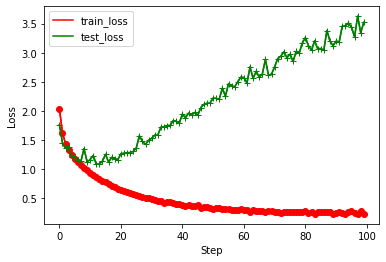

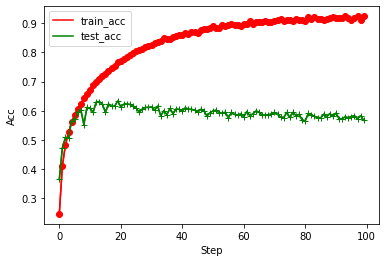

In [19]:
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

可以看到收敛过程快了很多，大约 20 步就达到最优了

### 2. Momentum and weight decay
momentum 在梯度下降中能够加速收敛，weight decay 就是 L2正则化，一定程度上减少模型过拟合的问题。

In [25]:
LOG_PATH="./train3.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
    
model = Net()
if AVAIL_GPUS:
    model = model.cuda()
    
def get_optimizer(epoch):
    return optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)

BATCH_SIZE = 128
NUM_EPOCHS = 100
LEARNING_RATE = 0.1
print("Model: CNN from Pytorch tutorial")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: SGD")
print("Learning rate: %f" % (LEARNING_RATE))
print("Momentum: %f" % (0.9))
print("Weight decay: %f" % (5e-4))
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: SGD")
    f.write("\n")
    f.write("Learning rate: %f" % (LEARNING_RATE))
    f.write("\n")
    f.write("Momentum: %f" % (0.9))
    f.write("\n")
    f.write("Weight decay: %f" % (5e-4))
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
        
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: CNN from Pytorch tutorial
Batch size: 128
Epoch num: 100
Optimizer: SGD
Learning rate: 0.100000
Momentum: 0.900000
Weight decay: 0.000500
---------- Training Epoch #0 ----------


391it [00:03, 124.20it/s]

Finish 1 epoch, Train loss: 1.850766, Train acc@1: 0.313780


Test loss: 1.595280, Test acc@1: 0.413400
Saving Best model...			Top1 = 41.340000%
Elapsed time: 5.004481554031372
---------- Training Epoch #1 ----------


391it [00:03, 124.19it/s]

Finish 2 epoch, Train loss: 1.531276, Train acc@1: 0.444680


Test loss: 1.585362, Test acc@1: 0.452800
Saving Best model...			Top1 = 45.280000%
Elapsed time: 9.976662635803223
---------- Training Epoch #2 ----------


391it [00:03, 121.81it/s]

Finish 3 epoch, Train loss: 1.454967, Train acc@1: 0.480380


Test loss: 1.456994, Test acc@1: 0.497800
Saving Best model...			Top1 = 49.780000%
Elapsed time: 15.020521402359009
---------- Training Epoch #3 ----------


391it [00:03, 120.37it/s]

Finish 4 epoch, Train loss: 1.380958, Train acc@1: 0.513100


Test loss: 1.383079, Test acc@1: 0.514800
Saving Best model...			Top1 = 51.480000%
Elapsed time: 20.097286701202393
---------- Training Epoch #4 ----------


391it [00:03, 122.16it/s]

Finish 5 epoch, Train loss: 1.365684, Train acc@1: 0.518700


Test loss: 1.383051, Test acc@1: 0.527100
Saving Best model...			Top1 = 52.710000%
Elapsed time: 25.138163805007935
---------- Training Epoch #5 ----------


391it [00:03, 121.73it/s]

Finish 6 epoch, Train loss: 1.334906, Train acc@1: 0.531900


Test loss: 1.351364, Test acc@1: 0.537300
Saving Best model...			Top1 = 53.730000%
Elapsed time: 30.22503137588501
---------- Training Epoch #6 ----------


391it [00:03, 123.91it/s]

Finish 7 epoch, Train loss: 1.320617, Train acc@1: 0.540820


Test loss: 1.341855, Test acc@1: 0.528100
Elapsed time: 35.265742778778076
---------- Training Epoch #7 ----------


391it [00:03, 123.02it/s]

Finish 8 epoch, Train loss: 1.303891, Train acc@1: 0.547640


Test loss: 1.438935, Test acc@1: 0.510900
Elapsed time: 40.25913691520691
---------- Training Epoch #8 ----------


391it [00:03, 126.33it/s]

Finish 9 epoch, Train loss: 1.276024, Train acc@1: 0.556780


Test loss: 1.458024, Test acc@1: 0.518500
Elapsed time: 45.24781513214111
---------- Training Epoch #9 ----------


391it [00:03, 124.59it/s]

Finish 10 epoch, Train loss: 1.267582, Train acc@1: 0.562500


Test loss: 1.345174, Test acc@1: 0.531400
Elapsed time: 50.193756341934204
---------- Training Epoch #10 ----------


391it [00:03, 123.18it/s]


Finish 11 epoch, Train loss: 1.260432, Train acc@1: 0.567200
Test loss: 1.360345, Test acc@1: 0.525700
Elapsed time: 55.27990484237671
---------- Training Epoch #11 ----------


391it [00:03, 120.63it/s]

Finish 12 epoch, Train loss: 1.245668, Train acc@1: 0.573700


Test loss: 1.377959, Test acc@1: 0.526100
Elapsed time: 60.35023283958435
---------- Training Epoch #12 ----------


391it [00:03, 126.33it/s]

Finish 13 epoch, Train loss: 1.237746, Train acc@1: 0.572260


Test loss: 1.351816, Test acc@1: 0.537200
Elapsed time: 65.35037755966187
---------- Training Epoch #13 ----------


391it [00:03, 124.13it/s]

Finish 14 epoch, Train loss: 1.226378, Train acc@1: 0.577680


Test loss: 1.262369, Test acc@1: 0.568600
Saving Best model...			Top1 = 56.860000%
Elapsed time: 70.35478019714355
---------- Training Epoch #14 ----------


391it [00:03, 124.73it/s]

Finish 15 epoch, Train loss: 1.235436, Train acc@1: 0.576060


Test loss: 1.402315, Test acc@1: 0.528200
Elapsed time: 75.33595561981201
---------- Training Epoch #15 ----------


391it [00:04, 93.79it/s] 

Finish 16 epoch, Train loss: 1.219350, Train acc@1: 0.583120


Test loss: 1.325311, Test acc@1: 0.552300
Elapsed time: 81.48374819755554
---------- Training Epoch #16 ----------


391it [00:03, 124.56it/s]

Finish 17 epoch, Train loss: 1.221479, Train acc@1: 0.580460


Test loss: 1.363290, Test acc@1: 0.517600
Elapsed time: 86.57507467269897
---------- Training Epoch #17 ----------


391it [00:03, 119.46it/s]

Finish 18 epoch, Train loss: 1.232357, Train acc@1: 0.578120


Test loss: 1.297998, Test acc@1: 0.555600
Elapsed time: 91.84041452407837
---------- Training Epoch #18 ----------


391it [00:03, 126.40it/s]

Finish 19 epoch, Train loss: 1.202651, Train acc@1: 0.587420


Test loss: 1.246458, Test acc@1: 0.571400
Saving Best model...			Top1 = 57.140000%
Elapsed time: 96.85046672821045
---------- Training Epoch #19 ----------


391it [00:03, 119.78it/s]

Finish 20 epoch, Train loss: 1.195525, Train acc@1: 0.591980


Test loss: 1.440578, Test acc@1: 0.519000
Elapsed time: 101.98629379272461
---------- Training Epoch #20 ----------


391it [00:03, 124.74it/s]

Finish 21 epoch, Train loss: 1.208167, Train acc@1: 0.588720


Test loss: 1.256591, Test acc@1: 0.576300
Saving Best model...			Top1 = 57.630000%
Elapsed time: 107.01454424858093
---------- Training Epoch #21 ----------


391it [00:03, 121.93it/s]

Finish 22 epoch, Train loss: 1.210864, Train acc@1: 0.585620


Test loss: 1.277044, Test acc@1: 0.571400
Elapsed time: 112.12280178070068
---------- Training Epoch #22 ----------


391it [00:03, 122.10it/s]

Finish 23 epoch, Train loss: 1.165741, Train acc@1: 0.602020


Test loss: 1.281192, Test acc@1: 0.564300
Elapsed time: 117.21524405479431
---------- Training Epoch #23 ----------


391it [00:03, 124.46it/s]

Finish 24 epoch, Train loss: 1.194919, Train acc@1: 0.594860


Test loss: 1.373336, Test acc@1: 0.535600
Elapsed time: 122.23642802238464
---------- Training Epoch #24 ----------


391it [00:03, 121.18it/s]

Finish 25 epoch, Train loss: 1.162884, Train acc@1: 0.604460


Test loss: 1.294757, Test acc@1: 0.559800
Elapsed time: 127.34587955474854
---------- Training Epoch #25 ----------


391it [00:03, 125.67it/s]

Finish 26 epoch, Train loss: 1.183514, Train acc@1: 0.597720


Test loss: 1.312673, Test acc@1: 0.572200
Elapsed time: 132.35969471931458
---------- Training Epoch #26 ----------


391it [00:03, 121.38it/s]

Finish 27 epoch, Train loss: 1.169613, Train acc@1: 0.604060


Test loss: 1.270666, Test acc@1: 0.566500
Elapsed time: 137.48671174049377
---------- Training Epoch #27 ----------


391it [00:03, 122.55it/s]

Finish 28 epoch, Train loss: 1.136853, Train acc@1: 0.611780


Test loss: 1.258346, Test acc@1: 0.580200
Saving Best model...			Top1 = 58.020000%
Elapsed time: 142.56889057159424
---------- Training Epoch #28 ----------


391it [00:03, 121.95it/s]

Finish 29 epoch, Train loss: 1.140544, Train acc@1: 0.609420


Test loss: 1.322212, Test acc@1: 0.546900
Elapsed time: 147.63626146316528
---------- Training Epoch #29 ----------


391it [00:03, 123.31it/s]

Finish 30 epoch, Train loss: 1.154164, Train acc@1: 0.607300


Test loss: 1.356485, Test acc@1: 0.554500
Elapsed time: 152.6811625957489
---------- Training Epoch #30 ----------


391it [00:03, 122.99it/s]

Finish 31 epoch, Train loss: 1.155090, Train acc@1: 0.607840


Test loss: 1.286356, Test acc@1: 0.574100
Elapsed time: 157.74828672409058
---------- Training Epoch #31 ----------


391it [00:03, 122.08it/s]

Finish 32 epoch, Train loss: 1.151024, Train acc@1: 0.608620


Test loss: 1.315401, Test acc@1: 0.560300
Elapsed time: 162.878080368042
---------- Training Epoch #32 ----------


391it [00:03, 124.75it/s]

Finish 33 epoch, Train loss: 1.154462, Train acc@1: 0.608560


Test loss: 1.200152, Test acc@1: 0.585700
Saving Best model...			Top1 = 58.570000%
Elapsed time: 167.88696718215942
---------- Training Epoch #33 ----------


391it [00:03, 125.92it/s]

Finish 34 epoch, Train loss: 1.152645, Train acc@1: 0.610340


Test loss: 1.389729, Test acc@1: 0.540000
Elapsed time: 172.9240415096283
---------- Training Epoch #34 ----------


391it [00:03, 124.39it/s]

Finish 35 epoch, Train loss: 1.148121, Train acc@1: 0.611340


Test loss: 1.371956, Test acc@1: 0.544400
Elapsed time: 177.9209907054901
---------- Training Epoch #35 ----------


391it [00:03, 122.72it/s]

Finish 36 epoch, Train loss: 1.152294, Train acc@1: 0.609000


Test loss: 1.263684, Test acc@1: 0.582900
Elapsed time: 182.99366354942322
---------- Training Epoch #36 ----------


391it [00:03, 117.86it/s]

Finish 37 epoch, Train loss: 1.144218, Train acc@1: 0.611980


Test loss: 1.306926, Test acc@1: 0.555800
Elapsed time: 188.21126985549927
---------- Training Epoch #37 ----------


391it [00:03, 120.17it/s]

Finish 38 epoch, Train loss: 1.155614, Train acc@1: 0.609200


Test loss: 1.342814, Test acc@1: 0.549900
Elapsed time: 193.28592801094055
---------- Training Epoch #38 ----------


391it [00:03, 122.75it/s]

Finish 39 epoch, Train loss: 1.162245, Train acc@1: 0.605920


Test loss: 1.294157, Test acc@1: 0.563700
Elapsed time: 198.36843824386597
---------- Training Epoch #39 ----------


391it [00:03, 116.23it/s]

Finish 40 epoch, Train loss: 1.143857, Train acc@1: 0.614380


Test loss: 1.294551, Test acc@1: 0.565600
Elapsed time: 203.59862208366394
---------- Training Epoch #40 ----------


391it [00:03, 122.54it/s]

Finish 41 epoch, Train loss: 1.162196, Train acc@1: 0.609500


Test loss: 1.369305, Test acc@1: 0.530300
Elapsed time: 208.6693434715271
---------- Training Epoch #41 ----------


391it [00:03, 126.42it/s]

Finish 42 epoch, Train loss: 1.147738, Train acc@1: 0.612260


Test loss: 1.239195, Test acc@1: 0.587200
Saving Best model...			Top1 = 58.720000%
Elapsed time: 213.58723163604736
---------- Training Epoch #42 ----------


391it [00:03, 122.11it/s]

Finish 43 epoch, Train loss: 1.134993, Train acc@1: 0.615360


Test loss: 1.321082, Test acc@1: 0.564900
Elapsed time: 218.6822645664215
---------- Training Epoch #43 ----------


391it [00:03, 120.80it/s]

Finish 44 epoch, Train loss: 1.154951, Train acc@1: 0.607060


Test loss: 1.314335, Test acc@1: 0.564900
Elapsed time: 223.84978556632996
---------- Training Epoch #44 ----------


391it [00:03, 120.92it/s]

Finish 45 epoch, Train loss: 1.127970, Train acc@1: 0.620040


Test loss: 1.415869, Test acc@1: 0.528900
Elapsed time: 229.02823162078857
---------- Training Epoch #45 ----------


391it [00:03, 120.01it/s]

Finish 46 epoch, Train loss: 1.138921, Train acc@1: 0.618840


Test loss: 1.213824, Test acc@1: 0.594100
Saving Best model...			Top1 = 59.410000%
Elapsed time: 234.16924381256104
---------- Training Epoch #46 ----------


391it [00:03, 121.97it/s]

Finish 47 epoch, Train loss: 1.166139, Train acc@1: 0.607400


Test loss: 1.347561, Test acc@1: 0.551300
Elapsed time: 239.24900126457214
---------- Training Epoch #47 ----------


391it [00:03, 124.80it/s]

Finish 48 epoch, Train loss: 1.141639, Train acc@1: 0.617660


Test loss: 1.221734, Test acc@1: 0.598400
Saving Best model...			Top1 = 59.840000%
Elapsed time: 244.24342894554138
---------- Training Epoch #48 ----------


391it [00:03, 125.45it/s]

Finish 49 epoch, Train loss: 1.137460, Train acc@1: 0.617140


Test loss: 1.313549, Test acc@1: 0.556900
Elapsed time: 249.2474081516266
---------- Training Epoch #49 ----------


391it [00:03, 124.43it/s]

Finish 50 epoch, Train loss: 1.122777, Train acc@1: 0.620160


Test loss: 1.232546, Test acc@1: 0.583500
Elapsed time: 254.2852122783661
---------- Training Epoch #50 ----------


391it [00:03, 123.13it/s]

Finish 51 epoch, Train loss: 1.124596, Train acc@1: 0.622160


Test loss: 1.224198, Test acc@1: 0.598700
Saving Best model...			Top1 = 59.870000%
Elapsed time: 259.3969144821167
---------- Training Epoch #51 ----------


391it [00:03, 118.13it/s]

Finish 52 epoch, Train loss: 1.116393, Train acc@1: 0.624000


Test loss: 1.254067, Test acc@1: 0.579800
Elapsed time: 264.5916516780853
---------- Training Epoch #52 ----------


391it [00:03, 124.87it/s]

Finish 53 epoch, Train loss: 1.128991, Train acc@1: 0.618880


Test loss: 1.274467, Test acc@1: 0.567800
Elapsed time: 269.6547758579254
---------- Training Epoch #53 ----------


391it [00:03, 122.37it/s]

Finish 54 epoch, Train loss: 1.112617, Train acc@1: 0.624340


Test loss: 1.234492, Test acc@1: 0.599600
Saving Best model...			Top1 = 59.960000%
Elapsed time: 274.76213908195496
---------- Training Epoch #54 ----------


391it [00:03, 123.62it/s]

Finish 55 epoch, Train loss: 1.133538, Train acc@1: 0.618660


Test loss: 1.262712, Test acc@1: 0.583300
Elapsed time: 279.8290867805481
---------- Training Epoch #55 ----------


391it [00:03, 123.03it/s]

Finish 56 epoch, Train loss: 1.128764, Train acc@1: 0.620160


Test loss: 1.267221, Test acc@1: 0.587500
Elapsed time: 284.90909147262573
---------- Training Epoch #56 ----------


391it [00:03, 125.09it/s]

Finish 57 epoch, Train loss: 1.123954, Train acc@1: 0.622840


Test loss: 1.234035, Test acc@1: 0.584500
Elapsed time: 289.9760866165161
---------- Training Epoch #57 ----------


391it [00:03, 121.15it/s]

Finish 58 epoch, Train loss: 1.141710, Train acc@1: 0.619260


Test loss: 1.288436, Test acc@1: 0.567800
Elapsed time: 295.0952160358429
---------- Training Epoch #58 ----------


391it [00:03, 121.24it/s]

Finish 59 epoch, Train loss: 1.117206, Train acc@1: 0.622560


Test loss: 1.358146, Test acc@1: 0.567500
Elapsed time: 300.21687507629395
---------- Training Epoch #59 ----------


391it [00:03, 125.02it/s]

Finish 60 epoch, Train loss: 1.114814, Train acc@1: 0.625460


Test loss: 1.247192, Test acc@1: 0.599100
Elapsed time: 305.20602440834045
---------- Training Epoch #60 ----------


391it [00:03, 123.51it/s]

Finish 61 epoch, Train loss: 1.131166, Train acc@1: 0.620580


Test loss: 1.248074, Test acc@1: 0.587500
Elapsed time: 310.2580804824829
---------- Training Epoch #61 ----------


391it [00:03, 120.39it/s]

Finish 62 epoch, Train loss: 1.113281, Train acc@1: 0.626920


Test loss: 1.243425, Test acc@1: 0.593600
Elapsed time: 315.4245352745056
---------- Training Epoch #62 ----------


391it [00:03, 123.84it/s]

Finish 63 epoch, Train loss: 1.104605, Train acc@1: 0.627780


Test loss: 1.231539, Test acc@1: 0.587300
Elapsed time: 320.5129680633545
---------- Training Epoch #63 ----------


391it [00:03, 123.84it/s]

Finish 64 epoch, Train loss: 1.124640, Train acc@1: 0.622740


Test loss: 1.268027, Test acc@1: 0.588200
Elapsed time: 325.52080965042114
---------- Training Epoch #64 ----------


391it [00:03, 121.80it/s]

Finish 65 epoch, Train loss: 1.118285, Train acc@1: 0.625200


Test loss: 1.302968, Test acc@1: 0.572600
Elapsed time: 330.6111521720886
---------- Training Epoch #65 ----------


391it [00:03, 122.09it/s]

Finish 66 epoch, Train loss: 1.125170, Train acc@1: 0.623460


Test loss: 1.284161, Test acc@1: 0.580600
Elapsed time: 335.65292739868164
---------- Training Epoch #66 ----------


391it [00:03, 122.77it/s]

Finish 67 epoch, Train loss: 1.109534, Train acc@1: 0.628740


Test loss: 1.324810, Test acc@1: 0.555000
Elapsed time: 340.7372076511383
---------- Training Epoch #67 ----------


391it [00:03, 125.73it/s]

Finish 68 epoch, Train loss: 1.097257, Train acc@1: 0.631660


Test loss: 1.274583, Test acc@1: 0.587300
Elapsed time: 345.7139780521393
---------- Training Epoch #68 ----------


391it [00:03, 123.68it/s]

Finish 69 epoch, Train loss: 1.103907, Train acc@1: 0.630400


Test loss: 1.228562, Test acc@1: 0.599800
Saving Best model...			Top1 = 59.980000%
Elapsed time: 350.76659965515137
---------- Training Epoch #69 ----------


391it [00:03, 118.92it/s]

Finish 70 epoch, Train loss: 1.155257, Train acc@1: 0.611200


Test loss: 1.283967, Test acc@1: 0.585800
Elapsed time: 355.9448239803314
---------- Training Epoch #70 ----------


391it [00:03, 123.78it/s]

Finish 71 epoch, Train loss: 1.132248, Train acc@1: 0.622800


Test loss: 1.263622, Test acc@1: 0.584800
Elapsed time: 360.94614839553833
---------- Training Epoch #71 ----------


391it [00:03, 120.85it/s]

Finish 72 epoch, Train loss: 1.117599, Train acc@1: 0.622100


Test loss: 1.233983, Test acc@1: 0.594200
Elapsed time: 366.04513001441956
---------- Training Epoch #72 ----------


391it [00:03, 124.29it/s]

Finish 73 epoch, Train loss: 1.099376, Train acc@1: 0.630340


Test loss: 1.273454, Test acc@1: 0.581000
Elapsed time: 371.1118245124817
---------- Training Epoch #73 ----------


391it [00:03, 124.49it/s]


Finish 74 epoch, Train loss: 1.122984, Train acc@1: 0.621380
Test loss: 1.307873, Test acc@1: 0.574200
Elapsed time: 376.0999240875244
---------- Training Epoch #74 ----------


391it [00:03, 115.66it/s]

Finish 75 epoch, Train loss: 1.118273, Train acc@1: 0.624420


Test loss: 1.275481, Test acc@1: 0.577800
Elapsed time: 381.4239010810852
---------- Training Epoch #75 ----------


391it [00:03, 110.69it/s]

Finish 76 epoch, Train loss: 1.125500, Train acc@1: 0.623180


Test loss: 1.224086, Test acc@1: 0.597700
Elapsed time: 386.9928584098816
---------- Training Epoch #76 ----------


391it [00:03, 114.35it/s]

Finish 77 epoch, Train loss: 1.098462, Train acc@1: 0.630620


Test loss: 1.255684, Test acc@1: 0.570700
Elapsed time: 392.39957308769226
---------- Training Epoch #77 ----------


391it [00:03, 119.59it/s]

Finish 78 epoch, Train loss: 1.113330, Train acc@1: 0.625220


Test loss: 1.180118, Test acc@1: 0.606600
Saving Best model...			Top1 = 60.660000%
Elapsed time: 397.63745498657227
---------- Training Epoch #78 ----------


391it [00:03, 118.30it/s]

Finish 79 epoch, Train loss: 1.120407, Train acc@1: 0.627100


Test loss: 1.281713, Test acc@1: 0.578400
Elapsed time: 402.79229760169983
---------- Training Epoch #79 ----------


391it [00:03, 115.89it/s]

Finish 80 epoch, Train loss: 1.128221, Train acc@1: 0.620640


Test loss: 1.264117, Test acc@1: 0.581400
Elapsed time: 408.0435326099396
---------- Training Epoch #80 ----------


391it [00:03, 126.52it/s]

Finish 81 epoch, Train loss: 1.113025, Train acc@1: 0.625440


Test loss: 1.159723, Test acc@1: 0.608800
Saving Best model...			Top1 = 60.880000%
Elapsed time: 413.07075715065
---------- Training Epoch #81 ----------


391it [00:03, 122.10it/s]

Finish 82 epoch, Train loss: 1.109247, Train acc@1: 0.627280


Test loss: 1.227217, Test acc@1: 0.600000
Elapsed time: 418.07782793045044
---------- Training Epoch #82 ----------


391it [00:03, 121.06it/s]

Finish 83 epoch, Train loss: 1.117582, Train acc@1: 0.626940


Test loss: 1.269700, Test acc@1: 0.577900
Elapsed time: 423.23842000961304
---------- Training Epoch #83 ----------


391it [00:03, 118.75it/s]

Finish 84 epoch, Train loss: 1.113460, Train acc@1: 0.625740


Test loss: 1.223999, Test acc@1: 0.592900
Elapsed time: 428.4085097312927
---------- Training Epoch #84 ----------


391it [00:03, 123.12it/s]

Finish 85 epoch, Train loss: 1.121705, Train acc@1: 0.625720


Test loss: 1.455814, Test acc@1: 0.539400
Elapsed time: 433.37380862236023
---------- Training Epoch #85 ----------


391it [00:03, 123.45it/s]

Finish 86 epoch, Train loss: 1.103918, Train acc@1: 0.629340


Test loss: 1.198107, Test acc@1: 0.608300
Elapsed time: 438.4219641685486
---------- Training Epoch #86 ----------


391it [00:03, 121.28it/s]

Finish 87 epoch, Train loss: 1.111153, Train acc@1: 0.626440


Test loss: 1.290261, Test acc@1: 0.573600
Elapsed time: 443.52531003952026
---------- Training Epoch #87 ----------


391it [00:03, 122.59it/s]

Finish 88 epoch, Train loss: 1.118750, Train acc@1: 0.623560


Test loss: 1.243431, Test acc@1: 0.586300
Elapsed time: 448.54015350341797
---------- Training Epoch #88 ----------


391it [00:03, 123.30it/s]

Finish 89 epoch, Train loss: 1.111760, Train acc@1: 0.624480


Test loss: 1.304230, Test acc@1: 0.562600
Elapsed time: 453.65574645996094
---------- Training Epoch #89 ----------


391it [00:03, 119.10it/s]

Finish 90 epoch, Train loss: 1.114741, Train acc@1: 0.624920


Test loss: 1.252399, Test acc@1: 0.595600
Elapsed time: 458.79363489151
---------- Training Epoch #90 ----------


391it [00:03, 119.67it/s]

Finish 91 epoch, Train loss: 1.122506, Train acc@1: 0.624380


Test loss: 1.277800, Test acc@1: 0.575100
Elapsed time: 463.8730082511902
---------- Training Epoch #91 ----------


391it [00:03, 124.61it/s]

Finish 92 epoch, Train loss: 1.103520, Train acc@1: 0.629680


Test loss: 1.301328, Test acc@1: 0.568400
Elapsed time: 468.87385988235474
---------- Training Epoch #92 ----------


391it [00:03, 124.94it/s]

Finish 93 epoch, Train loss: 1.130089, Train acc@1: 0.620840


Test loss: 1.271321, Test acc@1: 0.572300
Elapsed time: 473.83593821525574
---------- Training Epoch #93 ----------


391it [00:03, 121.22it/s]

Finish 94 epoch, Train loss: 1.104852, Train acc@1: 0.627900


Test loss: 1.210586, Test acc@1: 0.599400
Elapsed time: 478.9428503513336
---------- Training Epoch #94 ----------


391it [00:03, 120.89it/s]

Finish 95 epoch, Train loss: 1.083998, Train acc@1: 0.633040


Test loss: 1.187779, Test acc@1: 0.603800
Elapsed time: 484.1906228065491
---------- Training Epoch #95 ----------


391it [00:03, 117.66it/s]

Finish 96 epoch, Train loss: 1.127843, Train acc@1: 0.621940


Test loss: 1.319594, Test acc@1: 0.569300
Elapsed time: 489.3294532299042
---------- Training Epoch #96 ----------


391it [00:03, 122.01it/s]

Finish 97 epoch, Train loss: 1.111999, Train acc@1: 0.626420


Test loss: 1.283324, Test acc@1: 0.580300
Elapsed time: 494.45190262794495
---------- Training Epoch #97 ----------


391it [00:03, 123.52it/s]

Finish 98 epoch, Train loss: 1.112092, Train acc@1: 0.626320


Test loss: 1.271858, Test acc@1: 0.587100
Elapsed time: 499.5708544254303
---------- Training Epoch #98 ----------


391it [00:03, 124.83it/s]

Finish 99 epoch, Train loss: 1.096309, Train acc@1: 0.631820


Test loss: 1.365035, Test acc@1: 0.561500
Elapsed time: 504.7272090911865
---------- Training Epoch #99 ----------


391it [00:03, 120.71it/s]

Finish 100 epoch, Train loss: 1.112619, Train acc@1: 0.626920


Test loss: 1.322450, Test acc@1: 0.571200
Elapsed time: 509.8480100631714

Test results: Acc@1 = 60.880000%


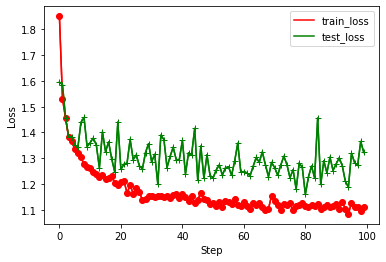

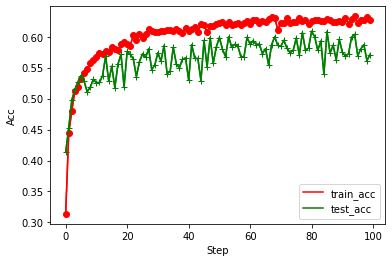

In [26]:
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

### 3. Change optimizer
Adam: RMSProp + Momentum

In [27]:
LOG_PATH="./train4.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
    
model = Net()
if AVAIL_GPUS:
    model = model.cuda()
    
def get_optimizer(epoch):
    return optim.Adam(model.parameters(), weight_decay=5e-4)

BATCH_SIZE = 128
NUM_EPOCHS = 100
print("Model: CNN from Pytorch tutorial")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: Adam")
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: Adam")
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
        
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: CNN from Pytorch tutorial
Batch size: 128
Epoch num: 100
Optimizer: Adam
---------- Training Epoch #0 ----------


391it [00:03, 106.57it/s]

Finish 1 epoch, Train loss: 1.736850, Train acc@1: 0.364000


Test loss: 1.534371, Test acc@1: 0.446400
Saving Best model...			Top1 = 44.640000%
Elapsed time: 5.641493320465088
---------- Training Epoch #1 ----------


391it [00:03, 114.02it/s]

Finish 2 epoch, Train loss: 1.451071, Train acc@1: 0.470600


Test loss: 1.369735, Test acc@1: 0.509500
Saving Best model...			Top1 = 50.950000%
Elapsed time: 10.997160196304321
---------- Training Epoch #2 ----------


391it [00:04, 85.79it/s] 

Finish 3 epoch, Train loss: 1.320438, Train acc@1: 0.525640


Test loss: 1.288167, Test acc@1: 0.536900
Saving Best model...			Top1 = 53.690000%
Elapsed time: 17.498984336853027
---------- Training Epoch #3 ----------


391it [00:03, 110.05it/s]

Finish 4 epoch, Train loss: 1.236484, Train acc@1: 0.557540


Test loss: 1.226065, Test acc@1: 0.563200
Saving Best model...			Top1 = 56.320000%
Elapsed time: 23.08380126953125
---------- Training Epoch #4 ----------


391it [00:04, 93.34it/s] 

Finish 5 epoch, Train loss: 1.176678, Train acc@1: 0.582140


Test loss: 1.202151, Test acc@1: 0.572200
Saving Best model...			Top1 = 57.220000%
Elapsed time: 29.351094722747803
---------- Training Epoch #5 ----------


391it [00:03, 106.90it/s]

Finish 6 epoch, Train loss: 1.125365, Train acc@1: 0.601280


Test loss: 1.150606, Test acc@1: 0.593200
Saving Best model...			Top1 = 59.320000%
Elapsed time: 34.88448691368103
---------- Training Epoch #6 ----------


391it [00:03, 116.98it/s]

Finish 7 epoch, Train loss: 1.083152, Train acc@1: 0.616580


Test loss: 1.137146, Test acc@1: 0.600800
Saving Best model...			Top1 = 60.080000%
Elapsed time: 40.18691039085388
---------- Training Epoch #7 ----------


391it [00:03, 110.91it/s]

Finish 8 epoch, Train loss: 1.049171, Train acc@1: 0.630020


Test loss: 1.121390, Test acc@1: 0.607400
Saving Best model...			Top1 = 60.740000%
Elapsed time: 45.732853174209595
---------- Training Epoch #8 ----------


391it [00:03, 110.74it/s]

Finish 9 epoch, Train loss: 1.017814, Train acc@1: 0.641260


Test loss: 1.076006, Test acc@1: 0.622300
Saving Best model...			Top1 = 62.230000%
Elapsed time: 51.29625225067139
---------- Training Epoch #9 ----------


391it [00:03, 105.80it/s]

Finish 10 epoch, Train loss: 0.984583, Train acc@1: 0.650780


Test loss: 1.095298, Test acc@1: 0.610800
Elapsed time: 57.027886152267456
---------- Training Epoch #10 ----------


391it [00:03, 111.34it/s]

Finish 11 epoch, Train loss: 0.953811, Train acc@1: 0.663420


Test loss: 1.057909, Test acc@1: 0.625500
Saving Best model...			Top1 = 62.550000%
Elapsed time: 62.47080421447754
---------- Training Epoch #11 ----------


391it [00:03, 98.35it/s] 

Finish 12 epoch, Train loss: 0.928020, Train acc@1: 0.673000


Test loss: 1.032687, Test acc@1: 0.638400
Saving Best model...			Top1 = 63.840000%
Elapsed time: 68.39436984062195
---------- Training Epoch #12 ----------


391it [00:03, 111.64it/s]

Finish 13 epoch, Train loss: 0.903577, Train acc@1: 0.683660


Test loss: 1.030329, Test acc@1: 0.638800
Saving Best model...			Top1 = 63.880000%
Elapsed time: 73.84192562103271
---------- Training Epoch #13 ----------


391it [00:03, 103.63it/s]

Finish 14 epoch, Train loss: 0.878057, Train acc@1: 0.690320


Test loss: 1.051733, Test acc@1: 0.636200
Elapsed time: 79.67745757102966
---------- Training Epoch #14 ----------


391it [00:03, 106.41it/s]

Finish 15 epoch, Train loss: 0.856398, Train acc@1: 0.697260


Test loss: 1.015905, Test acc@1: 0.646400
Saving Best model...			Top1 = 64.640000%
Elapsed time: 85.33502650260925
---------- Training Epoch #15 ----------


391it [00:03, 106.34it/s]

Finish 16 epoch, Train loss: 0.835024, Train acc@1: 0.705800


Test loss: 1.013930, Test acc@1: 0.651200
Saving Best model...			Top1 = 65.120000%
Elapsed time: 91.03397703170776
---------- Training Epoch #16 ----------


391it [00:03, 107.82it/s]

Finish 17 epoch, Train loss: 0.815860, Train acc@1: 0.712880


Test loss: 1.010049, Test acc@1: 0.651400
Saving Best model...			Top1 = 65.140000%
Elapsed time: 96.64026045799255
---------- Training Epoch #17 ----------


391it [00:03, 108.03it/s]

Finish 18 epoch, Train loss: 0.801485, Train acc@1: 0.717580


Test loss: 1.026414, Test acc@1: 0.647600
Elapsed time: 102.26748967170715
---------- Training Epoch #18 ----------


391it [00:03, 109.70it/s]

Finish 19 epoch, Train loss: 0.780704, Train acc@1: 0.725600


Test loss: 1.014779, Test acc@1: 0.647100
Elapsed time: 107.88787531852722
---------- Training Epoch #19 ----------


391it [00:03, 110.00it/s]

Finish 20 epoch, Train loss: 0.760903, Train acc@1: 0.733680


Test loss: 1.041186, Test acc@1: 0.646600
Elapsed time: 113.47532343864441
---------- Training Epoch #20 ----------


391it [00:03, 110.41it/s]

Finish 21 epoch, Train loss: 0.745608, Train acc@1: 0.737660


Test loss: 1.010808, Test acc@1: 0.655600
Saving Best model...			Top1 = 65.560000%
Elapsed time: 118.97567391395569
---------- Training Epoch #21 ----------


391it [00:04, 88.89it/s] 

Finish 22 epoch, Train loss: 0.729617, Train acc@1: 0.743820


Test loss: 1.036381, Test acc@1: 0.649800
Elapsed time: 125.34768962860107
---------- Training Epoch #22 ----------


391it [00:03, 110.86it/s]

Finish 23 epoch, Train loss: 0.715326, Train acc@1: 0.746420


Test loss: 1.073295, Test acc@1: 0.642500
Elapsed time: 130.952974319458
---------- Training Epoch #23 ----------


391it [00:03, 112.46it/s]

Finish 24 epoch, Train loss: 0.700927, Train acc@1: 0.752880


Test loss: 1.046618, Test acc@1: 0.654600
Elapsed time: 136.43238878250122
---------- Training Epoch #24 ----------


391it [00:03, 110.25it/s]

Finish 25 epoch, Train loss: 0.686838, Train acc@1: 0.759240


Test loss: 1.039000, Test acc@1: 0.652300
Elapsed time: 141.93869519233704
---------- Training Epoch #25 ----------


391it [00:03, 107.16it/s]

Finish 26 epoch, Train loss: 0.676294, Train acc@1: 0.761800


Test loss: 1.060447, Test acc@1: 0.646000
Elapsed time: 147.61276650428772
---------- Training Epoch #26 ----------


391it [00:03, 110.99it/s]

Finish 27 epoch, Train loss: 0.662789, Train acc@1: 0.766160


Test loss: 1.077200, Test acc@1: 0.650200
Elapsed time: 153.201828956604
---------- Training Epoch #27 ----------


391it [00:03, 108.71it/s]

Finish 28 epoch, Train loss: 0.651069, Train acc@1: 0.770300


Test loss: 1.066709, Test acc@1: 0.654600
Elapsed time: 158.87805104255676
---------- Training Epoch #28 ----------


391it [00:03, 111.33it/s]

Finish 29 epoch, Train loss: 0.639194, Train acc@1: 0.772760


Test loss: 1.065147, Test acc@1: 0.656700
Saving Best model...			Top1 = 65.670000%
Elapsed time: 164.450434923172
---------- Training Epoch #29 ----------


391it [00:03, 111.49it/s]

Finish 30 epoch, Train loss: 0.629093, Train acc@1: 0.776360


Test loss: 1.099386, Test acc@1: 0.645500
Elapsed time: 169.883052110672
---------- Training Epoch #30 ----------


391it [00:03, 109.47it/s]

Finish 31 epoch, Train loss: 0.623107, Train acc@1: 0.779180


Test loss: 1.081395, Test acc@1: 0.656900
Saving Best model...			Top1 = 65.690000%
Elapsed time: 175.4442641735077
---------- Training Epoch #31 ----------


391it [00:03, 109.03it/s]

Finish 32 epoch, Train loss: 0.609131, Train acc@1: 0.782980


Test loss: 1.098968, Test acc@1: 0.651500
Elapsed time: 181.08459162712097
---------- Training Epoch #32 ----------


391it [00:03, 109.24it/s]

Finish 33 epoch, Train loss: 0.599521, Train acc@1: 0.787200


Test loss: 1.132489, Test acc@1: 0.643200
Elapsed time: 186.6272439956665
---------- Training Epoch #33 ----------


391it [00:04, 93.00it/s] 

Finish 34 epoch, Train loss: 0.591480, Train acc@1: 0.790300


Test loss: 1.162046, Test acc@1: 0.639100
Elapsed time: 192.90860605239868
---------- Training Epoch #34 ----------


391it [00:03, 111.98it/s]

Finish 35 epoch, Train loss: 0.578266, Train acc@1: 0.793220


Test loss: 1.141284, Test acc@1: 0.639400
Elapsed time: 198.43046307563782
---------- Training Epoch #35 ----------


391it [00:03, 112.57it/s]

Finish 36 epoch, Train loss: 0.573099, Train acc@1: 0.794380


Test loss: 1.215522, Test acc@1: 0.640200
Elapsed time: 203.9084916114807
---------- Training Epoch #36 ----------


391it [00:03, 109.30it/s]

Finish 37 epoch, Train loss: 0.559034, Train acc@1: 0.801140


Test loss: 1.165586, Test acc@1: 0.647400
Elapsed time: 209.45714211463928
---------- Training Epoch #37 ----------


391it [00:03, 110.14it/s]

Finish 38 epoch, Train loss: 0.550302, Train acc@1: 0.804440


Test loss: 1.193065, Test acc@1: 0.645800
Elapsed time: 214.98011183738708
---------- Training Epoch #38 ----------


391it [00:03, 111.15it/s]

Finish 39 epoch, Train loss: 0.544109, Train acc@1: 0.805200


Test loss: 1.181701, Test acc@1: 0.650100
Elapsed time: 220.4436638355255
---------- Training Epoch #39 ----------


391it [00:03, 106.80it/s]

Finish 40 epoch, Train loss: 0.539766, Train acc@1: 0.807620


Test loss: 1.196047, Test acc@1: 0.642100
Elapsed time: 226.04621648788452
---------- Training Epoch #40 ----------


391it [00:03, 107.51it/s]


Finish 41 epoch, Train loss: 0.525785, Train acc@1: 0.813040
Test loss: 1.202711, Test acc@1: 0.643800
Elapsed time: 231.6764943599701
---------- Training Epoch #41 ----------


391it [00:03, 112.97it/s]

Finish 42 epoch, Train loss: 0.516483, Train acc@1: 0.816440


Test loss: 1.201539, Test acc@1: 0.648600
Elapsed time: 237.1531105041504
---------- Training Epoch #42 ----------


391it [00:03, 110.69it/s]

Finish 43 epoch, Train loss: 0.518474, Train acc@1: 0.813620


Test loss: 1.184099, Test acc@1: 0.651800
Elapsed time: 242.66780972480774
---------- Training Epoch #43 ----------


391it [00:03, 111.65it/s]

Finish 44 epoch, Train loss: 0.507468, Train acc@1: 0.819060


Test loss: 1.291227, Test acc@1: 0.631500
Elapsed time: 248.17634344100952
---------- Training Epoch #44 ----------


391it [00:03, 109.35it/s]

Finish 45 epoch, Train loss: 0.498451, Train acc@1: 0.822320


Test loss: 1.241755, Test acc@1: 0.645500
Elapsed time: 253.86514449119568
---------- Training Epoch #45 ----------


391it [00:03, 110.86it/s]

Finish 46 epoch, Train loss: 0.493183, Train acc@1: 0.823800


Test loss: 1.248063, Test acc@1: 0.648600
Elapsed time: 259.41401743888855
---------- Training Epoch #46 ----------


391it [00:03, 109.40it/s]

Finish 47 epoch, Train loss: 0.485242, Train acc@1: 0.828100


Test loss: 1.280627, Test acc@1: 0.646000
Elapsed time: 264.8971507549286
---------- Training Epoch #47 ----------


391it [00:03, 107.85it/s]

Finish 48 epoch, Train loss: 0.474210, Train acc@1: 0.831900


Test loss: 1.291429, Test acc@1: 0.636600
Elapsed time: 270.4983768463135
---------- Training Epoch #48 ----------


391it [00:03, 108.00it/s]

Finish 49 epoch, Train loss: 0.472590, Train acc@1: 0.830660


Test loss: 1.298147, Test acc@1: 0.644300
Elapsed time: 276.1168282032013
---------- Training Epoch #49 ----------


391it [00:03, 112.74it/s]

Finish 50 epoch, Train loss: 0.466285, Train acc@1: 0.831340


Test loss: 1.351270, Test acc@1: 0.634400
Elapsed time: 281.54550290107727
---------- Training Epoch #50 ----------


391it [00:03, 106.74it/s]

Finish 51 epoch, Train loss: 0.460386, Train acc@1: 0.835700


Test loss: 1.347696, Test acc@1: 0.637300
Elapsed time: 287.1859202384949
---------- Training Epoch #51 ----------


391it [00:03, 112.85it/s]

Finish 52 epoch, Train loss: 0.455527, Train acc@1: 0.836200


Test loss: 1.349099, Test acc@1: 0.636100
Elapsed time: 292.67563819885254
---------- Training Epoch #52 ----------


391it [00:03, 111.07it/s]

Finish 53 epoch, Train loss: 0.448657, Train acc@1: 0.838620


Test loss: 1.334301, Test acc@1: 0.641300
Elapsed time: 298.1858220100403
---------- Training Epoch #53 ----------


391it [00:03, 111.11it/s]

Finish 54 epoch, Train loss: 0.440654, Train acc@1: 0.843280


Test loss: 1.353648, Test acc@1: 0.638600
Elapsed time: 303.6699917316437
---------- Training Epoch #54 ----------


391it [00:03, 111.25it/s]

Finish 55 epoch, Train loss: 0.434550, Train acc@1: 0.843780


Test loss: 1.379150, Test acc@1: 0.639100
Elapsed time: 309.1157155036926
---------- Training Epoch #55 ----------


391it [00:03, 109.72it/s]

Finish 56 epoch, Train loss: 0.431248, Train acc@1: 0.846540


Test loss: 1.360530, Test acc@1: 0.638100
Elapsed time: 314.62699151039124
---------- Training Epoch #56 ----------


391it [00:03, 108.43it/s]

Finish 57 epoch, Train loss: 0.429791, Train acc@1: 0.846440


Test loss: 1.391016, Test acc@1: 0.640100
Elapsed time: 320.240761756897
---------- Training Epoch #57 ----------


391it [00:03, 110.73it/s]

Finish 58 epoch, Train loss: 0.426543, Train acc@1: 0.846940


Test loss: 1.412300, Test acc@1: 0.636300
Elapsed time: 325.832368850708
---------- Training Epoch #58 ----------


391it [00:03, 110.80it/s]

Finish 59 epoch, Train loss: 0.417795, Train acc@1: 0.850680


Test loss: 1.391875, Test acc@1: 0.638400
Elapsed time: 331.37172627449036
---------- Training Epoch #59 ----------


391it [00:03, 110.68it/s]

Finish 60 epoch, Train loss: 0.405828, Train acc@1: 0.854980


Test loss: 1.474617, Test acc@1: 0.639700
Elapsed time: 336.8793988227844
---------- Training Epoch #60 ----------


391it [00:03, 109.33it/s]

Finish 61 epoch, Train loss: 0.402984, Train acc@1: 0.854500


Test loss: 1.480608, Test acc@1: 0.629500
Elapsed time: 342.45475697517395
---------- Training Epoch #61 ----------


391it [00:03, 109.89it/s]


Finish 62 epoch, Train loss: 0.398006, Train acc@1: 0.856980
Test loss: 1.469146, Test acc@1: 0.628500
Elapsed time: 348.0624294281006
---------- Training Epoch #62 ----------


391it [00:03, 110.79it/s]

Finish 63 epoch, Train loss: 0.394247, Train acc@1: 0.857700


Test loss: 1.534403, Test acc@1: 0.628800
Elapsed time: 353.56557512283325
---------- Training Epoch #63 ----------


391it [00:03, 110.28it/s]

Finish 64 epoch, Train loss: 0.392130, Train acc@1: 0.858540


Test loss: 1.506961, Test acc@1: 0.631400
Elapsed time: 359.06819581985474
---------- Training Epoch #64 ----------


391it [00:03, 111.00it/s]

Finish 65 epoch, Train loss: 0.385846, Train acc@1: 0.861240


Test loss: 1.537594, Test acc@1: 0.624800
Elapsed time: 364.5825765132904
---------- Training Epoch #65 ----------


391it [00:03, 109.90it/s]

Finish 66 epoch, Train loss: 0.385967, Train acc@1: 0.861440


Test loss: 1.514904, Test acc@1: 0.632100
Elapsed time: 370.2039909362793
---------- Training Epoch #66 ----------


391it [00:03, 108.19it/s]

Finish 67 epoch, Train loss: 0.375281, Train acc@1: 0.864340


Test loss: 1.555238, Test acc@1: 0.628600
Elapsed time: 375.70067143440247
---------- Training Epoch #67 ----------


391it [00:03, 110.79it/s]

Finish 68 epoch, Train loss: 0.374868, Train acc@1: 0.865560


Test loss: 1.568746, Test acc@1: 0.626100
Elapsed time: 381.1055805683136
---------- Training Epoch #68 ----------


391it [00:03, 110.49it/s]

Finish 69 epoch, Train loss: 0.372941, Train acc@1: 0.866300


Test loss: 1.550712, Test acc@1: 0.632100
Elapsed time: 386.7063491344452
---------- Training Epoch #69 ----------


391it [00:03, 108.49it/s]

Finish 70 epoch, Train loss: 0.362252, Train acc@1: 0.870880


Test loss: 1.563916, Test acc@1: 0.632200
Elapsed time: 392.2695391178131
---------- Training Epoch #70 ----------


391it [00:03, 109.95it/s]

Finish 71 epoch, Train loss: 0.366660, Train acc@1: 0.867220


Test loss: 1.609238, Test acc@1: 0.624700
Elapsed time: 397.8913269042969
---------- Training Epoch #71 ----------


391it [00:03, 109.88it/s]

Finish 72 epoch, Train loss: 0.357351, Train acc@1: 0.871480


Test loss: 1.605961, Test acc@1: 0.627300
Elapsed time: 403.3937346935272
---------- Training Epoch #72 ----------


391it [00:03, 108.22it/s]

Finish 73 epoch, Train loss: 0.360999, Train acc@1: 0.870680


Test loss: 1.633642, Test acc@1: 0.631700
Elapsed time: 409.0259940624237
---------- Training Epoch #73 ----------


391it [00:03, 109.10it/s]

Finish 74 epoch, Train loss: 0.353555, Train acc@1: 0.873080


Test loss: 1.651790, Test acc@1: 0.627400
Elapsed time: 414.59137630462646
---------- Training Epoch #74 ----------


391it [00:03, 110.38it/s]

Finish 75 epoch, Train loss: 0.344731, Train acc@1: 0.876080


Test loss: 1.650573, Test acc@1: 0.625900
Elapsed time: 420.0648787021637
---------- Training Epoch #75 ----------


391it [00:03, 111.03it/s]

Finish 76 epoch, Train loss: 0.348487, Train acc@1: 0.874240


Test loss: 1.634916, Test acc@1: 0.625500
Elapsed time: 425.5466191768646
---------- Training Epoch #76 ----------


391it [00:03, 110.65it/s]

Finish 77 epoch, Train loss: 0.339331, Train acc@1: 0.878580


Test loss: 1.667586, Test acc@1: 0.620300
Elapsed time: 431.0278606414795
---------- Training Epoch #77 ----------


391it [00:03, 110.60it/s]

Finish 78 epoch, Train loss: 0.337699, Train acc@1: 0.877940


Test loss: 1.671913, Test acc@1: 0.626900
Elapsed time: 436.55105662345886
---------- Training Epoch #78 ----------


391it [00:03, 111.31it/s]

Finish 79 epoch, Train loss: 0.335170, Train acc@1: 0.877680


Test loss: 1.718665, Test acc@1: 0.624400
Elapsed time: 442.1297264099121
---------- Training Epoch #79 ----------


391it [00:03, 110.69it/s]

Finish 80 epoch, Train loss: 0.330799, Train acc@1: 0.881320


Test loss: 1.694404, Test acc@1: 0.626300
Elapsed time: 447.67555117607117
---------- Training Epoch #80 ----------


391it [00:03, 109.37it/s]

Finish 81 epoch, Train loss: 0.322244, Train acc@1: 0.884600


Test loss: 1.716146, Test acc@1: 0.630800
Elapsed time: 453.23932933807373
---------- Training Epoch #81 ----------


391it [00:03, 110.08it/s]

Finish 82 epoch, Train loss: 0.321530, Train acc@1: 0.884900


Test loss: 1.746139, Test acc@1: 0.627200
Elapsed time: 458.7851071357727
---------- Training Epoch #82 ----------


391it [00:03, 110.15it/s]

Finish 83 epoch, Train loss: 0.326520, Train acc@1: 0.881920


Test loss: 1.786853, Test acc@1: 0.620000
Elapsed time: 464.36858463287354
---------- Training Epoch #83 ----------


391it [00:03, 109.70it/s]

Finish 84 epoch, Train loss: 0.313470, Train acc@1: 0.887880


Test loss: 1.764617, Test acc@1: 0.625200
Elapsed time: 469.88130354881287
---------- Training Epoch #84 ----------


391it [00:03, 110.44it/s]

Finish 85 epoch, Train loss: 0.310784, Train acc@1: 0.888500


Test loss: 1.774306, Test acc@1: 0.625400
Elapsed time: 475.41176748275757
---------- Training Epoch #85 ----------


391it [00:03, 107.93it/s]

Finish 86 epoch, Train loss: 0.316188, Train acc@1: 0.885580


Test loss: 1.789382, Test acc@1: 0.626100
Elapsed time: 481.02930998802185
---------- Training Epoch #86 ----------


391it [00:03, 107.50it/s]

Finish 87 epoch, Train loss: 0.311178, Train acc@1: 0.887440


Test loss: 1.793163, Test acc@1: 0.624400
Elapsed time: 486.7637794017792
---------- Training Epoch #87 ----------


391it [00:03, 110.53it/s]

Finish 88 epoch, Train loss: 0.304848, Train acc@1: 0.890300


Test loss: 1.808687, Test acc@1: 0.619600
Elapsed time: 492.305655002594
---------- Training Epoch #88 ----------


391it [00:03, 111.82it/s]

Finish 89 epoch, Train loss: 0.302688, Train acc@1: 0.889740


Test loss: 1.810737, Test acc@1: 0.622600
Elapsed time: 497.78529167175293
---------- Training Epoch #89 ----------


391it [00:03, 108.85it/s]

Finish 90 epoch, Train loss: 0.302434, Train acc@1: 0.889040


Test loss: 1.841285, Test acc@1: 0.619600
Elapsed time: 503.44736981391907
---------- Training Epoch #90 ----------


391it [00:03, 105.40it/s]

Finish 91 epoch, Train loss: 0.296959, Train acc@1: 0.892520


Test loss: 1.881972, Test acc@1: 0.619700
Elapsed time: 509.08781838417053
---------- Training Epoch #91 ----------


391it [00:03, 110.83it/s]

Finish 92 epoch, Train loss: 0.292087, Train acc@1: 0.894720


Test loss: 1.929275, Test acc@1: 0.625200
Elapsed time: 514.5120358467102
---------- Training Epoch #92 ----------


391it [00:03, 111.39it/s]

Finish 93 epoch, Train loss: 0.293217, Train acc@1: 0.894900


Test loss: 1.892783, Test acc@1: 0.616700
Elapsed time: 519.9875612258911
---------- Training Epoch #93 ----------


391it [00:03, 110.43it/s]

Finish 94 epoch, Train loss: 0.285559, Train acc@1: 0.896160


Test loss: 1.888949, Test acc@1: 0.623300
Elapsed time: 525.562046289444
---------- Training Epoch #94 ----------


391it [00:03, 110.42it/s]

Finish 95 epoch, Train loss: 0.290206, Train acc@1: 0.895880


Test loss: 1.935767, Test acc@1: 0.608100
Elapsed time: 531.0299663543701
---------- Training Epoch #95 ----------


391it [00:03, 108.02it/s]

Finish 96 epoch, Train loss: 0.285198, Train acc@1: 0.896440


Test loss: 1.916626, Test acc@1: 0.618400
Elapsed time: 536.6615755558014
---------- Training Epoch #96 ----------


391it [00:03, 108.28it/s]

Finish 97 epoch, Train loss: 0.282471, Train acc@1: 0.897520


Test loss: 1.891267, Test acc@1: 0.620500
Elapsed time: 542.2623422145844
---------- Training Epoch #97 ----------


391it [00:03, 109.15it/s]

Finish 98 epoch, Train loss: 0.281327, Train acc@1: 0.898840


Test loss: 1.942537, Test acc@1: 0.613500
Elapsed time: 547.7956221103668
---------- Training Epoch #98 ----------


391it [00:03, 111.37it/s]

Finish 99 epoch, Train loss: 0.272248, Train acc@1: 0.900880


Test loss: 1.962652, Test acc@1: 0.620600
Elapsed time: 553.3501348495483
---------- Training Epoch #99 ----------


391it [00:03, 106.21it/s]

Finish 100 epoch, Train loss: 0.284098, Train acc@1: 0.896800


Test loss: 1.950307, Test acc@1: 0.616500
Elapsed time: 558.9376587867737

Test results: Acc@1 = 65.690000%


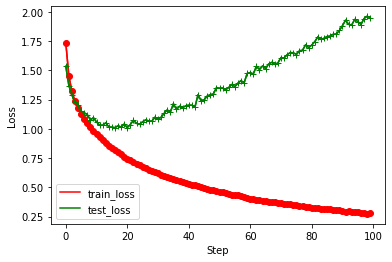

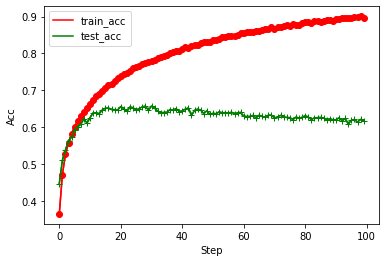

In [28]:
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

### 4. Batch size
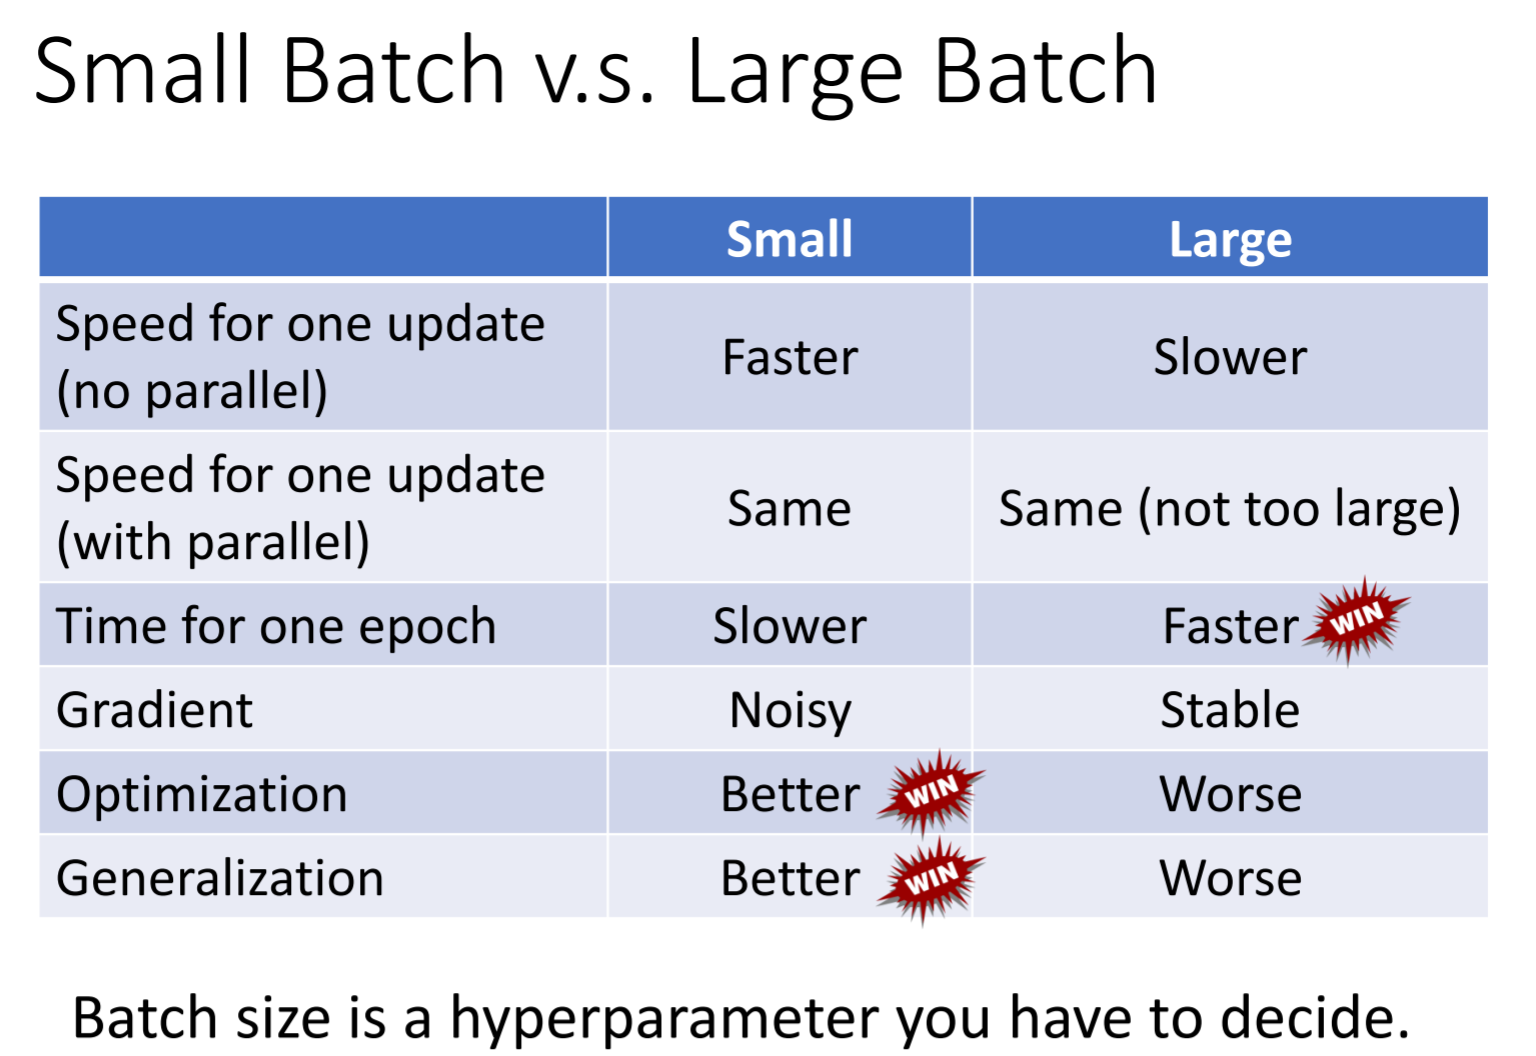

In [32]:
train_loss_record_lst = []
test_loss_record_lst = []
train_acc_record_lst = []
test_acc_record_lst = []

BATCH_SIZE = 32
log_id = 5
while BATCH_SIZE <= 256: 
    train_dataset = datasets.CIFAR10('./data', train=True, transform=transform_train, download=True)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    test_dataset = datasets.CIFAR10('./data', train=False, transform=transform_test, download=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    LOG_PATH="./train" + str(log_id) + ".log"
    if os.path.exists(LOG_PATH):
        os.remove(LOG_PATH)

    model = Net()
    if AVAIL_GPUS:
        model = model.cuda()

    def get_optimizer(epoch):
        return optim.Adam(model.parameters(), weight_decay=5e-4)

    NUM_EPOCHS = 100
    print("Model: CNN from Pytorch tutorial")
    print("Batch size: %d" % (BATCH_SIZE))
    print("Epoch num: %d" % (NUM_EPOCHS))
    print("Optimizer: Adam")
    with open(LOG_PATH, "a") as f:
        f.write("Model: CNN from Pytorch tutorial")
        f.write("\n")
        f.write("Batch size: %d" % (BATCH_SIZE))
        f.write("\n")
        f.write("Epoch num: %d" % (NUM_EPOCHS))
        f.write("\n")
        f.write("Optimizer: Adam")
        f.write("\n")

    train_loss_record = []
    test_loss_record = []
    train_acc_record = []
    test_acc_record = []
    best_acc = 0
    elapsed_time = 0
    for i in range(NUM_EPOCHS):
        start_time = time.time()

        print("-"*10, "Training Epoch #%d" % (i), "-"*10)
        with open(LOG_PATH, "a") as f:
            f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
            f.write("\n")

        train(i)
        test(i)

        epoch_time = time.time() - start_time
        elapsed_time += epoch_time
        print('Elapsed time: %s' % str(elapsed_time))
        with open(LOG_PATH, "a") as f:
            f.write('Elapsed time: %s' % str(elapsed_time))
            f.write("\n")
    print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    with open(LOG_PATH, "a") as f:
        f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
        f.write("\n")
        
    log_id += 1
    BATCH_SIZE *= 2
    
    train_loss_record_lst.append(train_loss_record)
    test_loss_record_lst.append(test_loss_record)
    train_acc_record_lst.append(train_acc_record)
    test_acc_record_lst.append(test_acc_record)

Files already downloaded and verified
Files already downloaded and verified
Model: CNN from Pytorch tutorial
Batch size: 32
Epoch num: 100
Optimizer: Adam
---------- Training Epoch #0 ----------


1563it [00:11, 133.72it/s]

Finish 1 epoch, Train loss: 1.606888, Train acc@1: 0.414040


Test loss: 1.403616, Test acc@1: 0.488700
Saving Best model...			Top1 = 48.870000%
Elapsed time: 14.021742820739746
---------- Training Epoch #1 ----------


1563it [00:11, 135.61it/s]

Finish 2 epoch, Train loss: 1.308924, Train acc@1: 0.530340


Test loss: 1.276083, Test acc@1: 0.540300
Saving Best model...			Top1 = 54.030000%
Elapsed time: 28.075013875961304
---------- Training Epoch #2 ----------


1563it [00:11, 134.77it/s]

Finish 3 epoch, Train loss: 1.196181, Train acc@1: 0.574640


Test loss: 1.208162, Test acc@1: 0.570800
Saving Best model...			Top1 = 57.080000%
Elapsed time: 42.10106658935547
---------- Training Epoch #3 ----------


1563it [00:11, 135.98it/s]

Finish 4 epoch, Train loss: 1.121563, Train acc@1: 0.604200


Test loss: 1.158058, Test acc@1: 0.591800
Saving Best model...			Top1 = 59.180000%
Elapsed time: 56.05138826370239
---------- Training Epoch #4 ----------


1563it [00:11, 134.11it/s]

Finish 5 epoch, Train loss: 1.063183, Train acc@1: 0.622820


Test loss: 1.130995, Test acc@1: 0.605000
Saving Best model...			Top1 = 60.500000%
Elapsed time: 70.17295455932617
---------- Training Epoch #5 ----------


1563it [00:11, 139.38it/s]

Finish 6 epoch, Train loss: 1.014445, Train acc@1: 0.641860


Test loss: 1.114854, Test acc@1: 0.610500
Saving Best model...			Top1 = 61.050000%
Elapsed time: 83.82322764396667
---------- Training Epoch #6 ----------


1563it [00:11, 136.83it/s]

Finish 7 epoch, Train loss: 0.972533, Train acc@1: 0.657600


Test loss: 1.071864, Test acc@1: 0.621500
Saving Best model...			Top1 = 62.150000%
Elapsed time: 97.77748346328735
---------- Training Epoch #7 ----------


1563it [00:11, 138.05it/s]


Finish 8 epoch, Train loss: 0.942071, Train acc@1: 0.666680
Test loss: 1.083933, Test acc@1: 0.615500
Elapsed time: 111.7111132144928
---------- Training Epoch #8 ----------


1563it [00:11, 135.58it/s]

Finish 9 epoch, Train loss: 0.914421, Train acc@1: 0.678700


Test loss: 1.070229, Test acc@1: 0.629300
Saving Best model...			Top1 = 62.930000%
Elapsed time: 125.65260171890259
---------- Training Epoch #9 ----------


1563it [00:11, 135.16it/s]

Finish 10 epoch, Train loss: 0.880077, Train acc@1: 0.689980


Test loss: 1.063239, Test acc@1: 0.629500
Saving Best model...			Top1 = 62.950000%
Elapsed time: 139.74011278152466
---------- Training Epoch #10 ----------


1563it [00:11, 136.34it/s]

Finish 11 epoch, Train loss: 0.858702, Train acc@1: 0.698100


Test loss: 1.103411, Test acc@1: 0.622700
Elapsed time: 153.76742386817932
---------- Training Epoch #11 ----------


1563it [00:11, 133.93it/s]

Finish 12 epoch, Train loss: 0.836091, Train acc@1: 0.706140


Test loss: 1.087440, Test acc@1: 0.627800
Elapsed time: 167.88956665992737
---------- Training Epoch #12 ----------


1563it [00:11, 135.06it/s]

Finish 13 epoch, Train loss: 0.815217, Train acc@1: 0.710740


Test loss: 1.081448, Test acc@1: 0.629800
Saving Best model...			Top1 = 62.980000%
Elapsed time: 181.90073657035828
---------- Training Epoch #13 ----------


1563it [00:11, 137.67it/s]

Finish 14 epoch, Train loss: 0.794529, Train acc@1: 0.717960


Test loss: 1.072032, Test acc@1: 0.639200
Saving Best model...			Top1 = 63.920000%
Elapsed time: 195.65232133865356
---------- Training Epoch #14 ----------


1563it [00:11, 136.65it/s]

Finish 15 epoch, Train loss: 0.775368, Train acc@1: 0.726740


Test loss: 1.067228, Test acc@1: 0.635100
Elapsed time: 209.53063035011292
---------- Training Epoch #15 ----------


1563it [00:11, 138.13it/s]

Finish 16 epoch, Train loss: 0.759153, Train acc@1: 0.733200


Test loss: 1.085587, Test acc@1: 0.635300
Elapsed time: 223.29603934288025
---------- Training Epoch #16 ----------


1563it [00:11, 138.61it/s]

Finish 17 epoch, Train loss: 0.746260, Train acc@1: 0.737100


Test loss: 1.086644, Test acc@1: 0.635000
Elapsed time: 236.9254412651062
---------- Training Epoch #17 ----------


1563it [00:11, 138.60it/s]

Finish 18 epoch, Train loss: 0.732670, Train acc@1: 0.742300


Test loss: 1.106243, Test acc@1: 0.625600
Elapsed time: 250.64822912216187
---------- Training Epoch #18 ----------


1563it [00:11, 138.01it/s]

Finish 19 epoch, Train loss: 0.720709, Train acc@1: 0.743760


Test loss: 1.122081, Test acc@1: 0.634100
Elapsed time: 264.39738965034485
---------- Training Epoch #19 ----------


1563it [00:11, 136.06it/s]

Finish 20 epoch, Train loss: 0.703941, Train acc@1: 0.749840


Test loss: 1.138050, Test acc@1: 0.629100
Elapsed time: 278.1693980693817
---------- Training Epoch #20 ----------


1563it [00:11, 136.99it/s]

Finish 21 epoch, Train loss: 0.696004, Train acc@1: 0.753760


Test loss: 1.099490, Test acc@1: 0.635900
Elapsed time: 292.0760295391083
---------- Training Epoch #21 ----------


1563it [00:11, 135.21it/s]

Finish 22 epoch, Train loss: 0.686393, Train acc@1: 0.756820


Test loss: 1.127568, Test acc@1: 0.632400
Elapsed time: 306.07228565216064
---------- Training Epoch #22 ----------


1563it [00:11, 137.12it/s]

Finish 23 epoch, Train loss: 0.668601, Train acc@1: 0.762340


Test loss: 1.153813, Test acc@1: 0.629600
Elapsed time: 319.99290347099304
---------- Training Epoch #23 ----------


1563it [00:11, 135.35it/s]

Finish 24 epoch, Train loss: 0.661135, Train acc@1: 0.766060


Test loss: 1.172985, Test acc@1: 0.632700
Elapsed time: 333.99444007873535
---------- Training Epoch #24 ----------


1563it [00:11, 136.85it/s]

Finish 25 epoch, Train loss: 0.654361, Train acc@1: 0.766860


Test loss: 1.154828, Test acc@1: 0.631000
Elapsed time: 347.954717874527
---------- Training Epoch #25 ----------


1563it [00:11, 133.86it/s]

Finish 26 epoch, Train loss: 0.647280, Train acc@1: 0.770380


Test loss: 1.160241, Test acc@1: 0.632300
Elapsed time: 362.06158995628357
---------- Training Epoch #26 ----------


1563it [00:11, 139.62it/s]

Finish 27 epoch, Train loss: 0.639203, Train acc@1: 0.774200


Test loss: 1.195439, Test acc@1: 0.628300
Elapsed time: 375.6933436393738
---------- Training Epoch #27 ----------


1563it [00:11, 137.77it/s]

Finish 28 epoch, Train loss: 0.625832, Train acc@1: 0.775280


Test loss: 1.187293, Test acc@1: 0.627000
Elapsed time: 389.4804210662842
---------- Training Epoch #28 ----------


1563it [00:11, 139.59it/s]

Finish 29 epoch, Train loss: 0.621434, Train acc@1: 0.777040


Test loss: 1.179670, Test acc@1: 0.632600
Elapsed time: 403.0351679325104
---------- Training Epoch #29 ----------


1563it [00:11, 135.45it/s]

Finish 30 epoch, Train loss: 0.618279, Train acc@1: 0.780980


Test loss: 1.190436, Test acc@1: 0.625200
Elapsed time: 416.95210814476013
---------- Training Epoch #30 ----------


1563it [00:11, 136.48it/s]

Finish 31 epoch, Train loss: 0.605102, Train acc@1: 0.785020


Test loss: 1.212127, Test acc@1: 0.623000
Elapsed time: 430.89438676834106
---------- Training Epoch #31 ----------


1563it [00:11, 139.09it/s]

Finish 32 epoch, Train loss: 0.604762, Train acc@1: 0.783740


Test loss: 1.223252, Test acc@1: 0.617500
Elapsed time: 444.5558397769928
---------- Training Epoch #32 ----------


1563it [00:11, 135.57it/s]

Finish 33 epoch, Train loss: 0.594284, Train acc@1: 0.788080


Test loss: 1.231930, Test acc@1: 0.624100
Elapsed time: 458.5560326576233
---------- Training Epoch #33 ----------


1563it [00:11, 136.13it/s]

Finish 34 epoch, Train loss: 0.586723, Train acc@1: 0.792260


Test loss: 1.237563, Test acc@1: 0.628600
Elapsed time: 472.4466998577118
---------- Training Epoch #34 ----------


1563it [00:11, 137.00it/s]

Finish 35 epoch, Train loss: 0.582837, Train acc@1: 0.791700


Test loss: 1.246990, Test acc@1: 0.623400
Elapsed time: 486.32530188560486
---------- Training Epoch #35 ----------


1563it [00:11, 137.31it/s]

Finish 36 epoch, Train loss: 0.575609, Train acc@1: 0.794220


Test loss: 1.262363, Test acc@1: 0.621800
Elapsed time: 500.17825293540955
---------- Training Epoch #36 ----------


1563it [00:11, 135.32it/s]

Finish 37 epoch, Train loss: 0.573933, Train acc@1: 0.795140


Test loss: 1.249919, Test acc@1: 0.623000
Elapsed time: 514.1919410228729
---------- Training Epoch #37 ----------


1563it [00:11, 137.71it/s]

Finish 38 epoch, Train loss: 0.565293, Train acc@1: 0.797580


Test loss: 1.254915, Test acc@1: 0.623500
Elapsed time: 527.9421536922455
---------- Training Epoch #38 ----------


1563it [00:11, 136.10it/s]

Finish 39 epoch, Train loss: 0.558486, Train acc@1: 0.798680


Test loss: 1.287386, Test acc@1: 0.625200
Elapsed time: 541.8503835201263
---------- Training Epoch #39 ----------


1563it [00:11, 136.16it/s]

Finish 40 epoch, Train loss: 0.557655, Train acc@1: 0.799000


Test loss: 1.330278, Test acc@1: 0.615900
Elapsed time: 555.7282881736755
---------- Training Epoch #40 ----------


1563it [00:11, 136.22it/s]

Finish 41 epoch, Train loss: 0.551751, Train acc@1: 0.801860


Test loss: 1.279442, Test acc@1: 0.625600
Elapsed time: 569.6147885322571
---------- Training Epoch #41 ----------


1563it [00:11, 137.79it/s]

Finish 42 epoch, Train loss: 0.546686, Train acc@1: 0.804040


Test loss: 1.301474, Test acc@1: 0.626100
Elapsed time: 583.4098749160767
---------- Training Epoch #42 ----------


1563it [00:11, 138.85it/s]

Finish 43 epoch, Train loss: 0.540237, Train acc@1: 0.807200


Test loss: 1.342142, Test acc@1: 0.618300
Elapsed time: 597.1080987453461
---------- Training Epoch #43 ----------


1563it [00:11, 137.02it/s]

Finish 44 epoch, Train loss: 0.539685, Train acc@1: 0.805160


Test loss: 1.338669, Test acc@1: 0.622800
Elapsed time: 610.9034268856049
---------- Training Epoch #44 ----------


1563it [00:11, 136.68it/s]

Finish 45 epoch, Train loss: 0.535290, Train acc@1: 0.807160


Test loss: 1.307607, Test acc@1: 0.622400
Elapsed time: 624.8012852668762
---------- Training Epoch #45 ----------


1563it [00:11, 138.17it/s]

Finish 46 epoch, Train loss: 0.529194, Train acc@1: 0.810740


Test loss: 1.316963, Test acc@1: 0.624000
Elapsed time: 638.5085916519165
---------- Training Epoch #46 ----------


1563it [00:11, 133.55it/s]

Finish 47 epoch, Train loss: 0.528594, Train acc@1: 0.810740


Test loss: 1.333462, Test acc@1: 0.620600
Elapsed time: 652.6471710205078
---------- Training Epoch #47 ----------


1563it [00:11, 136.86it/s]

Finish 48 epoch, Train loss: 0.520362, Train acc@1: 0.812980


Test loss: 1.330487, Test acc@1: 0.623400
Elapsed time: 666.5819790363312
---------- Training Epoch #48 ----------


1563it [00:11, 136.08it/s]

Finish 49 epoch, Train loss: 0.520831, Train acc@1: 0.810880


Test loss: 1.365961, Test acc@1: 0.622300
Elapsed time: 680.5025935173035
---------- Training Epoch #49 ----------


1563it [00:11, 140.54it/s]

Finish 50 epoch, Train loss: 0.517797, Train acc@1: 0.812360


Test loss: 1.392521, Test acc@1: 0.622000
Elapsed time: 694.0680665969849
---------- Training Epoch #50 ----------


1563it [00:11, 137.55it/s]

Finish 51 epoch, Train loss: 0.507282, Train acc@1: 0.816540


Test loss: 1.359252, Test acc@1: 0.619400
Elapsed time: 707.8802814483643
---------- Training Epoch #51 ----------


1563it [00:11, 136.54it/s]

Finish 52 epoch, Train loss: 0.507504, Train acc@1: 0.817980


Test loss: 1.360290, Test acc@1: 0.618100
Elapsed time: 721.8179247379303
---------- Training Epoch #52 ----------


1563it [00:11, 139.03it/s]

Finish 53 epoch, Train loss: 0.508448, Train acc@1: 0.814480


Test loss: 1.444825, Test acc@1: 0.618700
Elapsed time: 735.4837260246277
---------- Training Epoch #53 ----------


1563it [00:11, 136.71it/s]

Finish 54 epoch, Train loss: 0.498908, Train acc@1: 0.819960


Test loss: 1.395238, Test acc@1: 0.619900
Elapsed time: 749.3149020671844
---------- Training Epoch #54 ----------


1563it [00:11, 135.52it/s]

Finish 55 epoch, Train loss: 0.497352, Train acc@1: 0.818500


Test loss: 1.414372, Test acc@1: 0.620600
Elapsed time: 763.2486915588379
---------- Training Epoch #55 ----------


1563it [00:11, 137.33it/s]

Finish 56 epoch, Train loss: 0.497141, Train acc@1: 0.820120


Test loss: 1.428400, Test acc@1: 0.618700
Elapsed time: 777.0358579158783
---------- Training Epoch #56 ----------


1563it [00:11, 139.58it/s]

Finish 57 epoch, Train loss: 0.491709, Train acc@1: 0.821200


Test loss: 1.414977, Test acc@1: 0.610900
Elapsed time: 790.6029515266418
---------- Training Epoch #57 ----------


1563it [00:11, 138.63it/s]


Finish 58 epoch, Train loss: 0.491303, Train acc@1: 0.822060
Test loss: 1.433365, Test acc@1: 0.610800
Elapsed time: 804.3369851112366
---------- Training Epoch #58 ----------


1563it [00:11, 134.16it/s]

Finish 59 epoch, Train loss: 0.490481, Train acc@1: 0.821820


Test loss: 1.424518, Test acc@1: 0.612300
Elapsed time: 818.5179975032806
---------- Training Epoch #59 ----------


1563it [00:11, 135.32it/s]

Finish 60 epoch, Train loss: 0.483292, Train acc@1: 0.825160


Test loss: 1.477922, Test acc@1: 0.612600
Elapsed time: 832.4351658821106
---------- Training Epoch #60 ----------


1563it [00:11, 137.08it/s]


Finish 61 epoch, Train loss: 0.479387, Train acc@1: 0.827000
Test loss: 1.457154, Test acc@1: 0.608900
Elapsed time: 846.2707650661469
---------- Training Epoch #61 ----------


1563it [00:11, 140.06it/s]

Finish 62 epoch, Train loss: 0.479764, Train acc@1: 0.825520


Test loss: 1.462920, Test acc@1: 0.608500
Elapsed time: 859.8957829475403
---------- Training Epoch #62 ----------


1563it [00:11, 138.25it/s]

Finish 63 epoch, Train loss: 0.479198, Train acc@1: 0.825440


Test loss: 1.473305, Test acc@1: 0.606500
Elapsed time: 873.837474822998
---------- Training Epoch #63 ----------


1563it [00:11, 138.06it/s]

Finish 64 epoch, Train loss: 0.475827, Train acc@1: 0.827880


Test loss: 1.502174, Test acc@1: 0.610300
Elapsed time: 887.4968662261963
---------- Training Epoch #64 ----------


1563it [00:11, 138.74it/s]

Finish 65 epoch, Train loss: 0.469836, Train acc@1: 0.827320


Test loss: 1.473538, Test acc@1: 0.616100
Elapsed time: 901.2562172412872
---------- Training Epoch #65 ----------


1563it [00:11, 136.74it/s]

Finish 66 epoch, Train loss: 0.471600, Train acc@1: 0.828440


Test loss: 1.439503, Test acc@1: 0.622700
Elapsed time: 915.1187269687653
---------- Training Epoch #66 ----------


1563it [00:11, 137.45it/s]

Finish 67 epoch, Train loss: 0.470978, Train acc@1: 0.830620


Test loss: 1.499604, Test acc@1: 0.602000
Elapsed time: 928.8666136264801
---------- Training Epoch #67 ----------


1563it [00:11, 139.38it/s]

Finish 68 epoch, Train loss: 0.471258, Train acc@1: 0.830620


Test loss: 1.511113, Test acc@1: 0.607000
Elapsed time: 942.5968186855316
---------- Training Epoch #68 ----------


1563it [00:11, 136.87it/s]

Finish 69 epoch, Train loss: 0.466400, Train acc@1: 0.830580


Test loss: 1.543637, Test acc@1: 0.608300
Elapsed time: 956.4311106204987
---------- Training Epoch #69 ----------


1563it [00:11, 138.89it/s]

Finish 70 epoch, Train loss: 0.462830, Train acc@1: 0.830080


Test loss: 1.504667, Test acc@1: 0.612600
Elapsed time: 970.106244802475
---------- Training Epoch #70 ----------


1563it [00:11, 139.49it/s]

Finish 71 epoch, Train loss: 0.460812, Train acc@1: 0.833760


Test loss: 1.545202, Test acc@1: 0.604300
Elapsed time: 983.7564673423767
---------- Training Epoch #71 ----------


1563it [00:11, 135.05it/s]

Finish 72 epoch, Train loss: 0.459686, Train acc@1: 0.833520


Test loss: 1.487794, Test acc@1: 0.607900
Elapsed time: 997.7155663967133
---------- Training Epoch #72 ----------


1563it [00:11, 136.73it/s]

Finish 73 epoch, Train loss: 0.458204, Train acc@1: 0.833360


Test loss: 1.543833, Test acc@1: 0.616900
Elapsed time: 1011.529634475708
---------- Training Epoch #73 ----------


1563it [00:11, 137.57it/s]

Finish 74 epoch, Train loss: 0.450802, Train acc@1: 0.836680


Test loss: 1.546825, Test acc@1: 0.613900
Elapsed time: 1025.3766589164734
---------- Training Epoch #74 ----------


1563it [00:11, 135.14it/s]

Finish 75 epoch, Train loss: 0.451902, Train acc@1: 0.836920


Test loss: 1.529539, Test acc@1: 0.603200
Elapsed time: 1039.5408730506897
---------- Training Epoch #75 ----------


1563it [00:11, 135.61it/s]

Finish 76 epoch, Train loss: 0.450963, Train acc@1: 0.835440


Test loss: 1.523609, Test acc@1: 0.602700
Elapsed time: 1053.542075395584
---------- Training Epoch #76 ----------


1563it [00:11, 133.92it/s]

Finish 77 epoch, Train loss: 0.455079, Train acc@1: 0.834160


Test loss: 1.532496, Test acc@1: 0.610800
Elapsed time: 1067.6090717315674
---------- Training Epoch #77 ----------


1563it [00:11, 135.74it/s]

Finish 78 epoch, Train loss: 0.444521, Train acc@1: 0.839920


Test loss: 1.546718, Test acc@1: 0.604900
Elapsed time: 1081.5465116500854
---------- Training Epoch #78 ----------


1563it [00:11, 141.77it/s]

Finish 79 epoch, Train loss: 0.446780, Train acc@1: 0.836100


Test loss: 1.561838, Test acc@1: 0.616600
Elapsed time: 1095.0596063137054
---------- Training Epoch #79 ----------


1563it [00:11, 137.68it/s]

Finish 80 epoch, Train loss: 0.444969, Train acc@1: 0.838620


Test loss: 1.586315, Test acc@1: 0.613600
Elapsed time: 1108.8432466983795
---------- Training Epoch #80 ----------


1563it [00:11, 140.58it/s]

Finish 81 epoch, Train loss: 0.440382, Train acc@1: 0.837940


Test loss: 1.542079, Test acc@1: 0.608900
Elapsed time: 1122.3951609134674
---------- Training Epoch #81 ----------


1563it [00:10, 142.72it/s]

Finish 82 epoch, Train loss: 0.441877, Train acc@1: 0.838600


Test loss: 1.596181, Test acc@1: 0.603900
Elapsed time: 1135.7637703418732
---------- Training Epoch #82 ----------


1563it [00:11, 138.00it/s]

Finish 83 epoch, Train loss: 0.439624, Train acc@1: 0.840880


Test loss: 1.594076, Test acc@1: 0.601800
Elapsed time: 1149.528118133545
---------- Training Epoch #83 ----------


1563it [00:11, 139.31it/s]

Finish 84 epoch, Train loss: 0.433472, Train acc@1: 0.841680


Test loss: 1.611487, Test acc@1: 0.604900
Elapsed time: 1163.2789688110352
---------- Training Epoch #84 ----------


1563it [00:11, 140.39it/s]

Finish 85 epoch, Train loss: 0.438374, Train acc@1: 0.840740


Test loss: 1.559117, Test acc@1: 0.606700
Elapsed time: 1176.7711629867554
---------- Training Epoch #85 ----------


1563it [00:11, 140.59it/s]

Finish 86 epoch, Train loss: 0.433243, Train acc@1: 0.842400


Test loss: 1.581817, Test acc@1: 0.607300
Elapsed time: 1190.2824473381042
---------- Training Epoch #86 ----------


1563it [00:11, 138.43it/s]

Finish 87 epoch, Train loss: 0.435836, Train acc@1: 0.841300


Test loss: 1.607684, Test acc@1: 0.601500
Elapsed time: 1204.0141036510468
---------- Training Epoch #87 ----------


1563it [00:11, 138.79it/s]

Finish 88 epoch, Train loss: 0.435064, Train acc@1: 0.842000


Test loss: 1.635456, Test acc@1: 0.596700
Elapsed time: 1217.7436587810516
---------- Training Epoch #88 ----------


1563it [00:11, 141.51it/s]

Finish 89 epoch, Train loss: 0.431105, Train acc@1: 0.843740


Test loss: 1.582962, Test acc@1: 0.610400
Elapsed time: 1231.2362537384033
---------- Training Epoch #89 ----------


1563it [00:11, 139.05it/s]

Finish 90 epoch, Train loss: 0.429619, Train acc@1: 0.843100


Test loss: 1.624554, Test acc@1: 0.608200
Elapsed time: 1244.8675951957703
---------- Training Epoch #90 ----------


1563it [00:11, 141.03it/s]

Finish 91 epoch, Train loss: 0.429908, Train acc@1: 0.841500


Test loss: 1.598789, Test acc@1: 0.605200
Elapsed time: 1258.4473390579224
---------- Training Epoch #91 ----------


1563it [00:11, 140.68it/s]

Finish 92 epoch, Train loss: 0.432905, Train acc@1: 0.841880


Test loss: 1.587641, Test acc@1: 0.605700
Elapsed time: 1271.9736280441284
---------- Training Epoch #92 ----------


1563it [00:11, 139.15it/s]

Finish 93 epoch, Train loss: 0.430269, Train acc@1: 0.843160


Test loss: 1.604304, Test acc@1: 0.606400
Elapsed time: 1285.6251819133759
---------- Training Epoch #93 ----------


1563it [00:11, 136.31it/s]

Finish 94 epoch, Train loss: 0.427234, Train acc@1: 0.844860


Test loss: 1.637567, Test acc@1: 0.602100
Elapsed time: 1299.428203344345
---------- Training Epoch #94 ----------


1563it [00:11, 135.24it/s]

Finish 95 epoch, Train loss: 0.420863, Train acc@1: 0.846600


Test loss: 1.628257, Test acc@1: 0.602300
Elapsed time: 1313.3247351646423
---------- Training Epoch #95 ----------


1563it [00:11, 140.91it/s]

Finish 96 epoch, Train loss: 0.426690, Train acc@1: 0.844000


Test loss: 1.640960, Test acc@1: 0.610200
Elapsed time: 1326.8402268886566
---------- Training Epoch #96 ----------


1563it [00:11, 138.15it/s]

Finish 97 epoch, Train loss: 0.425331, Train acc@1: 0.844920


Test loss: 1.675383, Test acc@1: 0.601200
Elapsed time: 1340.5447323322296
---------- Training Epoch #97 ----------


1563it [00:11, 141.87it/s]

Finish 98 epoch, Train loss: 0.424569, Train acc@1: 0.846300


Test loss: 1.624658, Test acc@1: 0.603900
Elapsed time: 1354.0232043266296
---------- Training Epoch #98 ----------


1563it [00:11, 139.53it/s]

Finish 99 epoch, Train loss: 0.421177, Train acc@1: 0.846340


Test loss: 1.653712, Test acc@1: 0.606800
Elapsed time: 1367.6659185886383
---------- Training Epoch #99 ----------


1563it [00:11, 139.20it/s]

Finish 100 epoch, Train loss: 0.423538, Train acc@1: 0.847680


Test loss: 1.655910, Test acc@1: 0.607000
Elapsed time: 1381.4808869361877

Test results: Acc@1 = 63.920000%
Files already downloaded and verified
Files already downloaded and verified
Model: CNN from Pytorch tutorial
Batch size: 64
Epoch num: 100
Optimizer: Adam
---------- Training Epoch #0 ----------


782it [00:06, 125.45it/s]

Finish 1 epoch, Train loss: 1.671782, Train acc@1: 0.386540


Test loss: 1.457588, Test acc@1: 0.467200
Saving Best model...			Top1 = 46.720000%
Elapsed time: 8.426058769226074
---------- Training Epoch #1 ----------


782it [00:06, 124.42it/s]

Finish 2 epoch, Train loss: 1.383907, Train acc@1: 0.497780


Test loss: 1.339223, Test acc@1: 0.513600
Saving Best model...			Top1 = 51.360000%
Elapsed time: 16.84745454788208
---------- Training Epoch #2 ----------


782it [00:06, 127.51it/s]

Finish 3 epoch, Train loss: 1.273897, Train acc@1: 0.541300


Test loss: 1.265588, Test acc@1: 0.545200
Saving Best model...			Top1 = 54.520000%
Elapsed time: 25.09004235267639
---------- Training Epoch #3 ----------


782it [00:06, 122.85it/s]

Finish 4 epoch, Train loss: 1.204952, Train acc@1: 0.567880


Test loss: 1.215757, Test acc@1: 0.567000
Saving Best model...			Top1 = 56.700000%
Elapsed time: 33.63239574432373
---------- Training Epoch #4 ----------


782it [00:06, 125.57it/s]

Finish 5 epoch, Train loss: 1.143126, Train acc@1: 0.592920


Test loss: 1.181908, Test acc@1: 0.579000
Saving Best model...			Top1 = 57.900000%
Elapsed time: 42.141523599624634
---------- Training Epoch #5 ----------


782it [00:06, 123.50it/s]

Finish 6 epoch, Train loss: 1.084665, Train acc@1: 0.614500


Test loss: 1.173978, Test acc@1: 0.580300
Saving Best model...			Top1 = 58.030000%
Elapsed time: 50.685089111328125
---------- Training Epoch #6 ----------


782it [00:06, 125.23it/s]

Finish 7 epoch, Train loss: 1.036108, Train acc@1: 0.635360


Test loss: 1.128450, Test acc@1: 0.598300
Saving Best model...			Top1 = 59.830000%
Elapsed time: 59.167964458465576
---------- Training Epoch #7 ----------


782it [00:06, 122.37it/s]

Finish 8 epoch, Train loss: 0.995606, Train acc@1: 0.646680


Test loss: 1.088835, Test acc@1: 0.618700
Saving Best model...			Top1 = 61.870000%
Elapsed time: 67.85287165641785
---------- Training Epoch #8 ----------


782it [00:06, 123.03it/s]

Finish 9 epoch, Train loss: 0.962918, Train acc@1: 0.659540


Test loss: 1.086434, Test acc@1: 0.623000
Saving Best model...			Top1 = 62.300000%
Elapsed time: 76.40042567253113
---------- Training Epoch #9 ----------


782it [00:06, 124.18it/s]

Finish 10 epoch, Train loss: 0.930314, Train acc@1: 0.671300


Test loss: 1.043936, Test acc@1: 0.636400
Saving Best model...			Top1 = 63.640000%
Elapsed time: 84.83154821395874
---------- Training Epoch #10 ----------


782it [00:06, 125.90it/s]

Finish 11 epoch, Train loss: 0.903736, Train acc@1: 0.681100


Test loss: 1.076708, Test acc@1: 0.624600
Elapsed time: 93.2762451171875
---------- Training Epoch #11 ----------


782it [00:06, 124.83it/s]

Finish 12 epoch, Train loss: 0.880898, Train acc@1: 0.687700


Test loss: 1.073246, Test acc@1: 0.628200
Elapsed time: 101.77924489974976
---------- Training Epoch #12 ----------


782it [00:06, 123.43it/s]

Finish 13 epoch, Train loss: 0.855174, Train acc@1: 0.697740


Test loss: 1.072938, Test acc@1: 0.627100
Elapsed time: 110.34266591072083
---------- Training Epoch #13 ----------


782it [00:06, 127.14it/s]

Finish 14 epoch, Train loss: 0.834008, Train acc@1: 0.704100


Test loss: 1.051632, Test acc@1: 0.626400
Elapsed time: 118.5897707939148
---------- Training Epoch #14 ----------


782it [00:06, 124.89it/s]

Finish 15 epoch, Train loss: 0.811249, Train acc@1: 0.714120


Test loss: 1.074973, Test acc@1: 0.635300
Elapsed time: 127.08825778961182
---------- Training Epoch #15 ----------


782it [00:06, 122.53it/s]

Finish 16 epoch, Train loss: 0.792472, Train acc@1: 0.718960


Test loss: 1.072575, Test acc@1: 0.633500
Elapsed time: 135.5979118347168
---------- Training Epoch #16 ----------


782it [00:06, 128.34it/s]

Finish 17 epoch, Train loss: 0.780068, Train acc@1: 0.723160


Test loss: 1.053888, Test acc@1: 0.644300
Saving Best model...			Top1 = 64.430000%
Elapsed time: 143.95575642585754
---------- Training Epoch #17 ----------


782it [00:06, 125.41it/s]

Finish 18 epoch, Train loss: 0.759005, Train acc@1: 0.731600


Test loss: 1.096057, Test acc@1: 0.638900
Elapsed time: 152.3904106616974
---------- Training Epoch #18 ----------


782it [00:06, 125.79it/s]

Finish 19 epoch, Train loss: 0.744455, Train acc@1: 0.735840


Test loss: 1.104117, Test acc@1: 0.633800
Elapsed time: 160.71133995056152
---------- Training Epoch #19 ----------


782it [00:06, 122.84it/s]

Finish 20 epoch, Train loss: 0.730170, Train acc@1: 0.742720


Test loss: 1.079689, Test acc@1: 0.636900
Elapsed time: 169.28928422927856
---------- Training Epoch #20 ----------


782it [00:06, 123.39it/s]

Finish 21 epoch, Train loss: 0.713194, Train acc@1: 0.747480


Test loss: 1.108619, Test acc@1: 0.632700
Elapsed time: 177.8164632320404
---------- Training Epoch #21 ----------


782it [00:06, 125.49it/s]

Finish 22 epoch, Train loss: 0.702060, Train acc@1: 0.749320


Test loss: 1.116445, Test acc@1: 0.639500
Elapsed time: 186.83305883407593
---------- Training Epoch #22 ----------


782it [00:06, 127.10it/s]

Finish 23 epoch, Train loss: 0.687294, Train acc@1: 0.756720


Test loss: 1.147256, Test acc@1: 0.631000
Elapsed time: 195.15279126167297
---------- Training Epoch #23 ----------


782it [00:06, 128.34it/s]

Finish 24 epoch, Train loss: 0.679298, Train acc@1: 0.757520


Test loss: 1.140927, Test acc@1: 0.630600
Elapsed time: 203.50837302207947
---------- Training Epoch #24 ----------


782it [00:06, 123.69it/s]

Finish 25 epoch, Train loss: 0.667341, Train acc@1: 0.763160


Test loss: 1.136102, Test acc@1: 0.635800
Elapsed time: 212.0641782283783
---------- Training Epoch #25 ----------


782it [00:06, 124.59it/s]

Finish 26 epoch, Train loss: 0.655998, Train acc@1: 0.766460


Test loss: 1.130251, Test acc@1: 0.634000
Elapsed time: 220.54981470108032
---------- Training Epoch #26 ----------


782it [00:06, 125.32it/s]

Finish 27 epoch, Train loss: 0.642264, Train acc@1: 0.772480


Test loss: 1.144561, Test acc@1: 0.637700
Elapsed time: 229.00955057144165
---------- Training Epoch #27 ----------


782it [00:06, 125.37it/s]

Finish 28 epoch, Train loss: 0.633429, Train acc@1: 0.773380


Test loss: 1.157400, Test acc@1: 0.630100
Elapsed time: 237.44281840324402
---------- Training Epoch #28 ----------


782it [00:06, 126.42it/s]

Finish 29 epoch, Train loss: 0.624036, Train acc@1: 0.778480


Test loss: 1.195438, Test acc@1: 0.630700
Elapsed time: 245.8698925971985
---------- Training Epoch #29 ----------


782it [00:06, 125.31it/s]

Finish 30 epoch, Train loss: 0.613526, Train acc@1: 0.781520


Test loss: 1.193334, Test acc@1: 0.634900
Elapsed time: 254.28104758262634
---------- Training Epoch #30 ----------


782it [00:06, 125.10it/s]

Finish 31 epoch, Train loss: 0.603304, Train acc@1: 0.786000


Test loss: 1.203040, Test acc@1: 0.635700
Elapsed time: 262.7517936229706
---------- Training Epoch #31 ----------


782it [00:06, 125.16it/s]

Finish 32 epoch, Train loss: 0.593911, Train acc@1: 0.788740


Test loss: 1.214839, Test acc@1: 0.635800
Elapsed time: 271.2399101257324
---------- Training Epoch #32 ----------


782it [00:06, 125.11it/s]

Finish 33 epoch, Train loss: 0.586166, Train acc@1: 0.791080


Test loss: 1.226926, Test acc@1: 0.632000
Elapsed time: 279.742267370224
---------- Training Epoch #33 ----------


782it [00:06, 123.54it/s]

Finish 34 epoch, Train loss: 0.578214, Train acc@1: 0.793260


Test loss: 1.243009, Test acc@1: 0.622600
Elapsed time: 288.3222351074219
---------- Training Epoch #34 ----------


782it [00:06, 126.74it/s]

Finish 35 epoch, Train loss: 0.571918, Train acc@1: 0.796080


Test loss: 1.257363, Test acc@1: 0.630500
Elapsed time: 296.6838972568512
---------- Training Epoch #35 ----------


782it [00:06, 126.22it/s]

Finish 36 epoch, Train loss: 0.564688, Train acc@1: 0.798900


Test loss: 1.257002, Test acc@1: 0.629200
Elapsed time: 305.0471701622009
---------- Training Epoch #36 ----------


782it [00:06, 126.62it/s]

Finish 37 epoch, Train loss: 0.559123, Train acc@1: 0.798700


Test loss: 1.264600, Test acc@1: 0.629100
Elapsed time: 313.43289017677307
---------- Training Epoch #37 ----------


782it [00:06, 125.81it/s]

Finish 38 epoch, Train loss: 0.551534, Train acc@1: 0.801380


Test loss: 1.296094, Test acc@1: 0.625000
Elapsed time: 321.85671496391296
---------- Training Epoch #38 ----------


782it [00:06, 122.21it/s]

Finish 39 epoch, Train loss: 0.545532, Train acc@1: 0.804020


Test loss: 1.309828, Test acc@1: 0.622800
Elapsed time: 330.44382667541504
---------- Training Epoch #39 ----------


782it [00:06, 122.57it/s]

Finish 40 epoch, Train loss: 0.535346, Train acc@1: 0.804840


Test loss: 1.291463, Test acc@1: 0.619800
Elapsed time: 339.0288233757019
---------- Training Epoch #40 ----------


782it [00:06, 124.33it/s]

Finish 41 epoch, Train loss: 0.527602, Train acc@1: 0.809700


Test loss: 1.335362, Test acc@1: 0.615200
Elapsed time: 347.5633804798126
---------- Training Epoch #41 ----------


782it [00:06, 122.73it/s]

Finish 42 epoch, Train loss: 0.523822, Train acc@1: 0.810900


Test loss: 1.345878, Test acc@1: 0.620800
Elapsed time: 356.11550188064575
---------- Training Epoch #42 ----------


782it [00:06, 129.42it/s]

Finish 43 epoch, Train loss: 0.517019, Train acc@1: 0.814360


Test loss: 1.336041, Test acc@1: 0.620800
Elapsed time: 364.343731880188
---------- Training Epoch #43 ----------


782it [00:06, 125.36it/s]

Finish 44 epoch, Train loss: 0.507166, Train acc@1: 0.816560


Test loss: 1.394636, Test acc@1: 0.622000
Elapsed time: 372.7919371128082
---------- Training Epoch #44 ----------


782it [00:06, 125.40it/s]

Finish 45 epoch, Train loss: 0.502983, Train acc@1: 0.818840


Test loss: 1.391851, Test acc@1: 0.614200
Elapsed time: 381.17398500442505
---------- Training Epoch #45 ----------


782it [00:06, 126.65it/s]

Finish 46 epoch, Train loss: 0.498746, Train acc@1: 0.821200


Test loss: 1.407098, Test acc@1: 0.614000
Elapsed time: 389.5602560043335
---------- Training Epoch #46 ----------


782it [00:06, 124.92it/s]

Finish 47 epoch, Train loss: 0.497318, Train acc@1: 0.820240


Test loss: 1.421357, Test acc@1: 0.613700
Elapsed time: 398.06213569641113
---------- Training Epoch #47 ----------


782it [00:06, 124.54it/s]

Finish 48 epoch, Train loss: 0.488608, Train acc@1: 0.823860


Test loss: 1.438262, Test acc@1: 0.612300
Elapsed time: 406.6247365474701
---------- Training Epoch #48 ----------


782it [00:06, 125.76it/s]

Finish 49 epoch, Train loss: 0.486386, Train acc@1: 0.822800


Test loss: 1.416786, Test acc@1: 0.613000
Elapsed time: 414.9774806499481
---------- Training Epoch #49 ----------


782it [00:06, 125.33it/s]

Finish 50 epoch, Train loss: 0.478408, Train acc@1: 0.826620


Test loss: 1.449553, Test acc@1: 0.617700
Elapsed time: 423.452721118927
---------- Training Epoch #50 ----------


782it [00:06, 126.77it/s]

Finish 51 epoch, Train loss: 0.470295, Train acc@1: 0.828640


Test loss: 1.428970, Test acc@1: 0.614100
Elapsed time: 431.8158507347107
---------- Training Epoch #51 ----------


782it [00:06, 125.86it/s]

Finish 52 epoch, Train loss: 0.461885, Train acc@1: 0.832640


Test loss: 1.450328, Test acc@1: 0.614200
Elapsed time: 440.28432536125183
---------- Training Epoch #52 ----------


782it [00:06, 126.00it/s]

Finish 53 epoch, Train loss: 0.460948, Train acc@1: 0.832620


Test loss: 1.479409, Test acc@1: 0.617200
Elapsed time: 448.7048587799072
---------- Training Epoch #53 ----------


782it [00:06, 126.86it/s]

Finish 54 epoch, Train loss: 0.461290, Train acc@1: 0.834260


Test loss: 1.482065, Test acc@1: 0.616200
Elapsed time: 457.0539391040802
---------- Training Epoch #54 ----------


782it [00:06, 125.09it/s]

Finish 55 epoch, Train loss: 0.458756, Train acc@1: 0.833420


Test loss: 1.525853, Test acc@1: 0.616600
Elapsed time: 465.5026831626892
---------- Training Epoch #55 ----------


782it [00:06, 123.10it/s]

Finish 56 epoch, Train loss: 0.453773, Train acc@1: 0.834100


Test loss: 1.507768, Test acc@1: 0.613300
Elapsed time: 474.14963698387146
---------- Training Epoch #56 ----------


782it [00:06, 123.22it/s]

Finish 57 epoch, Train loss: 0.443964, Train acc@1: 0.839400


Test loss: 1.519488, Test acc@1: 0.611900
Elapsed time: 482.7224338054657
---------- Training Epoch #57 ----------


782it [00:06, 126.02it/s]

Finish 58 epoch, Train loss: 0.440438, Train acc@1: 0.838920


Test loss: 1.536859, Test acc@1: 0.614600
Elapsed time: 491.1720521450043
---------- Training Epoch #58 ----------


782it [00:06, 123.81it/s]

Finish 59 epoch, Train loss: 0.432734, Train acc@1: 0.844020


Test loss: 1.550787, Test acc@1: 0.613300
Elapsed time: 499.68559885025024
---------- Training Epoch #59 ----------


782it [00:06, 123.04it/s]

Finish 60 epoch, Train loss: 0.430057, Train acc@1: 0.843420


Test loss: 1.588183, Test acc@1: 0.608100
Elapsed time: 508.2681767940521
---------- Training Epoch #60 ----------


782it [00:06, 128.73it/s]

Finish 61 epoch, Train loss: 0.433230, Train acc@1: 0.841100


Test loss: 1.601618, Test acc@1: 0.610600
Elapsed time: 516.4532783031464
---------- Training Epoch #61 ----------


782it [00:06, 127.90it/s]

Finish 62 epoch, Train loss: 0.430325, Train acc@1: 0.843720


Test loss: 1.587510, Test acc@1: 0.613700
Elapsed time: 524.7184648513794
---------- Training Epoch #62 ----------


782it [00:06, 127.38it/s]

Finish 63 epoch, Train loss: 0.423168, Train acc@1: 0.846000


Test loss: 1.664165, Test acc@1: 0.600100
Elapsed time: 533.2307405471802
---------- Training Epoch #63 ----------


782it [00:06, 129.51it/s]

Finish 64 epoch, Train loss: 0.418254, Train acc@1: 0.846560


Test loss: 1.624376, Test acc@1: 0.606200
Elapsed time: 541.4853870868683
---------- Training Epoch #64 ----------


782it [00:06, 128.41it/s]

Finish 65 epoch, Train loss: 0.416977, Train acc@1: 0.848260


Test loss: 1.598140, Test acc@1: 0.608300
Elapsed time: 549.7653844356537
---------- Training Epoch #65 ----------


782it [00:06, 125.41it/s]

Finish 66 epoch, Train loss: 0.416281, Train acc@1: 0.846560


Test loss: 1.654282, Test acc@1: 0.606200
Elapsed time: 558.1885950565338
---------- Training Epoch #66 ----------


782it [00:06, 125.53it/s]

Finish 67 epoch, Train loss: 0.413632, Train acc@1: 0.848260


Test loss: 1.644737, Test acc@1: 0.603300
Elapsed time: 566.5876927375793
---------- Training Epoch #67 ----------


782it [00:06, 127.15it/s]

Finish 68 epoch, Train loss: 0.410183, Train acc@1: 0.850380


Test loss: 1.622433, Test acc@1: 0.617200
Elapsed time: 574.9233663082123
---------- Training Epoch #68 ----------


782it [00:06, 122.04it/s]

Finish 69 epoch, Train loss: 0.406344, Train acc@1: 0.851520


Test loss: 1.681609, Test acc@1: 0.606300
Elapsed time: 583.4853074550629
---------- Training Epoch #69 ----------


782it [00:06, 127.48it/s]

Finish 70 epoch, Train loss: 0.398353, Train acc@1: 0.853420


Test loss: 1.683645, Test acc@1: 0.605200
Elapsed time: 591.7706274986267
---------- Training Epoch #70 ----------


782it [00:06, 124.38it/s]

Finish 71 epoch, Train loss: 0.398075, Train acc@1: 0.855060


Test loss: 1.682179, Test acc@1: 0.605700
Elapsed time: 600.3164901733398
---------- Training Epoch #71 ----------


782it [00:06, 128.78it/s]

Finish 72 epoch, Train loss: 0.396933, Train acc@1: 0.854200


Test loss: 1.703541, Test acc@1: 0.607300
Elapsed time: 608.5540220737457
---------- Training Epoch #72 ----------


782it [00:06, 122.72it/s]

Finish 73 epoch, Train loss: 0.395357, Train acc@1: 0.855260


Test loss: 1.664995, Test acc@1: 0.610200
Elapsed time: 617.1488852500916
---------- Training Epoch #73 ----------


782it [00:06, 127.14it/s]

Finish 74 epoch, Train loss: 0.391716, Train acc@1: 0.856300


Test loss: 1.762711, Test acc@1: 0.597700
Elapsed time: 625.5178577899933
---------- Training Epoch #74 ----------


782it [00:06, 126.11it/s]

Finish 75 epoch, Train loss: 0.385611, Train acc@1: 0.858180


Test loss: 1.736002, Test acc@1: 0.600600
Elapsed time: 633.8692183494568
---------- Training Epoch #75 ----------


782it [00:06, 122.27it/s]

Finish 76 epoch, Train loss: 0.385738, Train acc@1: 0.856660


Test loss: 1.683714, Test acc@1: 0.608400
Elapsed time: 642.5015547275543
---------- Training Epoch #76 ----------


782it [00:06, 129.73it/s]

Finish 77 epoch, Train loss: 0.381692, Train acc@1: 0.858720


Test loss: 1.726517, Test acc@1: 0.600900
Elapsed time: 650.6532311439514
---------- Training Epoch #77 ----------


782it [00:06, 122.24it/s]

Finish 78 epoch, Train loss: 0.380324, Train acc@1: 0.861080


Test loss: 1.761200, Test acc@1: 0.602100
Elapsed time: 659.2548224925995
---------- Training Epoch #78 ----------


782it [00:06, 122.55it/s]

Finish 79 epoch, Train loss: 0.380177, Train acc@1: 0.859240


Test loss: 1.739933, Test acc@1: 0.607000
Elapsed time: 667.8799700737
---------- Training Epoch #79 ----------


782it [00:06, 122.39it/s]

Finish 80 epoch, Train loss: 0.373844, Train acc@1: 0.862260


Test loss: 1.791258, Test acc@1: 0.595700
Elapsed time: 676.5235302448273
---------- Training Epoch #80 ----------


782it [00:06, 129.04it/s]

Finish 81 epoch, Train loss: 0.377298, Train acc@1: 0.860900


Test loss: 1.776018, Test acc@1: 0.610300
Elapsed time: 684.7930998802185
---------- Training Epoch #81 ----------


782it [00:06, 126.58it/s]

Finish 82 epoch, Train loss: 0.373877, Train acc@1: 0.863840


Test loss: 1.780171, Test acc@1: 0.606900
Elapsed time: 693.188892364502
---------- Training Epoch #82 ----------


782it [00:06, 127.01it/s]

Finish 83 epoch, Train loss: 0.375161, Train acc@1: 0.860740


Test loss: 1.764669, Test acc@1: 0.609200
Elapsed time: 701.5934295654297
---------- Training Epoch #83 ----------


782it [00:06, 124.88it/s]

Finish 84 epoch, Train loss: 0.375478, Train acc@1: 0.862140


Test loss: 1.772850, Test acc@1: 0.606700
Elapsed time: 710.0168523788452
---------- Training Epoch #84 ----------


782it [00:06, 124.28it/s]

Finish 85 epoch, Train loss: 0.365298, Train acc@1: 0.867000


Test loss: 1.783432, Test acc@1: 0.603800
Elapsed time: 718.4969868659973
---------- Training Epoch #85 ----------


782it [00:06, 125.19it/s]

Finish 86 epoch, Train loss: 0.361638, Train acc@1: 0.865600


Test loss: 1.830626, Test acc@1: 0.603800
Elapsed time: 726.9666743278503
---------- Training Epoch #86 ----------


782it [00:06, 126.30it/s]

Finish 87 epoch, Train loss: 0.361694, Train acc@1: 0.867000


Test loss: 1.850469, Test acc@1: 0.604600
Elapsed time: 735.3652775287628
---------- Training Epoch #87 ----------


782it [00:06, 124.47it/s]

Finish 88 epoch, Train loss: 0.357299, Train acc@1: 0.868260


Test loss: 1.897111, Test acc@1: 0.600400
Elapsed time: 743.8409824371338
---------- Training Epoch #88 ----------


782it [00:06, 123.41it/s]

Finish 89 epoch, Train loss: 0.360729, Train acc@1: 0.868020


Test loss: 1.860464, Test acc@1: 0.605700
Elapsed time: 752.3772418498993
---------- Training Epoch #89 ----------


782it [00:06, 126.94it/s]

Finish 90 epoch, Train loss: 0.354070, Train acc@1: 0.869740


Test loss: 1.878267, Test acc@1: 0.591400
Elapsed time: 760.757821559906
---------- Training Epoch #90 ----------


782it [00:06, 125.99it/s]

Finish 91 epoch, Train loss: 0.353182, Train acc@1: 0.869240


Test loss: 1.861648, Test acc@1: 0.599700
Elapsed time: 769.2138948440552
---------- Training Epoch #91 ----------


782it [00:06, 129.79it/s]

Finish 92 epoch, Train loss: 0.351475, Train acc@1: 0.870960


Test loss: 1.843895, Test acc@1: 0.607300
Elapsed time: 777.378799200058
---------- Training Epoch #92 ----------


782it [00:06, 122.35it/s]

Finish 93 epoch, Train loss: 0.352235, Train acc@1: 0.871760


Test loss: 1.883299, Test acc@1: 0.604100
Elapsed time: 785.9570219516754
---------- Training Epoch #93 ----------


782it [00:06, 125.17it/s]

Finish 94 epoch, Train loss: 0.350002, Train acc@1: 0.871180


Test loss: 1.917704, Test acc@1: 0.602000
Elapsed time: 794.3925087451935
---------- Training Epoch #94 ----------


782it [00:06, 125.37it/s]

Finish 95 epoch, Train loss: 0.350187, Train acc@1: 0.870740


Test loss: 1.865309, Test acc@1: 0.608800
Elapsed time: 802.7806460857391
---------- Training Epoch #95 ----------


782it [00:06, 124.99it/s]

Finish 96 epoch, Train loss: 0.351270, Train acc@1: 0.870600


Test loss: 1.908368, Test acc@1: 0.599300
Elapsed time: 811.224137544632
---------- Training Epoch #96 ----------


782it [00:06, 125.25it/s]

Finish 97 epoch, Train loss: 0.345330, Train acc@1: 0.872420


Test loss: 1.907493, Test acc@1: 0.601100
Elapsed time: 819.7088031768799
---------- Training Epoch #97 ----------


782it [00:06, 122.61it/s]

Finish 98 epoch, Train loss: 0.343505, Train acc@1: 0.873400


Test loss: 1.901294, Test acc@1: 0.603300
Elapsed time: 828.4151613712311
---------- Training Epoch #98 ----------


782it [00:06, 124.39it/s]

Finish 99 epoch, Train loss: 0.344542, Train acc@1: 0.874040


Test loss: 1.890783, Test acc@1: 0.597300
Elapsed time: 836.9031128883362
---------- Training Epoch #99 ----------


782it [00:06, 125.88it/s]

Finish 100 epoch, Train loss: 0.341373, Train acc@1: 0.874840


Test loss: 1.884859, Test acc@1: 0.598900
Elapsed time: 845.3090953826904

Test results: Acc@1 = 64.430000%
Files already downloaded and verified
Files already downloaded and verified
Model: CNN from Pytorch tutorial
Batch size: 128
Epoch num: 100
Optimizer: Adam
---------- Training Epoch #0 ----------


391it [00:03, 108.72it/s]

Finish 1 epoch, Train loss: 1.755385, Train acc@1: 0.358220


Test loss: 1.533766, Test acc@1: 0.445800
Saving Best model...			Top1 = 44.580000%
Elapsed time: 5.661683082580566
---------- Training Epoch #1 ----------


391it [00:03, 111.20it/s]


Finish 2 epoch, Train loss: 1.460070, Train acc@1: 0.470860
Test loss: 1.391380, Test acc@1: 0.506000
Saving Best model...			Top1 = 50.600000%
Elapsed time: 11.228540658950806
---------- Training Epoch #2 ----------


391it [00:03, 108.23it/s]

Finish 3 epoch, Train loss: 1.340201, Train acc@1: 0.518500


Test loss: 1.329439, Test acc@1: 0.519200
Saving Best model...			Top1 = 51.920000%
Elapsed time: 16.877999544143677
---------- Training Epoch #3 ----------


391it [00:03, 111.05it/s]

Finish 4 epoch, Train loss: 1.258919, Train acc@1: 0.550620


Test loss: 1.232595, Test acc@1: 0.557800
Saving Best model...			Top1 = 55.780000%
Elapsed time: 22.363303661346436
---------- Training Epoch #4 ----------


391it [00:03, 112.15it/s]

Finish 5 epoch, Train loss: 1.194117, Train acc@1: 0.576660


Test loss: 1.220993, Test acc@1: 0.563900
Saving Best model...			Top1 = 56.390000%
Elapsed time: 27.8836669921875
---------- Training Epoch #5 ----------


391it [00:03, 109.14it/s]

Finish 6 epoch, Train loss: 1.142612, Train acc@1: 0.596720


Test loss: 1.204038, Test acc@1: 0.566500
Saving Best model...			Top1 = 56.650000%
Elapsed time: 33.48925447463989
---------- Training Epoch #6 ----------


391it [00:03, 109.14it/s]

Finish 7 epoch, Train loss: 1.101961, Train acc@1: 0.611180


Test loss: 1.156794, Test acc@1: 0.585400
Saving Best model...			Top1 = 58.540000%
Elapsed time: 39.06668710708618
---------- Training Epoch #7 ----------


391it [00:03, 108.54it/s]

Finish 8 epoch, Train loss: 1.065611, Train acc@1: 0.625440


Test loss: 1.109875, Test acc@1: 0.599500
Saving Best model...			Top1 = 59.950000%
Elapsed time: 44.710662603378296
---------- Training Epoch #8 ----------


391it [00:03, 107.05it/s]

Finish 9 epoch, Train loss: 1.034506, Train acc@1: 0.634440


Test loss: 1.098079, Test acc@1: 0.607900
Saving Best model...			Top1 = 60.790000%
Elapsed time: 50.54602932929993
---------- Training Epoch #9 ----------


391it [00:03, 107.84it/s]

Finish 10 epoch, Train loss: 1.002317, Train acc@1: 0.646840


Test loss: 1.094127, Test acc@1: 0.608000
Saving Best model...			Top1 = 60.800000%
Elapsed time: 56.265422105789185
---------- Training Epoch #10 ----------


391it [00:03, 109.35it/s]

Finish 11 epoch, Train loss: 0.974306, Train acc@1: 0.657280


Test loss: 1.091176, Test acc@1: 0.612700
Saving Best model...			Top1 = 61.270000%
Elapsed time: 61.91777801513672
---------- Training Epoch #11 ----------


391it [00:03, 111.45it/s]

Finish 12 epoch, Train loss: 0.948409, Train acc@1: 0.666500


Test loss: 1.112619, Test acc@1: 0.610300
Elapsed time: 67.48689603805542
---------- Training Epoch #12 ----------


391it [00:03, 111.48it/s]

Finish 13 epoch, Train loss: 0.924086, Train acc@1: 0.673840


Test loss: 1.059650, Test acc@1: 0.624100
Saving Best model...			Top1 = 62.410000%
Elapsed time: 73.1640853881836
---------- Training Epoch #13 ----------


391it [00:03, 107.56it/s]

Finish 14 epoch, Train loss: 0.901383, Train acc@1: 0.682900


Test loss: 1.065000, Test acc@1: 0.623700
Elapsed time: 78.87125635147095
---------- Training Epoch #14 ----------


391it [00:03, 110.06it/s]

Finish 15 epoch, Train loss: 0.877891, Train acc@1: 0.690960


Test loss: 1.042461, Test acc@1: 0.632500
Saving Best model...			Top1 = 63.250000%
Elapsed time: 84.46223592758179
---------- Training Epoch #15 ----------


391it [00:03, 110.48it/s]

Finish 16 epoch, Train loss: 0.856209, Train acc@1: 0.697620


Test loss: 1.061545, Test acc@1: 0.629000
Elapsed time: 90.11473941802979
---------- Training Epoch #16 ----------


391it [00:03, 106.73it/s]

Finish 17 epoch, Train loss: 0.838491, Train acc@1: 0.703420


Test loss: 1.115663, Test acc@1: 0.613400
Elapsed time: 95.8897066116333
---------- Training Epoch #17 ----------


391it [00:03, 108.16it/s]

Finish 18 epoch, Train loss: 0.818197, Train acc@1: 0.711940


Test loss: 1.075125, Test acc@1: 0.631100
Elapsed time: 101.55341577529907
---------- Training Epoch #18 ----------


391it [00:03, 107.03it/s]

Finish 19 epoch, Train loss: 0.800101, Train acc@1: 0.719960


Test loss: 1.037212, Test acc@1: 0.643300
Saving Best model...			Top1 = 64.330000%
Elapsed time: 107.2215621471405
---------- Training Epoch #19 ----------


391it [00:03, 107.62it/s]

Finish 20 epoch, Train loss: 0.784984, Train acc@1: 0.722180


Test loss: 1.055098, Test acc@1: 0.637600
Elapsed time: 112.88252925872803
---------- Training Epoch #20 ----------


391it [00:03, 109.19it/s]

Finish 21 epoch, Train loss: 0.769851, Train acc@1: 0.729280


Test loss: 1.073614, Test acc@1: 0.639700
Elapsed time: 118.57353091239929
---------- Training Epoch #21 ----------


391it [00:03, 109.11it/s]

Finish 22 epoch, Train loss: 0.754005, Train acc@1: 0.734760


Test loss: 1.081200, Test acc@1: 0.632300
Elapsed time: 124.2192280292511
---------- Training Epoch #22 ----------


391it [00:03, 111.88it/s]

Finish 23 epoch, Train loss: 0.736502, Train acc@1: 0.741060


Test loss: 1.077227, Test acc@1: 0.638800
Elapsed time: 129.790696144104
---------- Training Epoch #23 ----------


391it [00:03, 108.15it/s]

Finish 24 epoch, Train loss: 0.726141, Train acc@1: 0.744480


Test loss: 1.075738, Test acc@1: 0.637700
Elapsed time: 135.5638666152954
---------- Training Epoch #24 ----------


391it [00:03, 108.22it/s]

Finish 25 epoch, Train loss: 0.715298, Train acc@1: 0.746320


Test loss: 1.070170, Test acc@1: 0.640700
Elapsed time: 141.3143539428711
---------- Training Epoch #25 ----------


391it [00:03, 105.91it/s]

Finish 26 epoch, Train loss: 0.699139, Train acc@1: 0.752520


Test loss: 1.106404, Test acc@1: 0.636200
Elapsed time: 147.0391390323639
---------- Training Epoch #26 ----------


391it [00:03, 107.13it/s]

Finish 27 epoch, Train loss: 0.686891, Train acc@1: 0.756220


Test loss: 1.092180, Test acc@1: 0.632100
Elapsed time: 152.78938031196594
---------- Training Epoch #27 ----------


391it [00:03, 108.65it/s]

Finish 28 epoch, Train loss: 0.674532, Train acc@1: 0.760320


Test loss: 1.105129, Test acc@1: 0.632400
Elapsed time: 158.44807767868042
---------- Training Epoch #28 ----------


391it [00:03, 109.59it/s]

Finish 29 epoch, Train loss: 0.659400, Train acc@1: 0.766180


Test loss: 1.111783, Test acc@1: 0.635200
Elapsed time: 164.148579120636
---------- Training Epoch #29 ----------


391it [00:03, 108.45it/s]

Finish 30 epoch, Train loss: 0.650074, Train acc@1: 0.769960


Test loss: 1.133458, Test acc@1: 0.633700
Elapsed time: 169.76065373420715
---------- Training Epoch #30 ----------


391it [00:03, 110.11it/s]

Finish 31 epoch, Train loss: 0.638229, Train acc@1: 0.773380


Test loss: 1.128960, Test acc@1: 0.633300
Elapsed time: 175.3946931362152
---------- Training Epoch #31 ----------


391it [00:03, 107.80it/s]

Finish 32 epoch, Train loss: 0.628030, Train acc@1: 0.777340


Test loss: 1.152423, Test acc@1: 0.633700
Elapsed time: 181.2034628391266
---------- Training Epoch #32 ----------


391it [00:03, 112.99it/s]

Finish 33 epoch, Train loss: 0.619931, Train acc@1: 0.779500


Test loss: 1.158595, Test acc@1: 0.634000
Elapsed time: 186.72852873802185
---------- Training Epoch #33 ----------


391it [00:03, 108.82it/s]

Finish 34 epoch, Train loss: 0.607911, Train acc@1: 0.781960


Test loss: 1.173683, Test acc@1: 0.633500
Elapsed time: 192.3428978919983
---------- Training Epoch #34 ----------


391it [00:03, 108.45it/s]

Finish 35 epoch, Train loss: 0.593025, Train acc@1: 0.788880


Test loss: 1.224046, Test acc@1: 0.628000
Elapsed time: 198.03717350959778
---------- Training Epoch #35 ----------


391it [00:03, 109.04it/s]

Finish 36 epoch, Train loss: 0.587903, Train acc@1: 0.791420


Test loss: 1.207008, Test acc@1: 0.629600
Elapsed time: 203.60523772239685
---------- Training Epoch #36 ----------


391it [00:03, 111.10it/s]

Finish 37 epoch, Train loss: 0.577140, Train acc@1: 0.793280


Test loss: 1.200752, Test acc@1: 0.627700
Elapsed time: 209.1355414390564
---------- Training Epoch #37 ----------


391it [00:03, 106.78it/s]

Finish 38 epoch, Train loss: 0.571784, Train acc@1: 0.798200


Test loss: 1.209555, Test acc@1: 0.629600
Elapsed time: 214.8120677471161
---------- Training Epoch #38 ----------


391it [00:03, 108.89it/s]

Finish 39 epoch, Train loss: 0.560934, Train acc@1: 0.798680


Test loss: 1.225159, Test acc@1: 0.627500
Elapsed time: 220.5543727874756
---------- Training Epoch #39 ----------


391it [00:03, 109.45it/s]


Finish 40 epoch, Train loss: 0.552028, Train acc@1: 0.801520
Test loss: 1.236607, Test acc@1: 0.629800
Elapsed time: 226.23908042907715
---------- Training Epoch #40 ----------


391it [00:03, 109.14it/s]

Finish 41 epoch, Train loss: 0.543377, Train acc@1: 0.805680


Test loss: 1.263552, Test acc@1: 0.629300
Elapsed time: 231.82072257995605
---------- Training Epoch #41 ----------


391it [00:03, 108.61it/s]

Finish 42 epoch, Train loss: 0.536673, Train acc@1: 0.808640


Test loss: 1.301594, Test acc@1: 0.627400
Elapsed time: 237.48802733421326
---------- Training Epoch #42 ----------


391it [00:03, 106.50it/s]

Finish 43 epoch, Train loss: 0.525926, Train acc@1: 0.812760


Test loss: 1.300049, Test acc@1: 0.626100
Elapsed time: 243.192147731781
---------- Training Epoch #43 ----------


391it [00:03, 111.07it/s]

Finish 44 epoch, Train loss: 0.514701, Train acc@1: 0.815420


Test loss: 1.294395, Test acc@1: 0.627000
Elapsed time: 248.7263593673706
---------- Training Epoch #44 ----------


391it [00:03, 110.89it/s]

Finish 45 epoch, Train loss: 0.508391, Train acc@1: 0.818700


Test loss: 1.320383, Test acc@1: 0.625200
Elapsed time: 254.30322551727295
---------- Training Epoch #45 ----------


391it [00:03, 107.15it/s]

Finish 46 epoch, Train loss: 0.507145, Train acc@1: 0.818280


Test loss: 1.315032, Test acc@1: 0.626100
Elapsed time: 260.00175881385803
---------- Training Epoch #46 ----------


391it [00:03, 108.29it/s]

Finish 47 epoch, Train loss: 0.498863, Train acc@1: 0.819780


Test loss: 1.330329, Test acc@1: 0.622300
Elapsed time: 265.7158463001251
---------- Training Epoch #47 ----------


391it [00:03, 109.31it/s]

Finish 48 epoch, Train loss: 0.489217, Train acc@1: 0.824080


Test loss: 1.352728, Test acc@1: 0.619600
Elapsed time: 271.3561501502991
---------- Training Epoch #48 ----------


391it [00:03, 108.40it/s]

Finish 49 epoch, Train loss: 0.484370, Train acc@1: 0.826520


Test loss: 1.351502, Test acc@1: 0.622300
Elapsed time: 277.0201542377472
---------- Training Epoch #49 ----------


391it [00:03, 105.23it/s]

Finish 50 epoch, Train loss: 0.477451, Train acc@1: 0.827500


Test loss: 1.353848, Test acc@1: 0.615600
Elapsed time: 282.80597138404846
---------- Training Epoch #50 ----------


391it [00:03, 109.26it/s]

Finish 51 epoch, Train loss: 0.468982, Train acc@1: 0.830760


Test loss: 1.389970, Test acc@1: 0.616300
Elapsed time: 288.434912443161
---------- Training Epoch #51 ----------


391it [00:03, 110.02it/s]

Finish 52 epoch, Train loss: 0.462847, Train acc@1: 0.833240


Test loss: 1.407919, Test acc@1: 0.619400
Elapsed time: 293.976345539093
---------- Training Epoch #52 ----------


391it [00:03, 108.94it/s]

Finish 53 epoch, Train loss: 0.457264, Train acc@1: 0.835340


Test loss: 1.427452, Test acc@1: 0.616500
Elapsed time: 299.5702164173126
---------- Training Epoch #53 ----------


391it [00:03, 106.44it/s]

Finish 54 epoch, Train loss: 0.450361, Train acc@1: 0.837400


Test loss: 1.423749, Test acc@1: 0.623500
Elapsed time: 305.2943365573883
---------- Training Epoch #54 ----------


391it [00:03, 106.44it/s]

Finish 55 epoch, Train loss: 0.445387, Train acc@1: 0.840020


Test loss: 1.454885, Test acc@1: 0.617700
Elapsed time: 311.08624482154846
---------- Training Epoch #55 ----------


391it [00:03, 106.42it/s]

Finish 56 epoch, Train loss: 0.446228, Train acc@1: 0.838020


Test loss: 1.438030, Test acc@1: 0.618000
Elapsed time: 316.77421259880066
---------- Training Epoch #56 ----------


391it [00:03, 106.82it/s]

Finish 57 epoch, Train loss: 0.443285, Train acc@1: 0.839280


Test loss: 1.449108, Test acc@1: 0.618400
Elapsed time: 322.50941920280457
---------- Training Epoch #57 ----------


391it [00:03, 107.43it/s]

Finish 58 epoch, Train loss: 0.435125, Train acc@1: 0.843200


Test loss: 1.477635, Test acc@1: 0.623500
Elapsed time: 328.2548589706421
---------- Training Epoch #58 ----------


391it [00:03, 108.63it/s]


Finish 59 epoch, Train loss: 0.424625, Train acc@1: 0.847080
Test loss: 1.468093, Test acc@1: 0.618600
Elapsed time: 333.86219906806946
---------- Training Epoch #59 ----------


391it [00:03, 107.90it/s]

Finish 60 epoch, Train loss: 0.418168, Train acc@1: 0.849740


Test loss: 1.486339, Test acc@1: 0.620800
Elapsed time: 339.5422189235687
---------- Training Epoch #60 ----------


391it [00:03, 109.53it/s]

Finish 61 epoch, Train loss: 0.410869, Train acc@1: 0.851560


Test loss: 1.524967, Test acc@1: 0.616000
Elapsed time: 345.1965653896332
---------- Training Epoch #61 ----------


391it [00:03, 111.60it/s]

Finish 62 epoch, Train loss: 0.412813, Train acc@1: 0.850740


Test loss: 1.553780, Test acc@1: 0.607700
Elapsed time: 350.76519799232483
---------- Training Epoch #62 ----------


391it [00:03, 108.51it/s]

Finish 63 epoch, Train loss: 0.407184, Train acc@1: 0.852500


Test loss: 1.577160, Test acc@1: 0.607800
Elapsed time: 356.4857773780823
---------- Training Epoch #63 ----------


391it [00:03, 109.44it/s]

Finish 64 epoch, Train loss: 0.401519, Train acc@1: 0.855540


Test loss: 1.567554, Test acc@1: 0.614600
Elapsed time: 362.0790808200836
---------- Training Epoch #64 ----------


391it [00:03, 111.04it/s]

Finish 65 epoch, Train loss: 0.394539, Train acc@1: 0.855860


Test loss: 1.571933, Test acc@1: 0.619100
Elapsed time: 367.5738437175751
---------- Training Epoch #65 ----------


391it [00:03, 110.55it/s]

Finish 66 epoch, Train loss: 0.391301, Train acc@1: 0.858700


Test loss: 1.623233, Test acc@1: 0.613500
Elapsed time: 373.19908618927
---------- Training Epoch #66 ----------


391it [00:03, 109.00it/s]

Finish 67 epoch, Train loss: 0.387806, Train acc@1: 0.859260


Test loss: 1.671887, Test acc@1: 0.603700
Elapsed time: 378.9296796321869
---------- Training Epoch #67 ----------


391it [00:03, 111.18it/s]

Finish 68 epoch, Train loss: 0.382934, Train acc@1: 0.861400


Test loss: 1.596858, Test acc@1: 0.611100
Elapsed time: 384.50432085990906
---------- Training Epoch #68 ----------


391it [00:03, 107.48it/s]

Finish 69 epoch, Train loss: 0.376662, Train acc@1: 0.863480


Test loss: 1.637129, Test acc@1: 0.617900
Elapsed time: 390.17988562583923
---------- Training Epoch #69 ----------


391it [00:03, 110.01it/s]

Finish 70 epoch, Train loss: 0.371680, Train acc@1: 0.865500


Test loss: 1.639070, Test acc@1: 0.615400
Elapsed time: 395.8252410888672
---------- Training Epoch #70 ----------


391it [00:03, 109.23it/s]

Finish 71 epoch, Train loss: 0.370783, Train acc@1: 0.864640


Test loss: 1.662816, Test acc@1: 0.609600
Elapsed time: 401.4932198524475
---------- Training Epoch #71 ----------


391it [00:03, 110.85it/s]

Finish 72 epoch, Train loss: 0.363669, Train acc@1: 0.867780


Test loss: 1.654467, Test acc@1: 0.616400
Elapsed time: 407.0527696609497
---------- Training Epoch #72 ----------


391it [00:03, 109.87it/s]

Finish 73 epoch, Train loss: 0.367132, Train acc@1: 0.866840


Test loss: 1.688229, Test acc@1: 0.616000
Elapsed time: 412.6678261756897
---------- Training Epoch #73 ----------


391it [00:03, 110.65it/s]

Finish 74 epoch, Train loss: 0.359101, Train acc@1: 0.869860


Test loss: 1.737397, Test acc@1: 0.606700
Elapsed time: 418.2738790512085
---------- Training Epoch #74 ----------


391it [00:03, 106.75it/s]

Finish 75 epoch, Train loss: 0.353449, Train acc@1: 0.870660


Test loss: 1.698388, Test acc@1: 0.613500
Elapsed time: 424.0726320743561
---------- Training Epoch #75 ----------


391it [00:03, 111.30it/s]

Finish 76 epoch, Train loss: 0.353364, Train acc@1: 0.871820


Test loss: 1.692262, Test acc@1: 0.616300
Elapsed time: 429.63808822631836
---------- Training Epoch #76 ----------


391it [00:03, 107.64it/s]

Finish 77 epoch, Train loss: 0.346232, Train acc@1: 0.873820


Test loss: 1.740356, Test acc@1: 0.612000
Elapsed time: 435.33234453201294
---------- Training Epoch #77 ----------


391it [00:03, 111.02it/s]

Finish 78 epoch, Train loss: 0.342462, Train acc@1: 0.873880


Test loss: 1.782023, Test acc@1: 0.603000
Elapsed time: 440.9801480770111
---------- Training Epoch #78 ----------


391it [00:03, 106.44it/s]


Finish 79 epoch, Train loss: 0.338966, Train acc@1: 0.877840
Test loss: 1.799070, Test acc@1: 0.611800
Elapsed time: 446.6871335506439
---------- Training Epoch #79 ----------


391it [00:03, 110.17it/s]

Finish 80 epoch, Train loss: 0.341006, Train acc@1: 0.875760


Test loss: 1.795593, Test acc@1: 0.607600
Elapsed time: 452.2797751426697
---------- Training Epoch #80 ----------


391it [00:03, 110.84it/s]

Finish 81 epoch, Train loss: 0.333907, Train acc@1: 0.876100


Test loss: 1.786249, Test acc@1: 0.608700
Elapsed time: 457.8473699092865
---------- Training Epoch #81 ----------


391it [00:03, 108.54it/s]

Finish 82 epoch, Train loss: 0.332711, Train acc@1: 0.877540


Test loss: 1.861832, Test acc@1: 0.602800
Elapsed time: 463.45328879356384
---------- Training Epoch #82 ----------


391it [00:03, 106.91it/s]

Finish 83 epoch, Train loss: 0.332775, Train acc@1: 0.878580


Test loss: 1.794182, Test acc@1: 0.609700
Elapsed time: 469.1716775894165
---------- Training Epoch #83 ----------


391it [00:03, 108.56it/s]

Finish 84 epoch, Train loss: 0.313986, Train acc@1: 0.886500


Test loss: 1.838506, Test acc@1: 0.611100
Elapsed time: 474.8052616119385
---------- Training Epoch #84 ----------


391it [00:03, 106.79it/s]

Finish 85 epoch, Train loss: 0.323661, Train acc@1: 0.880300


Test loss: 1.862299, Test acc@1: 0.609200
Elapsed time: 480.59150409698486
---------- Training Epoch #85 ----------


391it [00:03, 110.15it/s]

Finish 86 epoch, Train loss: 0.315501, Train acc@1: 0.885100


Test loss: 1.897161, Test acc@1: 0.603500
Elapsed time: 486.2013919353485
---------- Training Epoch #86 ----------


391it [00:03, 109.28it/s]

Finish 87 epoch, Train loss: 0.316153, Train acc@1: 0.884240


Test loss: 1.901677, Test acc@1: 0.604800
Elapsed time: 491.87238240242004
---------- Training Epoch #87 ----------


391it [00:03, 109.09it/s]

Finish 88 epoch, Train loss: 0.312952, Train acc@1: 0.885960


Test loss: 1.871368, Test acc@1: 0.609600
Elapsed time: 497.5117862224579
---------- Training Epoch #88 ----------


391it [00:03, 108.70it/s]

Finish 89 epoch, Train loss: 0.312807, Train acc@1: 0.885760


Test loss: 1.964669, Test acc@1: 0.602500
Elapsed time: 503.12059116363525
---------- Training Epoch #89 ----------


391it [00:03, 110.38it/s]

Finish 90 epoch, Train loss: 0.307663, Train acc@1: 0.887620


Test loss: 1.965700, Test acc@1: 0.599900
Elapsed time: 508.6877257823944
---------- Training Epoch #90 ----------


391it [00:03, 108.66it/s]

Finish 91 epoch, Train loss: 0.309211, Train acc@1: 0.887080


Test loss: 1.908691, Test acc@1: 0.607200
Elapsed time: 514.3492767810822
---------- Training Epoch #91 ----------


391it [00:03, 108.61it/s]

Finish 92 epoch, Train loss: 0.305284, Train acc@1: 0.888640


Test loss: 1.956590, Test acc@1: 0.598000
Elapsed time: 519.9501264095306
---------- Training Epoch #92 ----------


391it [00:03, 109.98it/s]

Finish 93 epoch, Train loss: 0.293586, Train acc@1: 0.892300


Test loss: 1.950651, Test acc@1: 0.604000
Elapsed time: 525.616720199585
---------- Training Epoch #93 ----------


391it [00:03, 109.17it/s]

Finish 94 epoch, Train loss: 0.302151, Train acc@1: 0.889160


Test loss: 1.957254, Test acc@1: 0.604200
Elapsed time: 531.2682476043701
---------- Training Epoch #94 ----------


391it [00:03, 108.53it/s]

Finish 95 epoch, Train loss: 0.297123, Train acc@1: 0.891400


Test loss: 2.035355, Test acc@1: 0.601500
Elapsed time: 536.9486141204834
---------- Training Epoch #95 ----------


391it [00:03, 107.42it/s]

Finish 96 epoch, Train loss: 0.288029, Train acc@1: 0.895440


Test loss: 2.001770, Test acc@1: 0.602600
Elapsed time: 542.5533981323242
---------- Training Epoch #96 ----------


391it [00:03, 108.32it/s]

Finish 97 epoch, Train loss: 0.290634, Train acc@1: 0.894380


Test loss: 2.014079, Test acc@1: 0.599200
Elapsed time: 548.1667795181274
---------- Training Epoch #97 ----------


391it [00:03, 109.42it/s]

Finish 98 epoch, Train loss: 0.285437, Train acc@1: 0.896920


Test loss: 2.063169, Test acc@1: 0.599100
Elapsed time: 553.7789373397827
---------- Training Epoch #98 ----------


391it [00:03, 109.55it/s]

Finish 99 epoch, Train loss: 0.281210, Train acc@1: 0.897300


Test loss: 2.028875, Test acc@1: 0.601800
Elapsed time: 559.4402008056641
---------- Training Epoch #99 ----------


391it [00:03, 107.06it/s]

Finish 100 epoch, Train loss: 0.280696, Train acc@1: 0.898720


Test loss: 2.081174, Test acc@1: 0.605600
Elapsed time: 565.1452794075012

Test results: Acc@1 = 64.330000%
Files already downloaded and verified
Files already downloaded and verified
Model: CNN from Pytorch tutorial
Batch size: 256
Epoch num: 100
Optimizer: Adam
---------- Training Epoch #0 ----------


196it [00:03, 59.72it/s]

Finish 1 epoch, Train loss: 1.844692, Train acc@1: 0.329500


Test loss: 1.611765, Test acc@1: 0.411500
Saving Best model...			Top1 = 41.150000%
Elapsed time: 5.3288891315460205
---------- Training Epoch #1 ----------


196it [00:03, 54.04it/s]

Finish 2 epoch, Train loss: 1.534894, Train acc@1: 0.442740


Test loss: 1.474341, Test acc@1: 0.464300
Saving Best model...			Top1 = 46.430000%
Elapsed time: 10.983528137207031
---------- Training Epoch #2 ----------


196it [00:03, 59.11it/s]

Finish 3 epoch, Train loss: 1.423094, Train acc@1: 0.487820


Test loss: 1.390675, Test acc@1: 0.501700
Saving Best model...			Top1 = 50.170000%
Elapsed time: 16.315138816833496
---------- Training Epoch #3 ----------


196it [00:03, 58.38it/s]

Finish 4 epoch, Train loss: 1.352608, Train acc@1: 0.515580


Test loss: 1.353571, Test acc@1: 0.517000
Saving Best model...			Top1 = 51.700000%
Elapsed time: 21.641459941864014
---------- Training Epoch #4 ----------


196it [00:03, 59.59it/s]

Finish 5 epoch, Train loss: 1.298685, Train acc@1: 0.539660


Test loss: 1.284459, Test acc@1: 0.538500
Saving Best model...			Top1 = 53.850000%
Elapsed time: 26.94527292251587
---------- Training Epoch #5 ----------


196it [00:03, 59.20it/s]

Finish 6 epoch, Train loss: 1.250921, Train acc@1: 0.554520


Test loss: 1.260430, Test acc@1: 0.547700
Saving Best model...			Top1 = 54.770000%
Elapsed time: 32.22689771652222
---------- Training Epoch #6 ----------


196it [00:03, 61.99it/s]

Finish 7 epoch, Train loss: 1.213246, Train acc@1: 0.572540


Test loss: 1.229008, Test acc@1: 0.560700
Saving Best model...			Top1 = 56.070000%
Elapsed time: 37.38904166221619
---------- Training Epoch #7 ----------


196it [00:03, 61.90it/s]

Finish 8 epoch, Train loss: 1.181324, Train acc@1: 0.581880


Test loss: 1.208194, Test acc@1: 0.565400
Saving Best model...			Top1 = 56.540000%
Elapsed time: 42.607770681381226
---------- Training Epoch #8 ----------


196it [00:03, 60.49it/s]

Finish 9 epoch, Train loss: 1.144899, Train acc@1: 0.596280


Test loss: 1.167333, Test acc@1: 0.587900
Saving Best model...			Top1 = 58.790000%
Elapsed time: 47.920578956604004
---------- Training Epoch #9 ----------


196it [00:03, 59.42it/s]

Finish 10 epoch, Train loss: 1.115167, Train acc@1: 0.607620


Test loss: 1.184947, Test acc@1: 0.579600
Elapsed time: 53.23478364944458
---------- Training Epoch #10 ----------


196it [00:03, 59.99it/s]

Finish 11 epoch, Train loss: 1.087193, Train acc@1: 0.617700


Test loss: 1.149810, Test acc@1: 0.593700
Saving Best model...			Top1 = 59.370000%
Elapsed time: 58.52753710746765
---------- Training Epoch #11 ----------


196it [00:03, 58.79it/s]

Finish 12 epoch, Train loss: 1.067711, Train acc@1: 0.625800


Test loss: 1.134169, Test acc@1: 0.597200
Saving Best model...			Top1 = 59.720000%
Elapsed time: 63.956759452819824
---------- Training Epoch #12 ----------


196it [00:03, 59.97it/s]

Finish 13 epoch, Train loss: 1.038580, Train acc@1: 0.634420


Test loss: 1.128725, Test acc@1: 0.596400
Elapsed time: 69.32431030273438
---------- Training Epoch #13 ----------


196it [00:03, 60.04it/s]

Finish 14 epoch, Train loss: 1.017800, Train acc@1: 0.642100


Test loss: 1.116038, Test acc@1: 0.610600
Saving Best model...			Top1 = 61.060000%
Elapsed time: 74.70472407341003
---------- Training Epoch #14 ----------


196it [00:03, 58.94it/s]

Finish 15 epoch, Train loss: 0.997158, Train acc@1: 0.649200


Test loss: 1.108758, Test acc@1: 0.615000
Saving Best model...			Top1 = 61.500000%
Elapsed time: 80.09892129898071
---------- Training Epoch #15 ----------


196it [00:03, 61.50it/s]

Finish 16 epoch, Train loss: 0.975453, Train acc@1: 0.656600


Test loss: 1.105935, Test acc@1: 0.610200
Elapsed time: 85.33931112289429
---------- Training Epoch #16 ----------


196it [00:03, 59.78it/s]

Finish 17 epoch, Train loss: 0.963510, Train acc@1: 0.660500


Test loss: 1.094063, Test acc@1: 0.612200
Elapsed time: 90.6559190750122
---------- Training Epoch #17 ----------


196it [00:03, 56.83it/s]

Finish 18 epoch, Train loss: 0.942756, Train acc@1: 0.669580


Test loss: 1.077134, Test acc@1: 0.622800
Saving Best model...			Top1 = 62.280000%
Elapsed time: 96.06380581855774
---------- Training Epoch #18 ----------


196it [00:03, 61.86it/s]

Finish 19 epoch, Train loss: 0.926899, Train acc@1: 0.672040


Test loss: 1.076450, Test acc@1: 0.620000
Elapsed time: 101.26526308059692
---------- Training Epoch #19 ----------


196it [00:03, 60.02it/s]

Finish 20 epoch, Train loss: 0.910414, Train acc@1: 0.679980


Test loss: 1.077494, Test acc@1: 0.623300
Saving Best model...			Top1 = 62.330000%
Elapsed time: 106.52024745941162
---------- Training Epoch #20 ----------


196it [00:03, 60.24it/s]

Finish 21 epoch, Train loss: 0.891356, Train acc@1: 0.686060


Test loss: 1.069766, Test acc@1: 0.623600
Saving Best model...			Top1 = 62.360000%
Elapsed time: 111.74974584579468
---------- Training Epoch #21 ----------


196it [00:03, 59.31it/s]

Finish 22 epoch, Train loss: 0.878659, Train acc@1: 0.691320


Test loss: 1.065240, Test acc@1: 0.628500
Saving Best model...			Top1 = 62.850000%
Elapsed time: 117.13539028167725
---------- Training Epoch #22 ----------


196it [00:03, 56.75it/s]

Finish 23 epoch, Train loss: 0.865006, Train acc@1: 0.695980


Test loss: 1.048720, Test acc@1: 0.632100
Saving Best model...			Top1 = 63.210000%
Elapsed time: 122.65849661827087
---------- Training Epoch #23 ----------


196it [00:03, 59.90it/s]

Finish 24 epoch, Train loss: 0.850042, Train acc@1: 0.700840


Test loss: 1.061553, Test acc@1: 0.632000
Elapsed time: 127.98310136795044
---------- Training Epoch #24 ----------


196it [00:03, 59.47it/s]

Finish 25 epoch, Train loss: 0.836202, Train acc@1: 0.705900


Test loss: 1.056601, Test acc@1: 0.631200
Elapsed time: 133.26219511032104
---------- Training Epoch #25 ----------


196it [00:03, 57.28it/s]

Finish 26 epoch, Train loss: 0.817964, Train acc@1: 0.711900


Test loss: 1.049738, Test acc@1: 0.634600
Saving Best model...			Top1 = 63.460000%
Elapsed time: 138.7413945198059
---------- Training Epoch #26 ----------


196it [00:03, 61.62it/s]

Finish 27 epoch, Train loss: 0.809720, Train acc@1: 0.714840


Test loss: 1.051432, Test acc@1: 0.639300
Saving Best model...			Top1 = 63.930000%
Elapsed time: 143.93520092964172
---------- Training Epoch #27 ----------


196it [00:03, 59.67it/s]

Finish 28 epoch, Train loss: 0.795612, Train acc@1: 0.719680


Test loss: 1.080396, Test acc@1: 0.629800
Elapsed time: 149.32872128486633
---------- Training Epoch #28 ----------


196it [00:03, 61.75it/s]

Finish 29 epoch, Train loss: 0.784527, Train acc@1: 0.723160


Test loss: 1.062768, Test acc@1: 0.633400
Elapsed time: 154.55884504318237
---------- Training Epoch #29 ----------


196it [00:03, 59.25it/s]

Finish 30 epoch, Train loss: 0.773345, Train acc@1: 0.728500


Test loss: 1.064539, Test acc@1: 0.634200
Elapsed time: 159.9726848602295
---------- Training Epoch #30 ----------


196it [00:03, 60.55it/s]

Finish 31 epoch, Train loss: 0.760084, Train acc@1: 0.731740


Test loss: 1.051414, Test acc@1: 0.643300
Saving Best model...			Top1 = 64.330000%
Elapsed time: 165.23245930671692
---------- Training Epoch #31 ----------


196it [00:03, 58.63it/s]

Finish 32 epoch, Train loss: 0.747479, Train acc@1: 0.735500


Test loss: 1.074798, Test acc@1: 0.640900
Elapsed time: 170.62355542182922
---------- Training Epoch #32 ----------


196it [00:03, 59.44it/s]

Finish 33 epoch, Train loss: 0.736790, Train acc@1: 0.739960


Test loss: 1.065695, Test acc@1: 0.640300
Elapsed time: 175.94868445396423
---------- Training Epoch #33 ----------


196it [00:03, 59.02it/s]

Finish 34 epoch, Train loss: 0.726030, Train acc@1: 0.743940


Test loss: 1.070549, Test acc@1: 0.638300
Elapsed time: 181.22485780715942
---------- Training Epoch #34 ----------


196it [00:03, 60.68it/s]

Finish 35 epoch, Train loss: 0.718403, Train acc@1: 0.746220


Test loss: 1.083720, Test acc@1: 0.632900
Elapsed time: 186.4916956424713
---------- Training Epoch #35 ----------


196it [00:03, 60.69it/s]

Finish 36 epoch, Train loss: 0.710745, Train acc@1: 0.750600


Test loss: 1.078221, Test acc@1: 0.637700
Elapsed time: 191.73539113998413
---------- Training Epoch #36 ----------


196it [00:03, 61.22it/s]

Finish 37 epoch, Train loss: 0.698824, Train acc@1: 0.754540


Test loss: 1.104134, Test acc@1: 0.635600
Elapsed time: 196.90815472602844
---------- Training Epoch #37 ----------


196it [00:03, 59.01it/s]


Finish 38 epoch, Train loss: 0.687861, Train acc@1: 0.756220
Test loss: 1.092783, Test acc@1: 0.640700
Elapsed time: 202.18331336975098
---------- Training Epoch #38 ----------


196it [00:03, 62.11it/s]

Finish 39 epoch, Train loss: 0.683244, Train acc@1: 0.757300


Test loss: 1.121885, Test acc@1: 0.632000
Elapsed time: 207.32994055747986
---------- Training Epoch #39 ----------


196it [00:03, 59.33it/s]

Finish 40 epoch, Train loss: 0.671038, Train acc@1: 0.762500


Test loss: 1.109586, Test acc@1: 0.636700
Elapsed time: 212.75826573371887
---------- Training Epoch #40 ----------


196it [00:03, 61.20it/s]

Finish 41 epoch, Train loss: 0.663371, Train acc@1: 0.766360


Test loss: 1.123798, Test acc@1: 0.637400
Elapsed time: 217.9975390434265
---------- Training Epoch #41 ----------


196it [00:03, 60.62it/s]

Finish 42 epoch, Train loss: 0.652711, Train acc@1: 0.767860


Test loss: 1.112133, Test acc@1: 0.632800
Elapsed time: 223.40647411346436
---------- Training Epoch #42 ----------


196it [00:03, 57.75it/s]

Finish 43 epoch, Train loss: 0.641829, Train acc@1: 0.771900


Test loss: 1.119746, Test acc@1: 0.637700
Elapsed time: 228.8610520362854
---------- Training Epoch #43 ----------


196it [00:03, 58.52it/s]

Finish 44 epoch, Train loss: 0.632983, Train acc@1: 0.776120


Test loss: 1.145233, Test acc@1: 0.637300
Elapsed time: 234.31205797195435
---------- Training Epoch #44 ----------


196it [00:03, 61.09it/s]

Finish 45 epoch, Train loss: 0.631263, Train acc@1: 0.774780


Test loss: 1.139327, Test acc@1: 0.632300
Elapsed time: 239.60212635993958
---------- Training Epoch #45 ----------


196it [00:03, 60.10it/s]

Finish 46 epoch, Train loss: 0.623370, Train acc@1: 0.780140


Test loss: 1.131989, Test acc@1: 0.634500
Elapsed time: 244.9915623664856
---------- Training Epoch #46 ----------


196it [00:03, 58.52it/s]


Finish 47 epoch, Train loss: 0.613832, Train acc@1: 0.781900
Test loss: 1.170806, Test acc@1: 0.634500
Elapsed time: 250.3955636024475
---------- Training Epoch #47 ----------


196it [00:03, 55.96it/s]

Finish 48 epoch, Train loss: 0.605171, Train acc@1: 0.784640


Test loss: 1.139949, Test acc@1: 0.635000
Elapsed time: 255.9360227584839
---------- Training Epoch #48 ----------


196it [00:03, 60.37it/s]

Finish 49 epoch, Train loss: 0.598191, Train acc@1: 0.788220


Test loss: 1.175285, Test acc@1: 0.639300
Elapsed time: 261.1817936897278
---------- Training Epoch #49 ----------


196it [00:03, 60.63it/s]

Finish 50 epoch, Train loss: 0.592991, Train acc@1: 0.789620


Test loss: 1.192408, Test acc@1: 0.635200
Elapsed time: 266.3881824016571
---------- Training Epoch #50 ----------


196it [00:03, 60.33it/s]

Finish 51 epoch, Train loss: 0.582881, Train acc@1: 0.791260


Test loss: 1.161599, Test acc@1: 0.633100
Elapsed time: 271.6378002166748
---------- Training Epoch #51 ----------


196it [00:03, 57.85it/s]

Finish 52 epoch, Train loss: 0.578534, Train acc@1: 0.795580


Test loss: 1.173360, Test acc@1: 0.634400
Elapsed time: 277.1058506965637
---------- Training Epoch #52 ----------


196it [00:03, 59.75it/s]

Finish 53 epoch, Train loss: 0.572711, Train acc@1: 0.795120


Test loss: 1.205981, Test acc@1: 0.630000
Elapsed time: 282.4181878566742
---------- Training Epoch #53 ----------


196it [00:03, 60.32it/s]

Finish 54 epoch, Train loss: 0.572161, Train acc@1: 0.795760


Test loss: 1.234306, Test acc@1: 0.626600
Elapsed time: 287.63726902008057
---------- Training Epoch #54 ----------


196it [00:03, 61.60it/s]

Finish 55 epoch, Train loss: 0.559807, Train acc@1: 0.800120


Test loss: 1.231095, Test acc@1: 0.627900
Elapsed time: 292.90016651153564
---------- Training Epoch #55 ----------


196it [00:03, 58.87it/s]

Finish 56 epoch, Train loss: 0.552154, Train acc@1: 0.803240


Test loss: 1.233249, Test acc@1: 0.628400
Elapsed time: 298.2380139827728
---------- Training Epoch #56 ----------


196it [00:03, 59.86it/s]

Finish 57 epoch, Train loss: 0.547847, Train acc@1: 0.803680


Test loss: 1.254464, Test acc@1: 0.627300
Elapsed time: 303.6188397407532
---------- Training Epoch #57 ----------


196it [00:03, 60.60it/s]

Finish 58 epoch, Train loss: 0.537897, Train acc@1: 0.810440


Test loss: 1.261482, Test acc@1: 0.630200
Elapsed time: 308.99370217323303
---------- Training Epoch #58 ----------


196it [00:03, 58.65it/s]

Finish 59 epoch, Train loss: 0.532361, Train acc@1: 0.807680


Test loss: 1.251948, Test acc@1: 0.634300
Elapsed time: 314.41489338874817
---------- Training Epoch #59 ----------


196it [00:03, 61.78it/s]

Finish 60 epoch, Train loss: 0.525771, Train acc@1: 0.813600


Test loss: 1.284672, Test acc@1: 0.624500
Elapsed time: 319.6406898498535
---------- Training Epoch #60 ----------


196it [00:03, 58.60it/s]

Finish 61 epoch, Train loss: 0.523161, Train acc@1: 0.812580


Test loss: 1.253252, Test acc@1: 0.633100
Elapsed time: 325.0664303302765
---------- Training Epoch #61 ----------


196it [00:03, 60.26it/s]

Finish 62 epoch, Train loss: 0.515489, Train acc@1: 0.816760


Test loss: 1.274298, Test acc@1: 0.630700
Elapsed time: 330.34942603111267
---------- Training Epoch #62 ----------


196it [00:03, 59.76it/s]

Finish 63 epoch, Train loss: 0.518165, Train acc@1: 0.815080


Test loss: 1.332400, Test acc@1: 0.623700
Elapsed time: 335.5991418361664
---------- Training Epoch #63 ----------


196it [00:03, 59.19it/s]

Finish 64 epoch, Train loss: 0.505576, Train acc@1: 0.819440


Test loss: 1.325102, Test acc@1: 0.628000
Elapsed time: 341.01502990722656
---------- Training Epoch #64 ----------


196it [00:03, 60.89it/s]


Finish 65 epoch, Train loss: 0.502201, Train acc@1: 0.820400
Test loss: 1.324321, Test acc@1: 0.626300
Elapsed time: 346.28814125061035
---------- Training Epoch #65 ----------


196it [00:03, 59.92it/s]

Finish 66 epoch, Train loss: 0.490036, Train acc@1: 0.825440


Test loss: 1.332974, Test acc@1: 0.627700
Elapsed time: 351.5584638118744
---------- Training Epoch #66 ----------


196it [00:03, 60.83it/s]

Finish 67 epoch, Train loss: 0.487645, Train acc@1: 0.825840


Test loss: 1.348852, Test acc@1: 0.624900
Elapsed time: 356.7358114719391
---------- Training Epoch #67 ----------


196it [00:03, 60.60it/s]

Finish 68 epoch, Train loss: 0.484829, Train acc@1: 0.825960


Test loss: 1.366690, Test acc@1: 0.629800
Elapsed time: 362.0077323913574
---------- Training Epoch #68 ----------


196it [00:03, 60.93it/s]

Finish 69 epoch, Train loss: 0.479726, Train acc@1: 0.828560


Test loss: 1.356995, Test acc@1: 0.632100
Elapsed time: 367.21614480018616
---------- Training Epoch #69 ----------


196it [00:03, 61.56it/s]


Finish 70 epoch, Train loss: 0.474624, Train acc@1: 0.829600
Test loss: 1.384431, Test acc@1: 0.623400
Elapsed time: 372.4098722934723
---------- Training Epoch #70 ----------


196it [00:03, 61.86it/s]

Finish 71 epoch, Train loss: 0.463392, Train acc@1: 0.834760


Test loss: 1.379536, Test acc@1: 0.626100
Elapsed time: 377.5610604286194
---------- Training Epoch #71 ----------


196it [00:03, 59.34it/s]

Finish 72 epoch, Train loss: 0.460486, Train acc@1: 0.835240


Test loss: 1.400909, Test acc@1: 0.623200
Elapsed time: 382.9409170150757
---------- Training Epoch #72 ----------


196it [00:03, 58.00it/s]

Finish 73 epoch, Train loss: 0.457878, Train acc@1: 0.835980


Test loss: 1.423795, Test acc@1: 0.622700
Elapsed time: 388.3286077976227
---------- Training Epoch #73 ----------


196it [00:03, 59.20it/s]

Finish 74 epoch, Train loss: 0.453636, Train acc@1: 0.837740


Test loss: 1.428402, Test acc@1: 0.621700
Elapsed time: 393.7884473800659
---------- Training Epoch #74 ----------


196it [00:03, 61.43it/s]

Finish 75 epoch, Train loss: 0.448743, Train acc@1: 0.840740


Test loss: 1.455382, Test acc@1: 0.622700
Elapsed time: 399.0266001224518
---------- Training Epoch #75 ----------


196it [00:03, 60.29it/s]

Finish 76 epoch, Train loss: 0.444162, Train acc@1: 0.841940


Test loss: 1.436818, Test acc@1: 0.622100
Elapsed time: 404.3348479270935
---------- Training Epoch #76 ----------


196it [00:03, 57.56it/s]


Finish 77 epoch, Train loss: 0.440775, Train acc@1: 0.841860
Test loss: 1.450241, Test acc@1: 0.617000
Elapsed time: 409.8641037940979
---------- Training Epoch #77 ----------


196it [00:03, 58.61it/s]

Finish 78 epoch, Train loss: 0.431395, Train acc@1: 0.845820


Test loss: 1.497733, Test acc@1: 0.621100
Elapsed time: 415.26424956321716
---------- Training Epoch #78 ----------


196it [00:03, 59.23it/s]

Finish 79 epoch, Train loss: 0.433457, Train acc@1: 0.844560


Test loss: 1.461991, Test acc@1: 0.624300
Elapsed time: 420.65375804901123
---------- Training Epoch #79 ----------


196it [00:03, 59.76it/s]

Finish 80 epoch, Train loss: 0.426097, Train acc@1: 0.848820


Test loss: 1.500069, Test acc@1: 0.621100
Elapsed time: 425.91859912872314
---------- Training Epoch #80 ----------


196it [00:03, 58.64it/s]


Finish 81 epoch, Train loss: 0.423861, Train acc@1: 0.849100
Test loss: 1.485172, Test acc@1: 0.618900
Elapsed time: 431.3478510379791
---------- Training Epoch #81 ----------


196it [00:03, 58.43it/s]

Finish 82 epoch, Train loss: 0.420291, Train acc@1: 0.849140


Test loss: 1.503833, Test acc@1: 0.621600
Elapsed time: 436.67852544784546
---------- Training Epoch #82 ----------


196it [00:03, 59.37it/s]

Finish 83 epoch, Train loss: 0.412214, Train acc@1: 0.851800


Test loss: 1.533001, Test acc@1: 0.621200
Elapsed time: 441.96032547950745
---------- Training Epoch #83 ----------


196it [00:03, 60.26it/s]

Finish 84 epoch, Train loss: 0.407984, Train acc@1: 0.853480


Test loss: 1.523556, Test acc@1: 0.620000
Elapsed time: 447.1899061203003
---------- Training Epoch #84 ----------


196it [00:03, 60.84it/s]

Finish 85 epoch, Train loss: 0.404165, Train acc@1: 0.854720


Test loss: 1.552114, Test acc@1: 0.617600
Elapsed time: 452.39529943466187
---------- Training Epoch #85 ----------


196it [00:03, 60.59it/s]

Finish 86 epoch, Train loss: 0.397355, Train acc@1: 0.857560


Test loss: 1.559639, Test acc@1: 0.620800
Elapsed time: 457.6063504219055
---------- Training Epoch #86 ----------


196it [00:03, 59.70it/s]

Finish 87 epoch, Train loss: 0.400675, Train acc@1: 0.856200


Test loss: 1.573252, Test acc@1: 0.617900
Elapsed time: 462.83152961730957
---------- Training Epoch #87 ----------


196it [00:03, 59.86it/s]

Finish 88 epoch, Train loss: 0.392410, Train acc@1: 0.858700


Test loss: 1.616407, Test acc@1: 0.613900
Elapsed time: 468.11532711982727
---------- Training Epoch #88 ----------


196it [00:03, 60.19it/s]

Finish 89 epoch, Train loss: 0.387711, Train acc@1: 0.860780


Test loss: 1.609991, Test acc@1: 0.622000
Elapsed time: 473.40689277648926
---------- Training Epoch #89 ----------


196it [00:03, 62.05it/s]

Finish 90 epoch, Train loss: 0.386246, Train acc@1: 0.861340


Test loss: 1.612390, Test acc@1: 0.617600
Elapsed time: 478.5649025440216
---------- Training Epoch #90 ----------


196it [00:03, 60.35it/s]

Finish 91 epoch, Train loss: 0.387708, Train acc@1: 0.859100


Test loss: 1.597833, Test acc@1: 0.616100
Elapsed time: 483.9770586490631
---------- Training Epoch #91 ----------


196it [00:03, 59.62it/s]

Finish 92 epoch, Train loss: 0.380593, Train acc@1: 0.863840


Test loss: 1.617256, Test acc@1: 0.621200
Elapsed time: 489.3974289894104
---------- Training Epoch #92 ----------


196it [00:03, 59.05it/s]

Finish 93 epoch, Train loss: 0.370360, Train acc@1: 0.868640


Test loss: 1.661156, Test acc@1: 0.620800
Elapsed time: 494.7837378978729
---------- Training Epoch #93 ----------


196it [00:03, 58.38it/s]

Finish 94 epoch, Train loss: 0.372407, Train acc@1: 0.865420


Test loss: 1.658039, Test acc@1: 0.618000
Elapsed time: 500.24840474128723
---------- Training Epoch #94 ----------


196it [00:03, 59.34it/s]

Finish 95 epoch, Train loss: 0.368348, Train acc@1: 0.866760


Test loss: 1.715583, Test acc@1: 0.610300
Elapsed time: 505.5543324947357
---------- Training Epoch #95 ----------


196it [00:03, 58.34it/s]

Finish 96 epoch, Train loss: 0.360775, Train acc@1: 0.870200


Test loss: 1.694324, Test acc@1: 0.611700
Elapsed time: 511.05249309539795
---------- Training Epoch #96 ----------


196it [00:03, 59.57it/s]

Finish 97 epoch, Train loss: 0.353762, Train acc@1: 0.874160


Test loss: 1.697650, Test acc@1: 0.615800
Elapsed time: 516.3180689811707
---------- Training Epoch #97 ----------


196it [00:03, 57.62it/s]

Finish 98 epoch, Train loss: 0.357972, Train acc@1: 0.871020


Test loss: 1.697275, Test acc@1: 0.616900
Elapsed time: 521.7035844326019
---------- Training Epoch #98 ----------


196it [00:03, 59.15it/s]

Finish 99 epoch, Train loss: 0.350070, Train acc@1: 0.874380


Test loss: 1.714090, Test acc@1: 0.619100
Elapsed time: 527.0279607772827
---------- Training Epoch #99 ----------


196it [00:03, 58.47it/s]

Finish 100 epoch, Train loss: 0.344226, Train acc@1: 0.876640


Test loss: 1.748622, Test acc@1: 0.617700
Elapsed time: 532.4841768741608

Test results: Acc@1 = 64.330000%


Batch size: 32


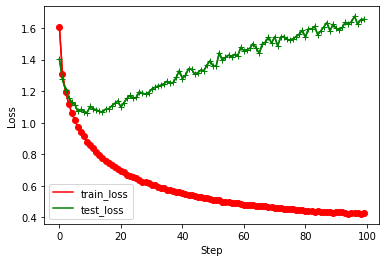

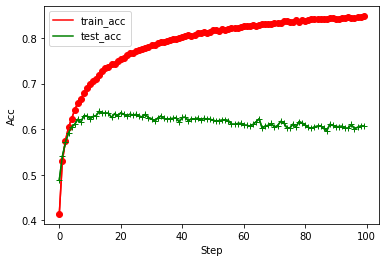

Batch size: 64


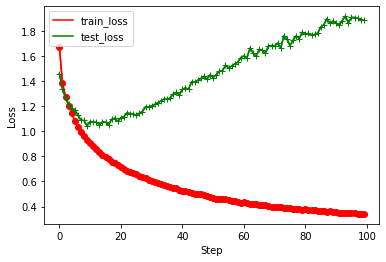

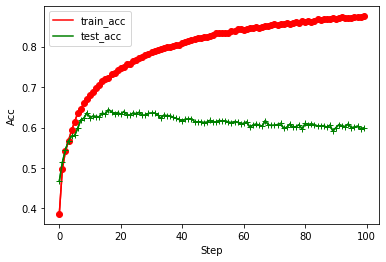

Batch size: 128


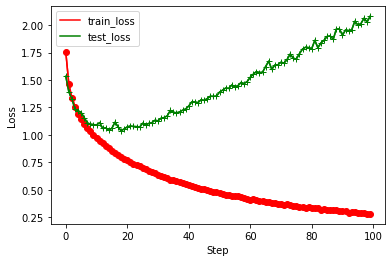

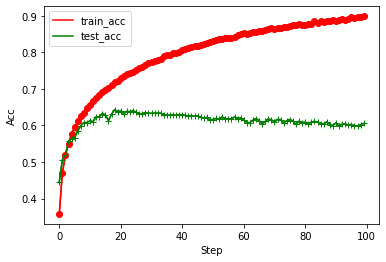

Batch size: 256


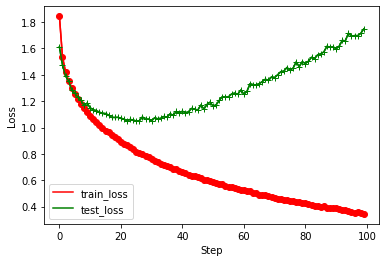

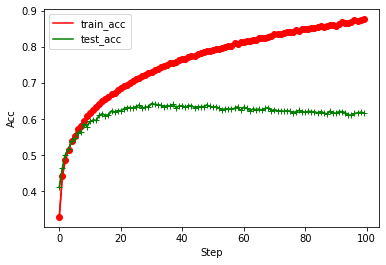

In [33]:
for i in range(len(train_loss_record_lst)):
    print("Batch size: %d" % (32 * (2 ** i)))
    x1=[i for i in range(NUM_EPOCHS)]
    y1=train_loss_record_lst[i]
    x2=x1
    y2=test_loss_record_lst[i]
    l1=plt.plot(x1,y1,'r-',label='train_loss')
    l2=plt.plot(x2,y2,'g-',label='test_loss')
    plt.plot(x1,y1,'ro-',x2,y2,'g+-')
    # plt.title('Learning curve')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    x1=[i for i in range(NUM_EPOCHS)]
    y1=train_acc_record_lst[i]
    x2=x1
    y2=test_acc_record_lst[i]
    l1=plt.plot(x1,y1,'r-',label='train_acc')
    l2=plt.plot(x2,y2,'g-',label='test_acc')
    plt.plot(x1,y1,'ro-',x2,y2,'g+-')
    # plt.title('Learning curve')
    plt.xlabel('Step')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()

Batch size 较小，不容易陷入局部最优，更容易优化，收敛更快。Batch size 较大，每轮训练花费时间更少，训练更快。

本例中 batch size 的大小对 test acc 没有什么影响，可能都是已经达到最优了。

### 5. Make model more complex
可以看到调整参数后优化效果并不明显，train loss 和 test loss 都比较高，应该是 model bias，下面更换更复杂的模型。
- VGG-19
- VGG-19 with batch normalization
- ResNet-18
- ResNet-50
- ResNet-152
- Densenet-121

In [36]:


LOG_PATH="./train9.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
    
model = models.resnet18()
if AVAIL_GPUS:
    model = model.cuda()
    
def get_optimizer(epoch):
    return optim.Adam(model.parameters(), weight_decay=5e-4)

BATCH_SIZE = 128
train_dataset = datasets.CIFAR10('./data', train=True, transform=transform_train, download=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataset = datasets.CIFAR10('./data', train=False, transform=transform_test, download=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
NUM_EPOCHS = 100
print("Model: Resnet 18")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: Adam")
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: Adam")
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
        
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Files already downloaded and verified
Files already downloaded and verified
Model: Resnet 18
Batch size: 128
Epoch num: 100
Optimizer: Adam
---------- Training Epoch #0 ----------


391it [00:16, 23.78it/s]

Finish 1 epoch, Train loss: 1.416498, Train acc@1: 0.505120


Test loss: 1.262076, Test acc@1: 0.543000
Saving Best model...			Top1 = 54.300000%
Elapsed time: 19.259942531585693
---------- Training Epoch #1 ----------


391it [00:15, 25.30it/s]

Finish 2 epoch, Train loss: 1.046493, Train acc@1: 0.632300


Test loss: 1.002060, Test acc@1: 0.654700
Saving Best model...			Top1 = 65.470000%
Elapsed time: 37.484110832214355
---------- Training Epoch #2 ----------


391it [00:15, 25.43it/s]

Finish 3 epoch, Train loss: 0.861715, Train acc@1: 0.700440


Test loss: 1.039947, Test acc@1: 0.646500
Elapsed time: 55.08872890472412
---------- Training Epoch #3 ----------


391it [00:14, 26.57it/s]

Finish 4 epoch, Train loss: 0.748502, Train acc@1: 0.742560


Test loss: 0.898500, Test acc@1: 0.694900
Saving Best model...			Top1 = 69.490000%
Elapsed time: 72.19740438461304
---------- Training Epoch #4 ----------


391it [00:14, 26.81it/s]

Finish 5 epoch, Train loss: 0.654347, Train acc@1: 0.775020


Test loss: 0.808011, Test acc@1: 0.726500
Saving Best model...			Top1 = 72.650000%
Elapsed time: 89.19997024536133
---------- Training Epoch #5 ----------


391it [00:14, 26.64it/s]

Finish 6 epoch, Train loss: 0.580139, Train acc@1: 0.801740


Test loss: 0.782154, Test acc@1: 0.737800
Saving Best model...			Top1 = 73.780000%
Elapsed time: 106.17679190635681
---------- Training Epoch #6 ----------


391it [00:14, 26.89it/s]

Finish 7 epoch, Train loss: 0.515555, Train acc@1: 0.822500


Test loss: 0.805087, Test acc@1: 0.735100
Elapsed time: 123.02481818199158
---------- Training Epoch #7 ----------


391it [00:14, 27.22it/s]

Finish 8 epoch, Train loss: 0.452552, Train acc@1: 0.843620


Test loss: 0.745746, Test acc@1: 0.757800
Saving Best model...			Top1 = 75.780000%
Elapsed time: 139.6901354789734
---------- Training Epoch #8 ----------


391it [00:15, 24.88it/s]

Finish 9 epoch, Train loss: 0.392490, Train acc@1: 0.865340


Test loss: 0.821121, Test acc@1: 0.744800
Elapsed time: 157.53362226486206
---------- Training Epoch #9 ----------


391it [00:14, 27.07it/s]

Finish 10 epoch, Train loss: 0.357134, Train acc@1: 0.877740


Test loss: 0.776953, Test acc@1: 0.758000
Saving Best model...			Top1 = 75.800000%
Elapsed time: 174.31524753570557
---------- Training Epoch #10 ----------


391it [00:14, 26.89it/s]

Finish 11 epoch, Train loss: 0.318354, Train acc@1: 0.891300


Test loss: 0.775501, Test acc@1: 0.760900
Saving Best model...			Top1 = 76.090000%
Elapsed time: 191.21479105949402
---------- Training Epoch #11 ----------


391it [00:15, 25.30it/s]

Finish 12 epoch, Train loss: 0.290947, Train acc@1: 0.898480


Test loss: 0.851845, Test acc@1: 0.754300
Elapsed time: 208.80425691604614
---------- Training Epoch #12 ----------


391it [00:15, 25.47it/s]

Finish 13 epoch, Train loss: 0.259283, Train acc@1: 0.909840


Test loss: 0.909243, Test acc@1: 0.742400
Elapsed time: 226.3511712551117
---------- Training Epoch #13 ----------


391it [00:15, 24.65it/s]

Finish 14 epoch, Train loss: 0.244309, Train acc@1: 0.916720


Test loss: 0.891985, Test acc@1: 0.751200
Elapsed time: 244.36125111579895
---------- Training Epoch #14 ----------


391it [00:15, 24.98it/s]

Finish 15 epoch, Train loss: 0.225703, Train acc@1: 0.922280


Test loss: 0.861497, Test acc@1: 0.753100
Elapsed time: 262.290016412735
---------- Training Epoch #15 ----------


391it [00:14, 26.36it/s]

Finish 16 epoch, Train loss: 0.217135, Train acc@1: 0.925540


Test loss: 0.884908, Test acc@1: 0.758300
Elapsed time: 279.31078362464905
---------- Training Epoch #16 ----------


391it [00:15, 25.61it/s]

Finish 17 epoch, Train loss: 0.201731, Train acc@1: 0.930580


Test loss: 0.904052, Test acc@1: 0.751500
Elapsed time: 296.77004885673523
---------- Training Epoch #17 ----------


391it [00:15, 25.52it/s]

Finish 18 epoch, Train loss: 0.197894, Train acc@1: 0.932260


Test loss: 0.940569, Test acc@1: 0.745600
Elapsed time: 314.2274024486542
---------- Training Epoch #18 ----------


391it [00:15, 25.17it/s]

Finish 19 epoch, Train loss: 0.187076, Train acc@1: 0.936060


Test loss: 0.907560, Test acc@1: 0.754700
Elapsed time: 331.97129249572754
---------- Training Epoch #19 ----------


391it [00:14, 26.48it/s]

Finish 20 epoch, Train loss: 0.185175, Train acc@1: 0.936860


Test loss: 0.933350, Test acc@1: 0.743300
Elapsed time: 348.9534194469452
---------- Training Epoch #20 ----------


391it [00:15, 25.63it/s]

Finish 21 epoch, Train loss: 0.180225, Train acc@1: 0.938200


Test loss: 0.925199, Test acc@1: 0.756200
Elapsed time: 366.3978440761566
---------- Training Epoch #21 ----------


391it [00:14, 26.96it/s]

Finish 22 epoch, Train loss: 0.172174, Train acc@1: 0.940040


Test loss: 0.972916, Test acc@1: 0.748500
Elapsed time: 383.06783509254456
---------- Training Epoch #22 ----------


391it [00:15, 26.03it/s]

Finish 23 epoch, Train loss: 0.166627, Train acc@1: 0.941400


Test loss: 0.951103, Test acc@1: 0.755200
Elapsed time: 400.40985107421875
---------- Training Epoch #23 ----------


391it [00:15, 25.61it/s]

Finish 24 epoch, Train loss: 0.162838, Train acc@1: 0.944060


Test loss: 0.959261, Test acc@1: 0.749700
Elapsed time: 417.8419885635376
---------- Training Epoch #24 ----------


391it [00:15, 26.03it/s]

Finish 25 epoch, Train loss: 0.162114, Train acc@1: 0.944320


Test loss: 0.988254, Test acc@1: 0.752600
Elapsed time: 434.97010588645935
---------- Training Epoch #25 ----------


391it [00:14, 26.54it/s]

Finish 26 epoch, Train loss: 0.157967, Train acc@1: 0.945480


Test loss: 0.990055, Test acc@1: 0.746400
Elapsed time: 451.867716550827
---------- Training Epoch #26 ----------


391it [00:15, 25.99it/s]

Finish 27 epoch, Train loss: 0.150236, Train acc@1: 0.949360


Test loss: 0.936283, Test acc@1: 0.758800
Elapsed time: 469.0659019947052
---------- Training Epoch #27 ----------


391it [00:14, 27.17it/s]

Finish 28 epoch, Train loss: 0.152967, Train acc@1: 0.947860


Test loss: 0.963750, Test acc@1: 0.753100
Elapsed time: 485.75086212158203
---------- Training Epoch #28 ----------


391it [00:15, 25.88it/s]

Finish 29 epoch, Train loss: 0.149938, Train acc@1: 0.948260


Test loss: 1.034906, Test acc@1: 0.743600
Elapsed time: 502.9850580692291
---------- Training Epoch #29 ----------


391it [00:14, 26.83it/s]

Finish 30 epoch, Train loss: 0.152445, Train acc@1: 0.948200


Test loss: 0.975566, Test acc@1: 0.749100
Elapsed time: 519.7928342819214
---------- Training Epoch #30 ----------


391it [00:15, 25.37it/s]

Finish 31 epoch, Train loss: 0.144288, Train acc@1: 0.950480


Test loss: 0.987542, Test acc@1: 0.756900
Elapsed time: 537.3234100341797
---------- Training Epoch #31 ----------


391it [00:14, 27.23it/s]

Finish 32 epoch, Train loss: 0.139876, Train acc@1: 0.951920


Test loss: 1.002231, Test acc@1: 0.744700
Elapsed time: 553.8700330257416
---------- Training Epoch #32 ----------


391it [00:16, 24.14it/s]

Finish 33 epoch, Train loss: 0.141970, Train acc@1: 0.951820


Test loss: 0.950054, Test acc@1: 0.755900
Elapsed time: 572.1803221702576
---------- Training Epoch #33 ----------


391it [00:15, 25.73it/s]

Finish 34 epoch, Train loss: 0.142870, Train acc@1: 0.951680


Test loss: 0.971497, Test acc@1: 0.758300
Elapsed time: 589.6289143562317
---------- Training Epoch #34 ----------


391it [00:16, 23.78it/s]

Finish 35 epoch, Train loss: 0.144940, Train acc@1: 0.950600


Test loss: 0.959607, Test acc@1: 0.755400
Elapsed time: 608.2287335395813
---------- Training Epoch #35 ----------


391it [00:14, 26.16it/s]

Finish 36 epoch, Train loss: 0.138021, Train acc@1: 0.952760


Test loss: 0.976705, Test acc@1: 0.760500
Elapsed time: 625.2835285663605
---------- Training Epoch #36 ----------


391it [00:14, 26.17it/s]

Finish 37 epoch, Train loss: 0.137894, Train acc@1: 0.952220


Test loss: 0.944383, Test acc@1: 0.757600
Elapsed time: 642.385098695755
---------- Training Epoch #37 ----------


391it [00:15, 25.60it/s]

Finish 38 epoch, Train loss: 0.134218, Train acc@1: 0.954720


Test loss: 0.958518, Test acc@1: 0.763600
Saving Best model...			Top1 = 76.360000%
Elapsed time: 659.8489663600922
---------- Training Epoch #38 ----------


391it [00:14, 27.53it/s]

Finish 39 epoch, Train loss: 0.132767, Train acc@1: 0.954320


Test loss: 0.989489, Test acc@1: 0.757600
Elapsed time: 676.1541092395782
---------- Training Epoch #39 ----------


391it [00:15, 26.04it/s]

Finish 40 epoch, Train loss: 0.130604, Train acc@1: 0.955820


Test loss: 0.974271, Test acc@1: 0.763600
Elapsed time: 693.265264749527
---------- Training Epoch #40 ----------


391it [00:14, 26.40it/s]

Finish 41 epoch, Train loss: 0.131486, Train acc@1: 0.955700


Test loss: 1.019829, Test acc@1: 0.749600
Elapsed time: 710.218992471695
---------- Training Epoch #41 ----------


391it [00:14, 26.64it/s]

Finish 42 epoch, Train loss: 0.133482, Train acc@1: 0.953900


Test loss: 1.030514, Test acc@1: 0.752600
Elapsed time: 727.1354155540466
---------- Training Epoch #42 ----------


391it [00:14, 26.83it/s]

Finish 43 epoch, Train loss: 0.126220, Train acc@1: 0.957240


Test loss: 0.973337, Test acc@1: 0.759900
Elapsed time: 743.840569972992
---------- Training Epoch #43 ----------


391it [00:14, 27.32it/s]

Finish 44 epoch, Train loss: 0.127696, Train acc@1: 0.956540


Test loss: 1.009911, Test acc@1: 0.752800
Elapsed time: 760.3818731307983
---------- Training Epoch #44 ----------


391it [00:14, 26.78it/s]

Finish 45 epoch, Train loss: 0.127548, Train acc@1: 0.956100


Test loss: 1.020407, Test acc@1: 0.748400
Elapsed time: 777.2543587684631
---------- Training Epoch #45 ----------


391it [00:14, 26.57it/s]

Finish 46 epoch, Train loss: 0.130283, Train acc@1: 0.954460


Test loss: 1.020922, Test acc@1: 0.752300
Elapsed time: 794.0727353096008
---------- Training Epoch #46 ----------


391it [00:14, 26.46it/s]

Finish 47 epoch, Train loss: 0.129827, Train acc@1: 0.956320


Test loss: 1.018456, Test acc@1: 0.750400
Elapsed time: 811.0969531536102
---------- Training Epoch #47 ----------


391it [00:14, 27.19it/s]

Finish 48 epoch, Train loss: 0.125983, Train acc@1: 0.958000


Test loss: 1.016989, Test acc@1: 0.748200
Elapsed time: 827.6608486175537
---------- Training Epoch #48 ----------


391it [00:14, 26.72it/s]

Finish 49 epoch, Train loss: 0.127088, Train acc@1: 0.956780


Test loss: 1.066245, Test acc@1: 0.742600
Elapsed time: 844.4559371471405
---------- Training Epoch #49 ----------


391it [00:14, 26.59it/s]

Finish 50 epoch, Train loss: 0.124703, Train acc@1: 0.956920


Test loss: 1.014400, Test acc@1: 0.755400
Elapsed time: 861.2921426296234
---------- Training Epoch #50 ----------


391it [00:14, 26.80it/s]

Finish 51 epoch, Train loss: 0.123242, Train acc@1: 0.957440


Test loss: 1.021206, Test acc@1: 0.755800
Elapsed time: 877.9737663269043
---------- Training Epoch #51 ----------


391it [00:14, 26.34it/s]

Finish 52 epoch, Train loss: 0.121940, Train acc@1: 0.958900


Test loss: 1.036724, Test acc@1: 0.747700
Elapsed time: 895.0143105983734
---------- Training Epoch #52 ----------


391it [00:14, 26.45it/s]

Finish 53 epoch, Train loss: 0.123154, Train acc@1: 0.958100


Test loss: 0.982623, Test acc@1: 0.754700
Elapsed time: 911.8592321872711
---------- Training Epoch #53 ----------


391it [00:14, 26.60it/s]

Finish 54 epoch, Train loss: 0.123658, Train acc@1: 0.957160


Test loss: 1.009504, Test acc@1: 0.756800
Elapsed time: 928.6688482761383
---------- Training Epoch #54 ----------


391it [00:14, 26.14it/s]

Finish 55 epoch, Train loss: 0.121507, Train acc@1: 0.958840


Test loss: 1.026365, Test acc@1: 0.749000
Elapsed time: 945.84938621521
---------- Training Epoch #55 ----------


391it [00:14, 26.72it/s]

Finish 56 epoch, Train loss: 0.118916, Train acc@1: 0.958860


Test loss: 1.031661, Test acc@1: 0.756200
Elapsed time: 962.6881635189056
---------- Training Epoch #56 ----------


391it [00:14, 26.85it/s]

Finish 57 epoch, Train loss: 0.122798, Train acc@1: 0.957920


Test loss: 1.029332, Test acc@1: 0.757700
Elapsed time: 979.4533078670502
---------- Training Epoch #57 ----------


391it [00:14, 26.38it/s]

Finish 58 epoch, Train loss: 0.123275, Train acc@1: 0.958780


Test loss: 1.006766, Test acc@1: 0.754000
Elapsed time: 996.4102489948273
---------- Training Epoch #58 ----------


391it [00:14, 26.62it/s]

Finish 59 epoch, Train loss: 0.118222, Train acc@1: 0.959120


Test loss: 1.005412, Test acc@1: 0.756500
Elapsed time: 1013.171523809433
---------- Training Epoch #59 ----------


391it [00:14, 26.42it/s]

Finish 60 epoch, Train loss: 0.121625, Train acc@1: 0.959060


Test loss: 1.015620, Test acc@1: 0.755600
Elapsed time: 1030.0623621940613
---------- Training Epoch #60 ----------


391it [00:15, 24.76it/s]

Finish 61 epoch, Train loss: 0.117830, Train acc@1: 0.959980


Test loss: 1.033505, Test acc@1: 0.754500
Elapsed time: 1048.0501461029053
---------- Training Epoch #61 ----------


391it [00:15, 25.06it/s]

Finish 62 epoch, Train loss: 0.118393, Train acc@1: 0.959380


Test loss: 1.038477, Test acc@1: 0.752000
Elapsed time: 1065.8293907642365
---------- Training Epoch #62 ----------


391it [00:15, 25.74it/s]

Finish 63 epoch, Train loss: 0.115490, Train acc@1: 0.960980


Test loss: 1.013410, Test acc@1: 0.758300
Elapsed time: 1083.0590422153473
---------- Training Epoch #63 ----------


391it [00:14, 26.77it/s]

Finish 64 epoch, Train loss: 0.117843, Train acc@1: 0.960080


Test loss: 0.999668, Test acc@1: 0.759600
Elapsed time: 1099.88307929039
---------- Training Epoch #64 ----------


391it [00:15, 26.02it/s]

Finish 65 epoch, Train loss: 0.116431, Train acc@1: 0.959780


Test loss: 1.073106, Test acc@1: 0.750300
Elapsed time: 1117.1376249790192
---------- Training Epoch #65 ----------


391it [00:14, 26.81it/s]

Finish 66 epoch, Train loss: 0.117456, Train acc@1: 0.960840


Test loss: 1.021184, Test acc@1: 0.752200
Elapsed time: 1133.848067998886
---------- Training Epoch #66 ----------


391it [00:14, 26.64it/s]

Finish 67 epoch, Train loss: 0.116510, Train acc@1: 0.960900


Test loss: 1.033735, Test acc@1: 0.753500
Elapsed time: 1150.70658826828
---------- Training Epoch #67 ----------


391it [00:14, 27.23it/s]

Finish 68 epoch, Train loss: 0.107531, Train acc@1: 0.963660


Test loss: 1.109631, Test acc@1: 0.746300
Elapsed time: 1167.1898403167725
---------- Training Epoch #68 ----------


391it [00:14, 27.01it/s]

Finish 69 epoch, Train loss: 0.120509, Train acc@1: 0.959180


Test loss: 1.017042, Test acc@1: 0.751000
Elapsed time: 1183.7632055282593
---------- Training Epoch #69 ----------


391it [00:14, 26.46it/s]

Finish 70 epoch, Train loss: 0.116089, Train acc@1: 0.960700


Test loss: 1.006302, Test acc@1: 0.754800
Elapsed time: 1200.7295134067535
---------- Training Epoch #70 ----------


391it [00:14, 27.32it/s]

Finish 71 epoch, Train loss: 0.109460, Train acc@1: 0.962960


Test loss: 1.063614, Test acc@1: 0.752500
Elapsed time: 1217.2099254131317
---------- Training Epoch #71 ----------


391it [00:14, 26.14it/s]

Finish 72 epoch, Train loss: 0.114688, Train acc@1: 0.961180


Test loss: 1.014264, Test acc@1: 0.755900
Elapsed time: 1234.2218887805939
---------- Training Epoch #72 ----------


391it [00:14, 27.51it/s]

Finish 73 epoch, Train loss: 0.117196, Train acc@1: 0.960980


Test loss: 1.075426, Test acc@1: 0.747000
Elapsed time: 1250.6089479923248
---------- Training Epoch #73 ----------


391it [00:14, 26.98it/s]

Finish 74 epoch, Train loss: 0.112300, Train acc@1: 0.960820


Test loss: 1.068036, Test acc@1: 0.744800
Elapsed time: 1267.1675662994385
---------- Training Epoch #74 ----------


391it [00:15, 24.88it/s]

Finish 75 epoch, Train loss: 0.111456, Train acc@1: 0.961620


Test loss: 1.067064, Test acc@1: 0.747400
Elapsed time: 1285.1680479049683
---------- Training Epoch #75 ----------


391it [00:15, 25.30it/s]

Finish 76 epoch, Train loss: 0.111347, Train acc@1: 0.961760


Test loss: 0.998228, Test acc@1: 0.755600
Elapsed time: 1302.7789950370789
---------- Training Epoch #76 ----------


391it [00:15, 25.13it/s]

Finish 77 epoch, Train loss: 0.112207, Train acc@1: 0.962220


Test loss: 1.058278, Test acc@1: 0.749500
Elapsed time: 1320.527958393097
---------- Training Epoch #77 ----------


391it [00:14, 26.39it/s]

Finish 78 epoch, Train loss: 0.113793, Train acc@1: 0.961660


Test loss: 1.004610, Test acc@1: 0.760400
Elapsed time: 1337.501381635666
---------- Training Epoch #78 ----------


391it [00:14, 26.21it/s]

Finish 79 epoch, Train loss: 0.114040, Train acc@1: 0.961920


Test loss: 1.007198, Test acc@1: 0.760500
Elapsed time: 1354.602083683014
---------- Training Epoch #79 ----------


391it [00:14, 26.14it/s]

Finish 80 epoch, Train loss: 0.108397, Train acc@1: 0.963600


Test loss: 1.044366, Test acc@1: 0.754500
Elapsed time: 1371.6638140678406
---------- Training Epoch #80 ----------


391it [00:15, 25.44it/s]

Finish 81 epoch, Train loss: 0.109287, Train acc@1: 0.963920


Test loss: 1.074745, Test acc@1: 0.746200
Elapsed time: 1389.1394515037537
---------- Training Epoch #81 ----------


391it [00:15, 24.55it/s]

Finish 82 epoch, Train loss: 0.109420, Train acc@1: 0.962600


Test loss: 1.059585, Test acc@1: 0.751800
Elapsed time: 1407.2394959926605
---------- Training Epoch #82 ----------


391it [00:14, 26.89it/s]

Finish 83 epoch, Train loss: 0.107968, Train acc@1: 0.964140


Test loss: 1.004195, Test acc@1: 0.759300
Elapsed time: 1423.9655146598816
---------- Training Epoch #83 ----------


391it [00:14, 26.38it/s]

Finish 84 epoch, Train loss: 0.110435, Train acc@1: 0.962720


Test loss: 1.083812, Test acc@1: 0.745100
Elapsed time: 1440.9294037818909
---------- Training Epoch #84 ----------


391it [00:14, 26.26it/s]

Finish 85 epoch, Train loss: 0.113275, Train acc@1: 0.961920


Test loss: 1.104265, Test acc@1: 0.742700
Elapsed time: 1458.0040283203125
---------- Training Epoch #85 ----------


391it [00:15, 24.88it/s]

Finish 86 epoch, Train loss: 0.105347, Train acc@1: 0.963860


Test loss: 1.051297, Test acc@1: 0.751900
Elapsed time: 1475.9145584106445
---------- Training Epoch #86 ----------


391it [00:15, 25.78it/s]

Finish 87 epoch, Train loss: 0.110544, Train acc@1: 0.962140


Test loss: 1.062522, Test acc@1: 0.755800
Elapsed time: 1493.2017045021057
---------- Training Epoch #87 ----------


391it [00:14, 26.31it/s]

Finish 88 epoch, Train loss: 0.109214, Train acc@1: 0.963060


Test loss: 1.052296, Test acc@1: 0.749900
Elapsed time: 1510.1396889686584
---------- Training Epoch #88 ----------


391it [00:15, 26.05it/s]

Finish 89 epoch, Train loss: 0.107549, Train acc@1: 0.964140


Test loss: 1.025983, Test acc@1: 0.755500
Elapsed time: 1527.2211999893188
---------- Training Epoch #89 ----------


391it [00:14, 27.31it/s]

Finish 90 epoch, Train loss: 0.105277, Train acc@1: 0.964260


Test loss: 1.099059, Test acc@1: 0.748400
Elapsed time: 1543.6487255096436
---------- Training Epoch #90 ----------


391it [00:14, 27.92it/s]

Finish 91 epoch, Train loss: 0.106810, Train acc@1: 0.963660


Test loss: 1.053286, Test acc@1: 0.755700
Elapsed time: 1559.8276629447937
---------- Training Epoch #91 ----------


391it [00:14, 26.14it/s]

Finish 92 epoch, Train loss: 0.112103, Train acc@1: 0.962000


Test loss: 1.081117, Test acc@1: 0.747400
Elapsed time: 1577.015615940094
---------- Training Epoch #92 ----------


391it [00:14, 26.69it/s]

Finish 93 epoch, Train loss: 0.106057, Train acc@1: 0.964360


Test loss: 1.112821, Test acc@1: 0.750700
Elapsed time: 1593.7857921123505
---------- Training Epoch #93 ----------


391it [00:14, 26.33it/s]

Finish 94 epoch, Train loss: 0.104501, Train acc@1: 0.964300


Test loss: 1.068163, Test acc@1: 0.755800
Elapsed time: 1610.8939905166626
---------- Training Epoch #94 ----------


391it [00:15, 26.06it/s]

Finish 95 epoch, Train loss: 0.106488, Train acc@1: 0.963960


Test loss: 1.017559, Test acc@1: 0.757400
Elapsed time: 1628.0200126171112
---------- Training Epoch #95 ----------


391it [00:14, 26.67it/s]

Finish 96 epoch, Train loss: 0.100166, Train acc@1: 0.966320


Test loss: 1.081519, Test acc@1: 0.750600
Elapsed time: 1644.9132297039032
---------- Training Epoch #96 ----------


391it [00:14, 27.72it/s]

Finish 97 epoch, Train loss: 0.106568, Train acc@1: 0.964520


Test loss: 1.040835, Test acc@1: 0.750600
Elapsed time: 1661.2909877300262
---------- Training Epoch #97 ----------


391it [00:14, 26.40it/s]

Finish 98 epoch, Train loss: 0.104602, Train acc@1: 0.964660


Test loss: 1.066960, Test acc@1: 0.753200
Elapsed time: 1678.2290012836456
---------- Training Epoch #98 ----------


391it [00:14, 27.02it/s]

Finish 99 epoch, Train loss: 0.105534, Train acc@1: 0.963840


Test loss: 1.062167, Test acc@1: 0.750100
Elapsed time: 1694.8555924892426
---------- Training Epoch #99 ----------


391it [00:14, 26.76it/s]

Finish 100 epoch, Train loss: 0.101824, Train acc@1: 0.965700


Test loss: 1.056525, Test acc@1: 0.753600
Elapsed time: 1711.7090759277344

Test results: Acc@1 = 76.360000%


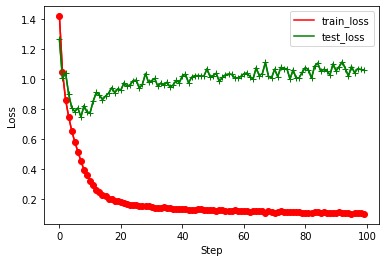

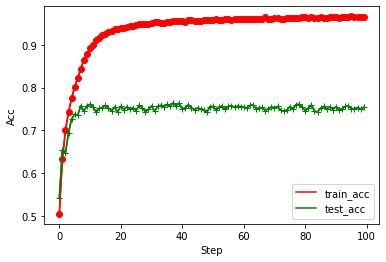

In [37]:
x1=[i for i in range(NUM_EPOCHS)]
y1=train_loss_record
x2=x1
y2=test_loss_record
l1=plt.plot(x1,y1,'r-',label='train_loss')
l2=plt.plot(x2,y2,'g-',label='test_loss')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()
 
x1=[i for i in range(NUM_EPOCHS)]
y1=train_acc_record
x2=x1
y2=test_acc_record
l1=plt.plot(x1,y1,'r-',label='train_acc')
l2=plt.plot(x2,y2,'g-',label='test_acc')
plt.plot(x1,y1,'ro-',x2,y2,'g+-')
# plt.title('Learning curve')
plt.xlabel('Step')
plt.ylabel('Acc')
plt.legend()
plt.show()

### 6. Data augmentation

In [40]:
'''Data augmentation'''
transform_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.4914, 0.4822, 0.4465 ],
                         std  = [ 0.2023, 0.1994, 0.2010 ]),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.4914, 0.4822, 0.4465 ],
                         std  = [ 0.2023, 0.1994, 0.2010 ]),
    ])

In [41]:
'''CIFAR-10 dataset'''
train_dataset = datasets.CIFAR10('./data', train=True, transform=transform_train, download=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataset = datasets.CIFAR10('./data', train=False, transform=transform_test, download=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
print(len(train_dataset))

Files already downloaded and verified
Files already downloaded and verified
50000


In [42]:
LOG_PATH="./train10.log"
if os.path.exists(LOG_PATH):
    os.remove(LOG_PATH)
    
model = models.resnet18()
if AVAIL_GPUS:
    model = model.cuda()
    
def get_optimizer(epoch):
    return optim.Adam(model.parameters(), weight_decay=5e-4)

BATCH_SIZE = 128
NUM_EPOCHS = 100
print("Model: Resnet 18")
print("Batch size: %d" % (BATCH_SIZE))
print("Epoch num: %d" % (NUM_EPOCHS))
print("Optimizer: Adam")
with open(LOG_PATH, "a") as f:
    f.write("Model: CNN from Pytorch tutorial")
    f.write("\n")
    f.write("Batch size: %d" % (BATCH_SIZE))
    f.write("\n")
    f.write("Epoch num: %d" % (NUM_EPOCHS))
    f.write("\n")
    f.write("Optimizer: Adam")
    f.write("\n")
    
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []
best_acc = 0
elapsed_time = 0
for i in range(NUM_EPOCHS):
    start_time = time.time()

    print("-"*10, "Training Epoch #%d" % (i), "-"*10)
    with open(LOG_PATH, "a") as f:
        f.write("-"*10 + "Training Epoch #%d" % (i) + "-"*10)
        f.write("\n")
        
    train(i)
    test(i)
    
    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('Elapsed time: %s' % str(elapsed_time))
    with open(LOG_PATH, "a") as f:
        f.write('Elapsed time: %s' % str(elapsed_time))
        f.write("\n")
print('\nTest results: Acc@1 = %.6f%%' %(best_acc))
with open(LOG_PATH, "a") as f:
    f.write('\nTest results: Acc@1 = %.6f%%' %(best_acc))
    f.write("\n")

Model: Resnet 18
Batch size: 128
Epoch num: 100
Optimizer: Adam
---------- Training Epoch #0 ----------


391it [00:16, 24.02it/s]

Finish 1 epoch, Train loss: 1.579621, Train acc@1: 0.438680


Test loss: 1.230577, Test acc@1: 0.563000
Saving Best model...			Top1 = 56.300000%
Elapsed time: 18.511664628982544
---------- Training Epoch #1 ----------


391it [00:15, 25.38it/s]

Finish 2 epoch, Train loss: 1.235641, Train acc@1: 0.560560


Test loss: 1.214628, Test acc@1: 0.581700
Saving Best model...			Top1 = 58.170000%
Elapsed time: 36.149757862091064
---------- Training Epoch #2 ----------


391it [00:15, 25.02it/s]

Finish 3 epoch, Train loss: 1.066232, Train acc@1: 0.627780


Test loss: 0.991381, Test acc@1: 0.655300
Saving Best model...			Top1 = 65.530000%
Elapsed time: 54.0332510471344
---------- Training Epoch #3 ----------


391it [00:14, 27.21it/s]

Finish 4 epoch, Train loss: 0.961949, Train acc@1: 0.665780


Test loss: 0.935584, Test acc@1: 0.673100
Saving Best model...			Top1 = 67.310000%
Elapsed time: 70.704021692276
---------- Training Epoch #4 ----------


391it [00:15, 25.16it/s]

Finish 5 epoch, Train loss: 0.889629, Train acc@1: 0.691840


Test loss: 0.867494, Test acc@1: 0.702600
Saving Best model...			Top1 = 70.260000%
Elapsed time: 88.56199836730957
---------- Training Epoch #5 ----------


391it [00:14, 27.15it/s]

Finish 6 epoch, Train loss: 0.833437, Train acc@1: 0.714220


Test loss: 0.823939, Test acc@1: 0.715100
Saving Best model...			Top1 = 71.510000%
Elapsed time: 105.24942588806152
---------- Training Epoch #6 ----------


391it [00:14, 26.36it/s]

Finish 7 epoch, Train loss: 0.785027, Train acc@1: 0.730220


Test loss: 0.778222, Test acc@1: 0.732600
Saving Best model...			Top1 = 73.260000%
Elapsed time: 122.41255831718445
---------- Training Epoch #7 ----------


391it [00:15, 25.15it/s]

Finish 8 epoch, Train loss: 0.744746, Train acc@1: 0.745240


Test loss: 0.827865, Test acc@1: 0.728400
Elapsed time: 140.12325358390808
---------- Training Epoch #8 ----------


391it [00:14, 27.13it/s]

Finish 9 epoch, Train loss: 0.715876, Train acc@1: 0.753280


Test loss: 0.746700, Test acc@1: 0.751400
Saving Best model...			Top1 = 75.140000%
Elapsed time: 156.82610988616943
---------- Training Epoch #9 ----------


391it [00:15, 25.23it/s]

Finish 10 epoch, Train loss: 0.692958, Train acc@1: 0.762720


Test loss: 0.740502, Test acc@1: 0.751300
Elapsed time: 174.39378118515015
---------- Training Epoch #10 ----------


391it [00:14, 26.71it/s]

Finish 11 epoch, Train loss: 0.678788, Train acc@1: 0.769920


Test loss: 0.686149, Test acc@1: 0.761000
Saving Best model...			Top1 = 76.100000%
Elapsed time: 191.32044792175293
---------- Training Epoch #11 ----------


391it [00:15, 24.71it/s]

Finish 12 epoch, Train loss: 0.650370, Train acc@1: 0.778460


Test loss: 0.712150, Test acc@1: 0.758600
Elapsed time: 209.23015570640564
---------- Training Epoch #12 ----------


391it [00:15, 26.01it/s]

Finish 13 epoch, Train loss: 0.640547, Train acc@1: 0.781920


Test loss: 0.644087, Test acc@1: 0.781500
Saving Best model...			Top1 = 78.150000%
Elapsed time: 226.62469148635864
---------- Training Epoch #13 ----------


391it [00:14, 26.66it/s]

Finish 14 epoch, Train loss: 0.626098, Train acc@1: 0.785900


Test loss: 0.620221, Test acc@1: 0.788900
Saving Best model...			Top1 = 78.890000%
Elapsed time: 243.5893702507019
---------- Training Epoch #14 ----------


391it [00:14, 26.51it/s]

Finish 15 epoch, Train loss: 0.607035, Train acc@1: 0.794040


Test loss: 0.626199, Test acc@1: 0.783200
Elapsed time: 260.4425983428955
---------- Training Epoch #15 ----------


391it [00:14, 26.81it/s]

Finish 16 epoch, Train loss: 0.596217, Train acc@1: 0.797840


Test loss: 0.612999, Test acc@1: 0.791700
Saving Best model...			Top1 = 79.170000%
Elapsed time: 277.42991065979004
---------- Training Epoch #16 ----------


391it [00:15, 25.73it/s]

Finish 17 epoch, Train loss: 0.585721, Train acc@1: 0.800220


Test loss: 0.650587, Test acc@1: 0.775500
Elapsed time: 294.8430027961731
---------- Training Epoch #17 ----------


391it [00:15, 25.25it/s]

Finish 18 epoch, Train loss: 0.577293, Train acc@1: 0.804140


Test loss: 0.623438, Test acc@1: 0.790900
Elapsed time: 312.45728039741516
---------- Training Epoch #18 ----------


391it [00:14, 27.03it/s]

Finish 19 epoch, Train loss: 0.570278, Train acc@1: 0.804560


Test loss: 0.618544, Test acc@1: 0.786700
Elapsed time: 329.124498128891
---------- Training Epoch #19 ----------


391it [00:14, 26.96it/s]

Finish 20 epoch, Train loss: 0.560984, Train acc@1: 0.808720


Test loss: 0.587501, Test acc@1: 0.805300
Saving Best model...			Top1 = 80.530000%
Elapsed time: 345.99180722236633
---------- Training Epoch #20 ----------


391it [00:14, 27.49it/s]

Finish 21 epoch, Train loss: 0.556104, Train acc@1: 0.809500


Test loss: 0.587459, Test acc@1: 0.806400
Saving Best model...			Top1 = 80.640000%
Elapsed time: 362.498339176178
---------- Training Epoch #21 ----------


391it [00:14, 27.30it/s]

Finish 22 epoch, Train loss: 0.547310, Train acc@1: 0.813120


Test loss: 0.579074, Test acc@1: 0.804100
Elapsed time: 378.9550986289978
---------- Training Epoch #22 ----------


391it [00:14, 26.73it/s]

Finish 23 epoch, Train loss: 0.533121, Train acc@1: 0.818420


Test loss: 0.561326, Test acc@1: 0.810700
Saving Best model...			Top1 = 81.070000%
Elapsed time: 395.89183139801025
---------- Training Epoch #23 ----------


391it [00:14, 27.62it/s]

Finish 24 epoch, Train loss: 0.531872, Train acc@1: 0.818760


Test loss: 0.651253, Test acc@1: 0.785400
Elapsed time: 412.2262530326843
---------- Training Epoch #24 ----------


391it [00:16, 24.44it/s]

Finish 25 epoch, Train loss: 0.530970, Train acc@1: 0.818940


Test loss: 0.566992, Test acc@1: 0.811800
Saving Best model...			Top1 = 81.180000%
Elapsed time: 430.54596996307373
---------- Training Epoch #25 ----------


391it [00:14, 26.30it/s]

Finish 26 epoch, Train loss: 0.519307, Train acc@1: 0.822360


Test loss: 0.619369, Test acc@1: 0.794600
Elapsed time: 447.59509468078613
---------- Training Epoch #26 ----------


391it [00:14, 26.60it/s]

Finish 27 epoch, Train loss: 0.511338, Train acc@1: 0.825140


Test loss: 0.600058, Test acc@1: 0.797900
Elapsed time: 464.53006505966187
---------- Training Epoch #27 ----------


391it [00:14, 26.93it/s]

Finish 28 epoch, Train loss: 0.510469, Train acc@1: 0.824660


Test loss: 0.566597, Test acc@1: 0.808000
Elapsed time: 481.26882576942444
---------- Training Epoch #28 ----------


391it [00:15, 25.46it/s]

Finish 29 epoch, Train loss: 0.506882, Train acc@1: 0.827160


Test loss: 0.623578, Test acc@1: 0.790300
Elapsed time: 498.73439264297485
---------- Training Epoch #29 ----------


391it [00:14, 26.55it/s]

Finish 30 epoch, Train loss: 0.509147, Train acc@1: 0.824480


Test loss: 0.566310, Test acc@1: 0.806700
Elapsed time: 515.5767598152161
---------- Training Epoch #30 ----------


391it [00:14, 27.22it/s]

Finish 31 epoch, Train loss: 0.494357, Train acc@1: 0.831840


Test loss: 0.555501, Test acc@1: 0.813500
Saving Best model...			Top1 = 81.350000%
Elapsed time: 532.2320780754089
---------- Training Epoch #31 ----------


391it [00:14, 27.15it/s]

Finish 32 epoch, Train loss: 0.497670, Train acc@1: 0.829780


Test loss: 0.570903, Test acc@1: 0.809800
Elapsed time: 548.8190312385559
---------- Training Epoch #32 ----------


391it [00:14, 26.90it/s]

Finish 33 epoch, Train loss: 0.485584, Train acc@1: 0.833640


Test loss: 0.604714, Test acc@1: 0.801000
Elapsed time: 565.5874814987183
---------- Training Epoch #33 ----------


391it [00:14, 26.46it/s]

Finish 34 epoch, Train loss: 0.481980, Train acc@1: 0.833980


Test loss: 0.568264, Test acc@1: 0.810400
Elapsed time: 582.6383392810822
---------- Training Epoch #34 ----------


391it [00:14, 27.09it/s]

Finish 35 epoch, Train loss: 0.482372, Train acc@1: 0.834800


Test loss: 0.528306, Test acc@1: 0.824400
Saving Best model...			Top1 = 82.440000%
Elapsed time: 599.259199142456
---------- Training Epoch #35 ----------


391it [00:14, 26.46it/s]


Finish 36 epoch, Train loss: 0.481554, Train acc@1: 0.835920
Test loss: 0.566499, Test acc@1: 0.806400
Elapsed time: 616.2936556339264
---------- Training Epoch #36 ----------


391it [00:14, 26.80it/s]

Finish 37 epoch, Train loss: 0.482314, Train acc@1: 0.835760


Test loss: 0.586781, Test acc@1: 0.802700
Elapsed time: 633.0352075099945
---------- Training Epoch #37 ----------


391it [00:14, 27.12it/s]

Finish 38 epoch, Train loss: 0.471271, Train acc@1: 0.838940


Test loss: 0.533427, Test acc@1: 0.824700
Saving Best model...			Top1 = 82.470000%
Elapsed time: 649.8433876037598
---------- Training Epoch #38 ----------


391it [00:14, 26.30it/s]

Finish 39 epoch, Train loss: 0.470644, Train acc@1: 0.839760


Test loss: 0.601162, Test acc@1: 0.805400
Elapsed time: 666.853410243988
---------- Training Epoch #39 ----------


391it [00:14, 26.35it/s]

Finish 40 epoch, Train loss: 0.474261, Train acc@1: 0.838800


Test loss: 0.543421, Test acc@1: 0.820000
Elapsed time: 683.7512164115906
---------- Training Epoch #40 ----------


391it [00:14, 27.59it/s]

Finish 41 epoch, Train loss: 0.467808, Train acc@1: 0.839900


Test loss: 0.550904, Test acc@1: 0.818200
Elapsed time: 700.054141998291
---------- Training Epoch #41 ----------


391it [00:14, 27.37it/s]

Finish 42 epoch, Train loss: 0.460736, Train acc@1: 0.843100


Test loss: 0.524791, Test acc@1: 0.827700
Saving Best model...			Top1 = 82.770000%
Elapsed time: 716.6197085380554
---------- Training Epoch #42 ----------


391it [00:15, 25.53it/s]

Finish 43 epoch, Train loss: 0.453955, Train acc@1: 0.844320


Test loss: 0.587175, Test acc@1: 0.804900
Elapsed time: 734.0361618995667
---------- Training Epoch #43 ----------


391it [00:14, 26.86it/s]

Finish 44 epoch, Train loss: 0.463328, Train acc@1: 0.841860


Test loss: 0.586805, Test acc@1: 0.809400
Elapsed time: 750.7210941314697
---------- Training Epoch #44 ----------


391it [00:14, 26.77it/s]

Finish 45 epoch, Train loss: 0.452296, Train acc@1: 0.845260


Test loss: 0.561084, Test acc@1: 0.812000
Elapsed time: 767.4731087684631
---------- Training Epoch #45 ----------


391it [00:15, 25.46it/s]

Finish 46 epoch, Train loss: 0.453561, Train acc@1: 0.846660


Test loss: 0.559297, Test acc@1: 0.817500
Elapsed time: 784.9510369300842
---------- Training Epoch #46 ----------


391it [00:14, 26.96it/s]

Finish 47 epoch, Train loss: 0.450760, Train acc@1: 0.847560


Test loss: 0.514203, Test acc@1: 0.827200
Elapsed time: 801.6690998077393
---------- Training Epoch #47 ----------


391it [00:14, 26.90it/s]

Finish 48 epoch, Train loss: 0.448830, Train acc@1: 0.846020


Test loss: 0.538095, Test acc@1: 0.819400
Elapsed time: 818.3399455547333
---------- Training Epoch #48 ----------


391it [00:14, 26.87it/s]

Finish 49 epoch, Train loss: 0.442716, Train acc@1: 0.848980


Test loss: 0.571003, Test acc@1: 0.811900
Elapsed time: 835.0330975055695
---------- Training Epoch #49 ----------


391it [00:14, 26.68it/s]

Finish 50 epoch, Train loss: 0.443060, Train acc@1: 0.847420


Test loss: 0.608845, Test acc@1: 0.797300
Elapsed time: 851.8728406429291
---------- Training Epoch #50 ----------


391it [00:14, 26.76it/s]

Finish 51 epoch, Train loss: 0.445121, Train acc@1: 0.846440


Test loss: 0.508105, Test acc@1: 0.827400
Elapsed time: 868.7119379043579
---------- Training Epoch #51 ----------


391it [00:14, 27.48it/s]

Finish 52 epoch, Train loss: 0.444486, Train acc@1: 0.848260


Test loss: 0.556757, Test acc@1: 0.811600
Elapsed time: 885.0717418193817
---------- Training Epoch #52 ----------


391it [00:14, 26.60it/s]

Finish 53 epoch, Train loss: 0.436851, Train acc@1: 0.851720


Test loss: 0.532337, Test acc@1: 0.822500
Elapsed time: 901.9050171375275
---------- Training Epoch #53 ----------


391it [00:13, 28.57it/s]

Finish 54 epoch, Train loss: 0.441521, Train acc@1: 0.849340


Test loss: 0.556611, Test acc@1: 0.817400
Elapsed time: 917.758104801178
---------- Training Epoch #54 ----------


391it [00:14, 26.42it/s]

Finish 55 epoch, Train loss: 0.436881, Train acc@1: 0.850420


Test loss: 0.583198, Test acc@1: 0.813000
Elapsed time: 934.6927516460419
---------- Training Epoch #55 ----------


391it [00:14, 27.10it/s]


Finish 56 epoch, Train loss: 0.436019, Train acc@1: 0.851060
Test loss: 0.515396, Test acc@1: 0.831300
Saving Best model...			Top1 = 83.130000%
Elapsed time: 951.3545925617218
---------- Training Epoch #56 ----------


391it [00:14, 27.25it/s]

Finish 57 epoch, Train loss: 0.433837, Train acc@1: 0.852080


Test loss: 0.516356, Test acc@1: 0.829500
Elapsed time: 967.8487119674683
---------- Training Epoch #57 ----------


391it [00:14, 26.69it/s]

Finish 58 epoch, Train loss: 0.428150, Train acc@1: 0.852360


Test loss: 0.537951, Test acc@1: 0.826200
Elapsed time: 984.7595221996307
---------- Training Epoch #58 ----------


391it [00:15, 25.49it/s]

Finish 59 epoch, Train loss: 0.431268, Train acc@1: 0.852120


Test loss: 0.523763, Test acc@1: 0.827100
Elapsed time: 1002.3384385108948
---------- Training Epoch #59 ----------


391it [00:14, 26.86it/s]

Finish 60 epoch, Train loss: 0.430725, Train acc@1: 0.851820


Test loss: 0.547037, Test acc@1: 0.823400
Elapsed time: 1019.0485475063324
---------- Training Epoch #60 ----------


391it [00:14, 26.95it/s]

Finish 61 epoch, Train loss: 0.424845, Train acc@1: 0.854960


Test loss: 0.517385, Test acc@1: 0.827600
Elapsed time: 1035.7064604759216
---------- Training Epoch #61 ----------


391it [00:14, 27.25it/s]

Finish 62 epoch, Train loss: 0.424285, Train acc@1: 0.855500


Test loss: 0.515601, Test acc@1: 0.830600
Elapsed time: 1052.2302196025848
---------- Training Epoch #62 ----------


391it [00:14, 26.91it/s]

Finish 63 epoch, Train loss: 0.416018, Train acc@1: 0.857560


Test loss: 0.587278, Test acc@1: 0.805600
Elapsed time: 1068.8273406028748
---------- Training Epoch #63 ----------


391it [00:14, 26.89it/s]

Finish 64 epoch, Train loss: 0.430244, Train acc@1: 0.852540


Test loss: 0.543132, Test acc@1: 0.821600
Elapsed time: 1085.5638175010681
---------- Training Epoch #64 ----------


391it [00:14, 27.55it/s]

Finish 65 epoch, Train loss: 0.423050, Train acc@1: 0.856100


Test loss: 0.518223, Test acc@1: 0.827500
Elapsed time: 1101.9502761363983
---------- Training Epoch #65 ----------


391it [00:14, 27.08it/s]

Finish 66 epoch, Train loss: 0.424310, Train acc@1: 0.853300


Test loss: 0.560634, Test acc@1: 0.818400
Elapsed time: 1118.5155053138733
---------- Training Epoch #66 ----------


391it [00:14, 26.55it/s]

Finish 67 epoch, Train loss: 0.423244, Train acc@1: 0.855940


Test loss: 0.540465, Test acc@1: 0.822900
Elapsed time: 1135.2982969284058
---------- Training Epoch #67 ----------


391it [00:14, 26.70it/s]

Finish 68 epoch, Train loss: 0.420364, Train acc@1: 0.856320


Test loss: 0.516922, Test acc@1: 0.827900
Elapsed time: 1152.090793132782
---------- Training Epoch #68 ----------


391it [00:14, 27.65it/s]

Finish 69 epoch, Train loss: 0.421184, Train acc@1: 0.856560


Test loss: 0.510942, Test acc@1: 0.831900
Saving Best model...			Top1 = 83.190000%
Elapsed time: 1168.5029151439667
---------- Training Epoch #69 ----------


391it [00:14, 26.90it/s]

Finish 70 epoch, Train loss: 0.412376, Train acc@1: 0.858900


Test loss: 0.523361, Test acc@1: 0.826700
Elapsed time: 1185.2613363265991
---------- Training Epoch #70 ----------


391it [00:15, 25.18it/s]

Finish 71 epoch, Train loss: 0.416635, Train acc@1: 0.856580


Test loss: 0.496436, Test acc@1: 0.839200
Saving Best model...			Top1 = 83.920000%
Elapsed time: 1203.046983242035
---------- Training Epoch #71 ----------


391it [00:15, 25.69it/s]

Finish 72 epoch, Train loss: 0.410620, Train acc@1: 0.859580


Test loss: 0.519725, Test acc@1: 0.828500
Elapsed time: 1220.3462355136871
---------- Training Epoch #72 ----------


391it [00:14, 27.15it/s]

Finish 73 epoch, Train loss: 0.412657, Train acc@1: 0.857000


Test loss: 0.544680, Test acc@1: 0.820800
Elapsed time: 1237.0808401107788
---------- Training Epoch #73 ----------


391it [00:14, 26.62it/s]

Finish 74 epoch, Train loss: 0.406733, Train acc@1: 0.860520


Test loss: 0.491896, Test acc@1: 0.836100
Elapsed time: 1253.9332768917084
---------- Training Epoch #74 ----------


391it [00:15, 24.97it/s]

Finish 75 epoch, Train loss: 0.413625, Train acc@1: 0.858900


Test loss: 0.511749, Test acc@1: 0.829300
Elapsed time: 1271.808536529541
---------- Training Epoch #75 ----------


391it [00:14, 26.12it/s]

Finish 76 epoch, Train loss: 0.409421, Train acc@1: 0.859220


Test loss: 0.522740, Test acc@1: 0.827700
Elapsed time: 1288.8868565559387
---------- Training Epoch #76 ----------


391it [00:13, 28.00it/s]

Finish 77 epoch, Train loss: 0.404584, Train acc@1: 0.860480


Test loss: 0.581162, Test acc@1: 0.809700
Elapsed time: 1305.0356137752533
---------- Training Epoch #77 ----------


391it [00:14, 26.74it/s]

Finish 78 epoch, Train loss: 0.404400, Train acc@1: 0.861040


Test loss: 0.499201, Test acc@1: 0.832100
Elapsed time: 1321.7775464057922
---------- Training Epoch #78 ----------


391it [00:14, 26.73it/s]

Finish 79 epoch, Train loss: 0.406432, Train acc@1: 0.860660


Test loss: 0.533463, Test acc@1: 0.828400
Elapsed time: 1338.6108419895172
---------- Training Epoch #79 ----------


391it [00:15, 25.39it/s]

Finish 80 epoch, Train loss: 0.403194, Train acc@1: 0.861460


Test loss: 0.531218, Test acc@1: 0.824500
Elapsed time: 1356.2397193908691
---------- Training Epoch #80 ----------


391it [00:15, 26.04it/s]

Finish 81 epoch, Train loss: 0.405088, Train acc@1: 0.861140


Test loss: 0.488844, Test acc@1: 0.838400
Elapsed time: 1373.4328169822693
---------- Training Epoch #81 ----------


391it [00:14, 26.21it/s]

Finish 82 epoch, Train loss: 0.404196, Train acc@1: 0.861780


Test loss: 0.497767, Test acc@1: 0.837300
Elapsed time: 1390.5360114574432
---------- Training Epoch #82 ----------


391it [00:14, 26.55it/s]

Finish 83 epoch, Train loss: 0.399860, Train acc@1: 0.862280


Test loss: 0.485346, Test acc@1: 0.837500
Elapsed time: 1407.6112132072449
---------- Training Epoch #83 ----------


391it [00:14, 27.23it/s]

Finish 84 epoch, Train loss: 0.402272, Train acc@1: 0.861660


Test loss: 0.483039, Test acc@1: 0.838700
Elapsed time: 1424.1955366134644
---------- Training Epoch #84 ----------


391it [00:14, 27.11it/s]

Finish 85 epoch, Train loss: 0.406028, Train acc@1: 0.860540


Test loss: 0.538222, Test acc@1: 0.823300
Elapsed time: 1440.833283662796
---------- Training Epoch #85 ----------


391it [00:14, 26.28it/s]

Finish 86 epoch, Train loss: 0.402076, Train acc@1: 0.861680


Test loss: 0.571345, Test acc@1: 0.814900
Elapsed time: 1457.926931142807
---------- Training Epoch #86 ----------


391it [00:14, 26.92it/s]

Finish 87 epoch, Train loss: 0.397229, Train acc@1: 0.864720


Test loss: 0.520056, Test acc@1: 0.829600
Elapsed time: 1474.6749076843262
---------- Training Epoch #87 ----------


391it [00:14, 26.86it/s]

Finish 88 epoch, Train loss: 0.402005, Train acc@1: 0.863060


Test loss: 0.516088, Test acc@1: 0.830500
Elapsed time: 1491.3005409240723
---------- Training Epoch #88 ----------


391it [00:13, 28.00it/s]

Finish 89 epoch, Train loss: 0.399573, Train acc@1: 0.863280


Test loss: 0.514117, Test acc@1: 0.830700
Elapsed time: 1507.4771497249603
---------- Training Epoch #89 ----------


391it [00:14, 27.57it/s]

Finish 90 epoch, Train loss: 0.396838, Train acc@1: 0.865740


Test loss: 0.515958, Test acc@1: 0.831700
Elapsed time: 1523.7734973430634
---------- Training Epoch #90 ----------


391it [00:14, 26.67it/s]

Finish 91 epoch, Train loss: 0.394422, Train acc@1: 0.864680


Test loss: 0.498796, Test acc@1: 0.836900
Elapsed time: 1540.6653561592102
---------- Training Epoch #91 ----------


391it [00:14, 27.05it/s]

Finish 92 epoch, Train loss: 0.397696, Train acc@1: 0.864700


Test loss: 0.485401, Test acc@1: 0.839500
Saving Best model...			Top1 = 83.950000%
Elapsed time: 1557.3660235404968
---------- Training Epoch #92 ----------


391it [00:14, 26.27it/s]

Finish 93 epoch, Train loss: 0.394442, Train acc@1: 0.864820


Test loss: 0.513266, Test acc@1: 0.834300
Elapsed time: 1574.3633897304535
---------- Training Epoch #93 ----------


391it [00:15, 25.17it/s]

Finish 94 epoch, Train loss: 0.393016, Train acc@1: 0.866080


Test loss: 0.509828, Test acc@1: 0.829200
Elapsed time: 1592.125525712967
---------- Training Epoch #94 ----------


391it [00:14, 26.74it/s]

Finish 95 epoch, Train loss: 0.398587, Train acc@1: 0.864780


Test loss: 0.482847, Test acc@1: 0.838900
Elapsed time: 1608.909886598587
---------- Training Epoch #95 ----------


391it [00:15, 25.19it/s]

Finish 96 epoch, Train loss: 0.396525, Train acc@1: 0.864200


Test loss: 0.530422, Test acc@1: 0.823100
Elapsed time: 1626.6774518489838
---------- Training Epoch #96 ----------


391it [00:14, 26.74it/s]

Finish 97 epoch, Train loss: 0.392825, Train acc@1: 0.865580


Test loss: 0.515333, Test acc@1: 0.829000
Elapsed time: 1643.4718210697174
---------- Training Epoch #97 ----------


391it [00:14, 26.52it/s]

Finish 98 epoch, Train loss: 0.393573, Train acc@1: 0.866440


Test loss: 0.491684, Test acc@1: 0.838100
Elapsed time: 1660.3588211536407
---------- Training Epoch #98 ----------


391it [00:14, 26.89it/s]

Finish 99 epoch, Train loss: 0.391925, Train acc@1: 0.865800


Test loss: 0.512141, Test acc@1: 0.830300
Elapsed time: 1677.084413766861
---------- Training Epoch #99 ----------


391it [00:14, 26.58it/s]

Finish 100 epoch, Train loss: 0.388684, Train acc@1: 0.866380


Test loss: 0.515577, Test acc@1: 0.830300
Elapsed time: 1693.9840593338013

Test results: Acc@1 = 83.950000%
